In [1]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from IPython.display import Image
import copy
import warnings
warnings.filterwarnings("ignore")

class Figure:
    
    
    def __init__(self, sheet_path=r'C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\Complete_Sheet.xlsx',
                sheet_names=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features']):
        self.sheet = pd.read_excel(sheet_path,
                              null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
                              sheet_name=sheet_names)
    def get_sheet(self):
        return self.sheet
    
    def check(self):
        return pd.DataFrame({ 'diff': self.diff, 'va11': self.var1, 'var2': self.var2 })
        
    def compare_acc_scatter(self, var1, var2, x_label, y_label, title,
                           legend_missing='Failed Run', legend_negative='Negative Difference',
                           legend_zero='Zero Difference', legend_positive='Positive Difference',
                           fig_size = (8, 8), legend_ncols=4, legend_x_shift=0, y_limit=None,
                           x_axis_grid=False, divide_data=False):
        
        font_size=16
        self.var1, self.var2 = var1.reset_index(drop=True).fillna(0), var2.reset_index(drop=True).fillna(0)
        argsort = (self.var1 - self.var2).argsort()
        self.var1 = self.var1[argsort].reset_index(drop=True)
        self.var2 = self.var2[argsort].reset_index(drop=True)

        self.diff = (self.var1 - self.var2).reset_index(drop=True)
        y_limit = [1.1* min(self.diff), 1.1 * max(self.diff)]
        if y_limit[0] == 0:
            y_limit[0] = -0.1 * y_limit[1]
        fig, ax = plt.subplots(figsize=fig_size)

        dot_size=100
        yy = self.diff[(self.diff <= -0.01) & (self.var1 != 0.0) & (self.var2 != 0)]
        print('Average loss = {} from {} datasets'.format(round(100 * yy.mean(), 1), yy.size))
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'red',
               marker ='v',
               label = 'Negative',
                  s=dot_size)

        yy = self.diff[(self.diff > -0.01) & (self.diff < 0.01) & (self.var1 != 0.0) & (self.var2 != 0)]
        print(' {} datasets have the same performance'.format(yy.size))
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'blue',
               marker ='.',
               label = 'Same',
                  s=dot_size)

        yy = self.diff[(self.diff >= 0.01)  & (self.var1 != 0.0) & (self.var2 != 0)]
        print('Average gain = {} from {} datasets'.format(round(100 * yy.mean(), 1), yy.size))
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'green',
               marker ='^',
               label = 'Positive',
                  s=dot_size)

        yy = self.diff[(self.var1 == 0.0) | (self.var2 == 0)]
        yy_right = self.diff[(self.var1 != 0.0) & (self.var2 == 0)]
        yy_left = self.diff[(self.var1 == 0.0) & (self.var2 != 0)]
        yy_mid = self.diff[(self.var1 == 0.0) & (self.var2 == 0)]
        print('{} datasets succefully run on the right side only'.format( yy_right.size))
        print('{} datasets succefully run on the left side only'.format( yy_left.size))
        print('{} datasets succefully do not run on the both sides'.format( yy_mid.size))
        ax.scatter(x=yy.index, 
               y=yy,
               color= 'darkorange',
               marker ='x',
               label = 'Failed',
                  s=dot_size)

        l = ax.legend( ncol=legend_ncols, bbox_to_anchor=(legend_x_shift, 1), loc='lower left', fontsize=font_size)
        
        plt.xlabel(x_label, fontsize=font_size*1.2)
        plt.ylabel(y_label, fontsize=font_size*1.2)
        ax.yaxis.grid() # horizontal lines
        if x_axis_grid:
            ax.xaxis.grid()
        plt.ylim(y_limit)
        plt.xlim([-1,1+self.var1.shape[0]])
        plt.xticks(np.arange(0, 1+self.var1.shape[0], 10), fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.title(label = title, pad = 40, fontsize=font_size)
        plt.tight_layout()
        plt.savefig('./bench_figs/' + title.replace(' ', '_') + '.pdf', format='pdf')
        plt.show()
        return
    
    def compare_acc_bar( self, acc1, acc2, x_label, y_label, title,
                           legend_missing='Failed Run', legend_negative='Negative Difference',
                           legend_zero='Zero Difference', legend_positive='Positive Difference',
                           fig_size = (8, 8), legend_ncols=4, legend_x_shift=0, y_limit=None,
                           x_axis_grid=False, divide_data=False):
       
        result = copy.deepcopy(self.sheet)

        no_improved_datasets = [[np.array([]), np.array([]), np.array([]), np.array([])],
                                [np.array([]), np.array([]), np.array([]), np.array([])],
                                [np.array([]), np.array([]), np.array([]), np.array([])],
                                [np.array([]), np.array([]), np.array([]), np.array([])]]
        return_array = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
        indxs = []
        for time in ['10 Min', '30 Min', '60 Min', '4 Hours']:
            var1 = result[time].loc[:, acc1]#.reset_index(drop=True).fillna(0)
            var2 = result[time].loc[:, acc2]#.reset_index(drop=True).fillna(0)
#             argsort = (var1 - var2).argsort()
#             var1 = var1[argsort]#.reset_index(drop=True)
#             var2 = var2[argsort]#.reset_index(drop=True)
            diff = (var1 - var2)#.reset_index(drop=True)
            indxs.append(np.array(np.where(diff>0.01)))
        
        # 3 is in the back then 2 then 1 then 0 is in the front
#         print(indxs[0].shape)
#         no_improved_datasets[0][0] = indxs[0].shape[1]
#         no_improved_datasets[0][1] = np.array(np.intersect1d(indxs[0], indxs[1])).shape[0]
#         no_improved_datasets[0][2] = np.array(np.intersect1d(np.array(np.intersect1d(indxs[0], indxs[1])), indxs[2])).shape[0]
#         no_improved_datasets[0][3] = np.array(np.intersect1d(np.array(np.intersect1d(np.array(np.intersect1d(indxs[0], indxs[1])), indxs[2])), indxs[3])).shape[0]
        
#         no_improved_datasets[1][1] = indxs[1].shape[1]
#         no_improved_datasets[1][2] = no_improved_datasets[0][2] + np.array(np.intersect1d(indxs[1], np.setdiff1d(indxs[2], indxs[0]))).shape[0]
#         no_improved_datasets[1][3] = no_improved_datasets[0][3] + np.array(np.intersect1d(np.array(np.intersect1d(indxs[1], np.setdiff1d(indxs[2], indxs[0]))), np.setdiff1d(indxs[3], indxs[0]))).shape[0]
                
#         no_improved_datasets[2][3] = no_improved_datasets[0][3] + no_improved_datasets[1][3] + np.array(np.intersect1d(np.setdiff1d(np.setdiff1d(indxs[3], indxs[0]), indxs[1]), np.array(np.intersect1d(np.array(np.intersect1d(indxs[1], np.setdiff1d(indxs[2], indxs[0]))), np.setdiff1d(indxs[3], indxs[0]))))).shape[0]
#         no_improved_datasets[2][2] = indxs[2].shape[1]
                
#         no_improved_datasets[3][3] = indxs[3].shape[1]
#         indxs = indxs[::-1]
#         indxs[2],indxs[3] = indxs[3],indxs[2]

        no_improved_datasets[0][0] = indxs[0]
        no_improved_datasets[0][1] = np.array(np.intersect1d(indxs[0], indxs[1]))
        no_improved_datasets[0][2] = np.array(np.intersect1d(no_improved_datasets[0][1], indxs[2]))
        no_improved_datasets[0][3] = np.array(np.intersect1d(no_improved_datasets[0][2], indxs[3]))
        
        no_improved_datasets[1][1] = indxs[1]
        no_improved_datasets[1][2] = np.concatenate((no_improved_datasets[0][2] , np.array(np.intersect1d(no_improved_datasets[1][1], np.setdiff1d(indxs[2], no_improved_datasets[0][2])))))
        no_improved_datasets[1][3] = np.concatenate((no_improved_datasets[0][3] , np.array(np.intersect1d(no_improved_datasets[1][2], np.setdiff1d(indxs[3], no_improved_datasets[0][3])))))
        
        no_improved_datasets[2][2] = indxs[2]
        no_improved_datasets[2][3] = np.concatenate((no_improved_datasets[1][3] , np.array(np.intersect1d(np.setdiff1d(indxs[2], no_improved_datasets[1][2]), np.setdiff1d(indxs[3], no_improved_datasets[1][3])))))
                
        no_improved_datasets[3][3] = indxs[3]
        
        print(no_improved_datasets[0][3])
        for i in range(4):
            for j in range(4):
                if len(no_improved_datasets[i][j]) == 0:
                    continue
                return_array[i][j] = no_improved_datasets[i][j].size

        no_improved_datasets = return_array
        
        y_lim = (1 + max(map(max, no_improved_datasets))//5) * 5
        #no_improved_datasets = [[20, 20, 20, 20], [40, 40, 40, 40], [40, 40, 40, 40], [50, 50, 50, 50]]
        fig, ax = plt.subplots(figsize=(4,8))
        colors=['#2f4b7c','#a05195','#f95d6a','#ffa600']
        for k in range(4-1,-1,-1):
#             print(no_improved_datasets[k])
            plt.bar(np.arange(4), np.array(no_improved_datasets[k]), color=colors[k])#, color=['red', 'green', 'blue', 'cyan'])

        ax.set(xlabel='Time Budget', ylabel='No. of data sets',title=title)
        ax.yaxis.grid()
        #plt.xlim([-1, 4])
        
        #plt.yticks(np.array(0, y_lim, 5))
        #plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
        ax.set_xticklabels(['', '10 Min', '30 Min', '60 Min', '4 Hours'])
        #plt.xticks(rotation=70)
        title = ''.join(title.splitlines())
        plt.savefig('./bench_figs/' + title.replace(' ', '_').replace('.', '') + '.pdf', format='pdf')
        plt.show()
       
            
            
    def draw_heat_map(self, tool_acc, tool_name, divide_data=False):
        time_budgets =['10 Min', '30 Min', '60 Min', '4 Hours']


        result = copy.deepcopy(self.sheet)
        for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
             'Small # features and Large # instances', 'Large # features and Small # instances',
             'Large # (features and instances)'],
             [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
             result['meta-features'].nr_classes >2,
             (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
              (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
             (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
              (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
             ]):
            result = copy.deepcopy(self.sheet)
            for tt in ['10 Min', '30 Min', '60 Min', '4 Hours']:
                result[tt] = result[tt][condition]


            heat_df = pd.DataFrame()
            for t in time_budgets:
                heat_df[t] = result[t].loc[:, tool_acc].value_counts()

            matrix = heat_df.fillna(0).values.T

            classifiers = list(heat_df.index)

            fig, ax = plt.subplots()
            im = ax.imshow(matrix, cmap='YlGn')
            plt.colorbar(im)
            # We want to show all ticks...
            ax.set_xticks(np.arange(len(classifiers)))
            ax.set_yticks(np.arange(len(time_budgets)))
            # ... and label them with the respective list entries
            ax.set_xticklabels(classifiers)
            ax.set_yticklabels(time_budgets)

            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(time_budgets)):
                for j in range(len(classifiers)):
                    text = ax.text(j, i, int(matrix[i, j]),
                                   ha="center", va="center", color="black")

            ax.set_title("Heat map for each classifier ("+ tool_name + ")\n" + " ("+ case + ")")
            fig.tight_layout()
            plt.show()
            if not divide_data:
                return

            
fig = Figure()

[26]


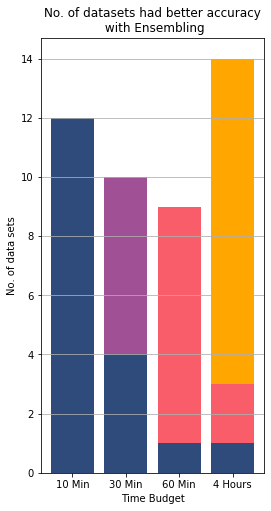

In [2]:
x_label = 'Data Sets'
fig = Figure()
meta = 'sklearn_v_accuracy_mean'
vanilla = 'sklearn_e_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Ensembling'
fig.compare_acc_bar(meta, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.1], divide_data=False)

# How often each tool succeeded to deliver a pipeline within the given time budget?

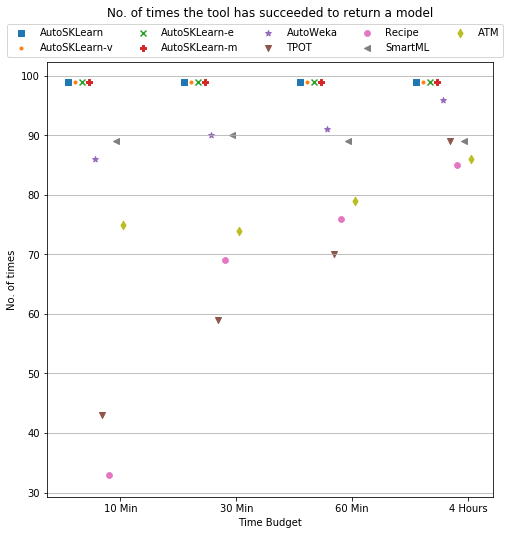

In [63]:
sheet_path = r'C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\Complete_Sheet.xlsx'
result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features'])
experiment_time = ['10 Min', '30 Min', '60 Min', '4 Hours']
frameworks = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML', 'ATM']
#colors        = ['seagreen', 'red', 'orchid', 'orange']
gray_colors = itertools.cycle(['silver', 'gainsboro', 'gray', 'lightgrey', 'darkgray'])

# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '4 Hours']:
#         result[tt] = result[tt][condition]
autoSKLearn = [np.sum(result['10 Min'].sklearn_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_accuracy_mean> 0),
            np.sum(result['4 Hours'].sklearn_accuracy_mean> 0)]
autoSKLearn_v = [np.sum(result['10 Min'].sklearn_v_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_v_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_v_accuracy_mean> 0),
            np.sum(result['4 Hours'].sklearn_v_accuracy_mean> 0)]
autoSKLearn_e = [np.sum(result['10 Min'].sklearn_e_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_e_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_e_accuracy_mean> 0),
            np.sum(result['4 Hours'].sklearn_e_accuracy_mean> 0)]
autoSKLearn_m = [np.sum(result['10 Min'].sklearn_m_accuracy_mean> 0),
            np.sum(result['30 Min'].sklearn_m_accuracy_mean> 0),
            np.sum(result['60 Min'].sklearn_m_accuracy_mean> 0),
            np.sum(result['4 Hours'].sklearn_m_accuracy_mean> 0)]
autoweka = [np.sum(result['10 Min'].autoweka_accuracy_mean> 0),
            np.sum(result['30 Min'].autoweka_accuracy_mean> 0),
            np.sum(result['60 Min'].autoweka_accuracy_mean> 0),
            np.sum(result['4 Hours'].autoweka_accuracy_mean> 0)]
TPOT = [np.sum(result['10 Min'].tpot_accuracy_mean> 0),
            np.sum(result['30 Min'].tpot_accuracy_mean> 0),
            np.sum(result['60 Min'].tpot_accuracy_mean> 0),
            np.sum(result['4 Hours'].tpot_accuracy_mean> 0)]
Recipe = [np.sum(result['10 Min'].recipe_test_acc> 0),
            np.sum(result['30 Min'].recipe_test_acc> 0),
            np.sum(result['60 Min'].recipe_test_acc> 0),
            np.sum(result['4 Hours'].recipe_test_acc> 0)]
SmartML = [np.sum(result['10 Min'].smartml_valid_acc> 0),
            np.sum(result['30 Min'].smartml_valid_acc> 0),
            np.sum(result['60 Min'].smartml_valid_acc> 0),
            np.sum(result['4 Hours'].smartml_valid_acc> 0)]
atm = [np.sum(result['10 Min'].atm_acc> 0),
            np.sum(result['30 Min'].atm_acc> 0),
            np.sum(result['60 Min'].atm_acc> 0),
            np.sum(result['4 Hours'].atm_acc> 0)]
numerical = [autoSKLearn,
             autoSKLearn_v,
             autoSKLearn_e,
             autoSKLearn_m,
             autoweka,
             TPOT,
             Recipe,
             SmartML,
             atm]
#rint(np.sum(result['10 Min'].autoweka_accuracy_mean > 0))
#rint((result['10 Min'].autoweka_accuracy_mean > 0).to_string())
number_groups = len(frameworks) 
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(len(experiment_time)) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(len(experiment_time)) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(experiment_time)
l = ax.legend(frameworks[0:len(frameworks)], ncol=1+len(frameworks)//2, bbox_to_anchor=(-0.1, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of times')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of times the tool has succeeded to return a model', pad = 45)
plt.savefig('./bench_figs/' + 'No of times the tool has succeeded to return a model'.replace(' ', '_') + '.pdf', format='pdf')
plt.show()

# How many times each tool has achieved the best performance?
# And what is the effect of time budget increasing over each tool?
# Does the impact of Meta-Learning, Ensembling, Genetic Based Optimization and Bayesian Based Optimization increase or decrease by time budget increasing?

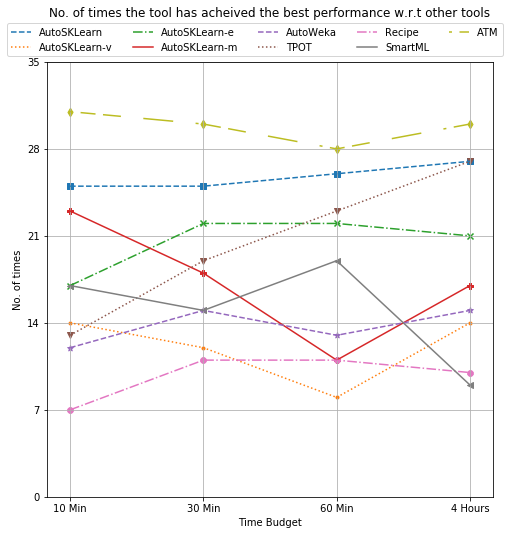

In [64]:
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML', 'ATM']
types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'atm_acc']
# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '4 Hours']:
#         result[tt] = result[tt][condition]

T=[]


for t in experiment_time:
    total = [0,0,0,0,0,0,0,0,0]
    for i in result[t][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
y_lim = (1 + max(map(max, s))//5) * 5
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
for i in range(len(types)-1):
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])

line1, = ax.plot(t, s[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[len(types)-1],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of times')
ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, y_lim])
plt.legend(loc='upper left', labels=labels, ncol=5, bbox_to_anchor=(-0.1, 1.1))
plt.title(label='No. of times the tool has acheived the best performance w.r.t other tools', pad=45)
plt.savefig('./bench_figs/' + 'No of times the tool has acheived the best performance w.r.t other tools'.replace(' ', '_') + '.pdf', format='pdf')
plt.show()

# How many times each tool has achieved the worst performance?

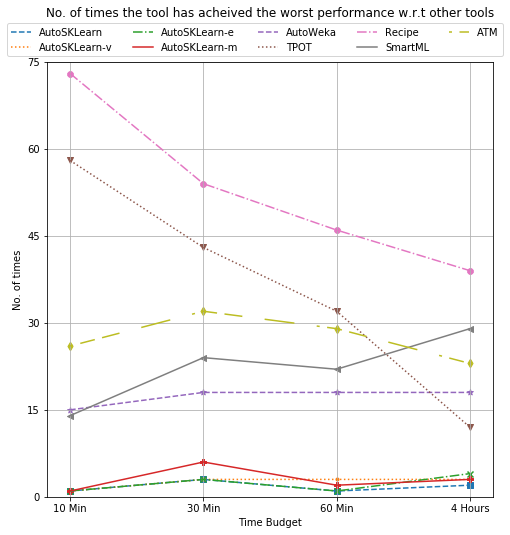

In [65]:
types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'atm_acc']
# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '4 Hours']:
#         result[tt] = result[tt][condition]


T=[]
for t in experiment_time:
    total = [0,0,0,0,0,0,0,0,0]
    for i in result[t][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        min_value = min(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if x-min_value<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
#print(s)
y_lim = (1 + max(map(max, s))//5) * 5
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
for i in range(len(types)-1):
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])

line1, = ax.plot(t, s[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[len(types)-1],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of times')
plt.title(label='No. of times the tool has acheived the worst performance w.r.t other tools', pad=45)
ax.grid()
#plt.xlim([-3, 3])
ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
plt.ylim([0, y_lim])
plt.legend(loc='upper left', ncol=5,labels=labels, bbox_to_anchor=(-0.1, 1.1))
plt.savefig('./bench_figs/' + 'No of times the tool has acheived the worst performance w.r.t other tools'.replace(' ', '_') + '.pdf', format='pdf')
plt.show()

# What is the best time budget for each tool ? In each time budget, how many datasets reached the maximum accuracy w.r.t this tool only ?

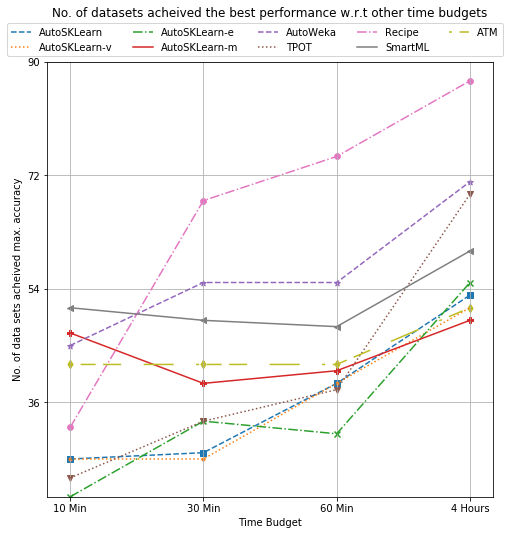

In [66]:
types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'atm_acc']
# for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
#              'Small # features and Large # instances', 'Large # features and Small # instances',
#              'Large # (features and instances)'],
#          [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
#          result['meta-features'].nr_classes >2,
#          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
#          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
#           (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
#          ]):
#     result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
#               sheet_name=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features'])
#     for tt in ['10 Min', '30 Min', '60 Min', '4 Hours']:
#         result[tt] = result[tt][condition]


total = [0,0,0,0]

T = [[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]] 



for j in range(len(types)):
    for i in result['10 Min'][types[0]].index:
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][types[j]][i] for t in experiment_time]
        #print(my_list)
        my_list = [0 if np.isnan(t) else t for t in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        for ind in range(4):
            if max_value - my_list[ind] <0.00001:
                T[j][ind] +=1
#print(T)
y_lim = (1 + max(map(max, T))//5) * 5
t = experiment_time
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
for i in range(len(types)-1):
    ax.plot(t, T[i],linestyle=style[i],label=labels[i])
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=T[i],
           #color= next(gray_colors),
           marker =next(markers))

line1, = ax.plot(t, T[len(types)-1],linestyle='-',label=labels[len(types)-1])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=T[len(types)-1],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of data sets acheived max. accuracy')
plt.title(label='No. of datasets acheived the best performance w.r.t other time budgets', pad=45)
ax.grid()
#plt.xlim([-3, 3])
ax.set_yticks(np.arange(0,5+y_lim, y_lim//5))
plt.ylim([min(map(min, T)), y_lim])
plt.legend(loc='upper left', ncol=5,labels=labels, bbox_to_anchor=(-0.1, 1.1))
plt.savefig('./bench_figs/' + 'No of datasets acheived the best performance w.r.t other time budgets'.replace(' ', '_') + '.pdf', format='pdf')
plt.show()

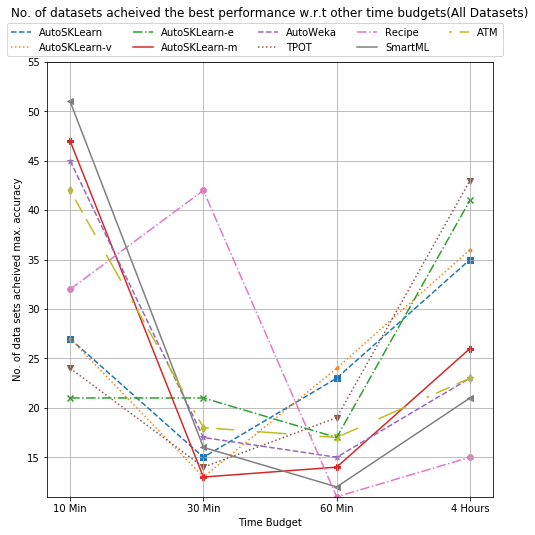

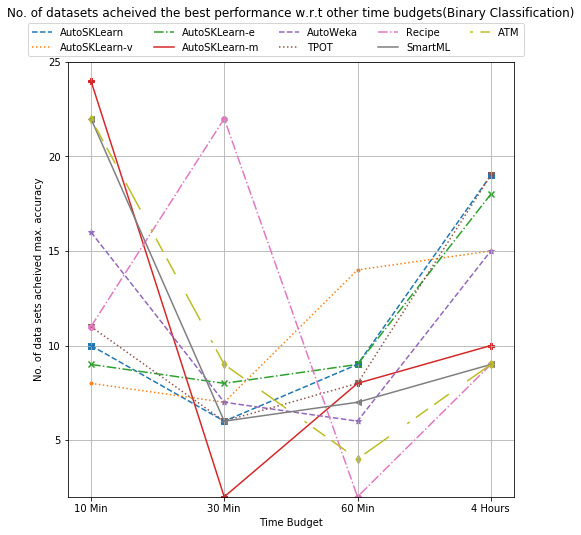

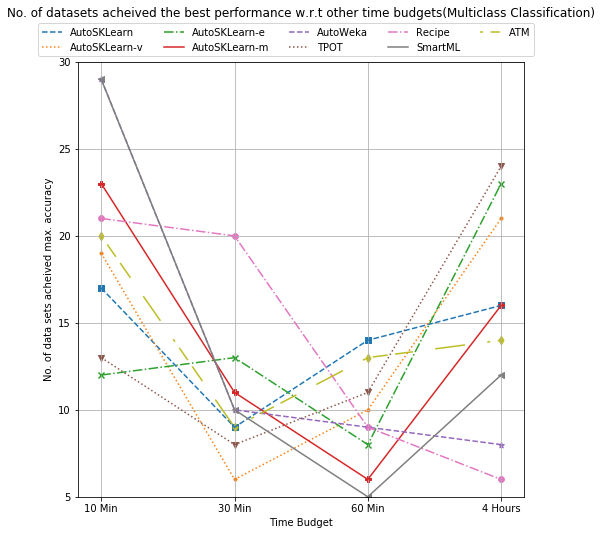

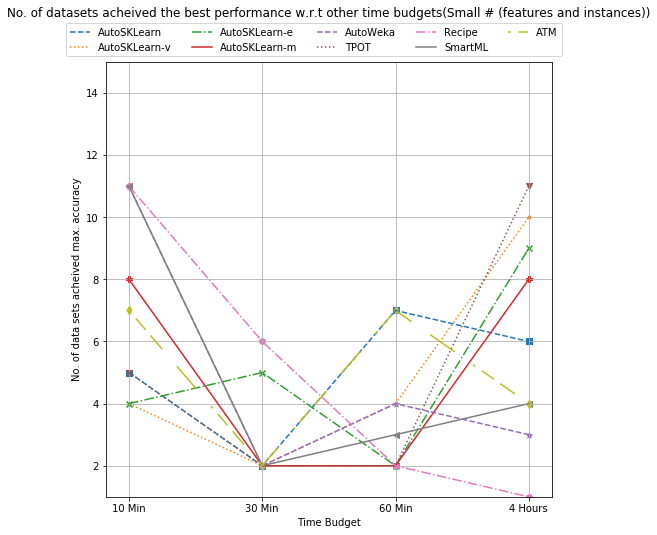

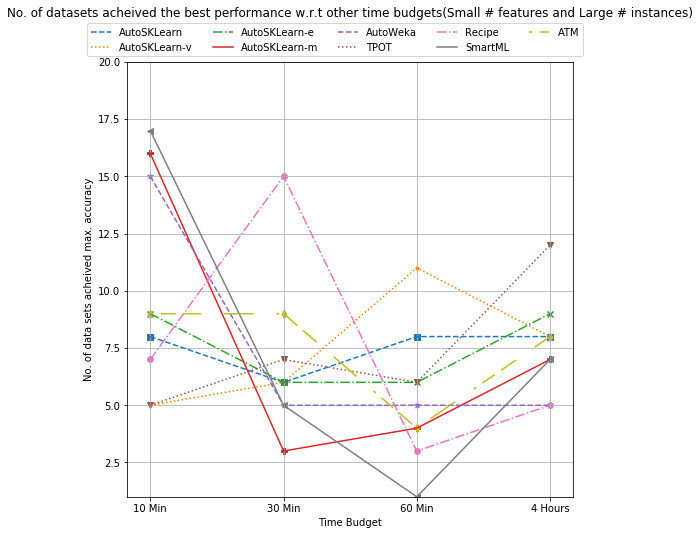

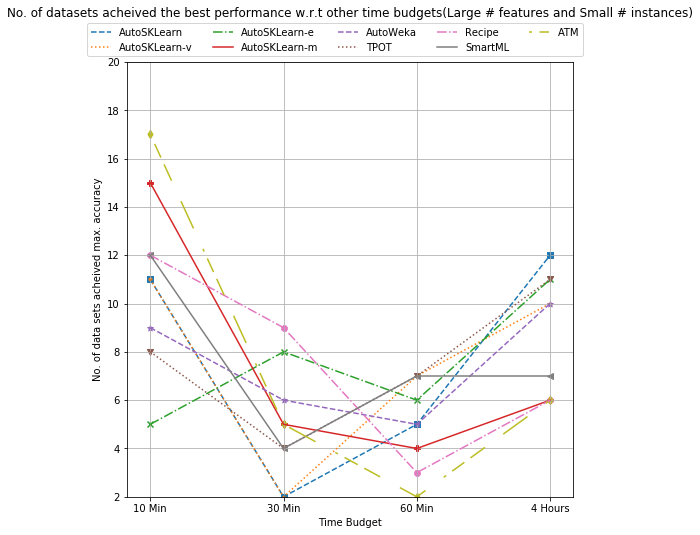

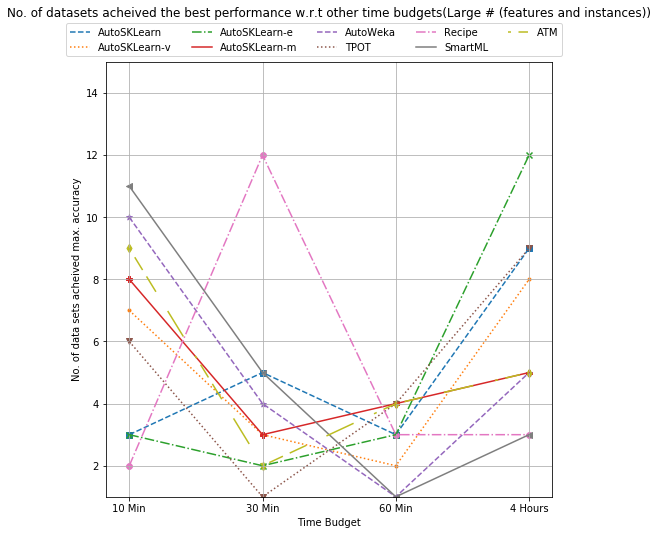

In [7]:
types= ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'atm_acc']
for (case, condition) in zip(['All Datasets', 'Binary Classification', 'Multiclass Classification', 'Small # (features and instances)',
             'Small # features and Large # instances', 'Large # features and Small # instances',
             'Large # (features and instances)'],
         [result['meta-features'].nr_classes > -1, result['meta-features'].nr_classes == 2,
         result['meta-features'].nr_classes >2,
         (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
          (result['meta-features'].nr_features < result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median()),
         (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances < result['meta-features'].nr_instances.median()),
          (result['meta-features'].nr_features > result['meta-features'].nr_features.median()) & (result['meta-features'].nr_instances > result['meta-features'].nr_instances.median())
         ]):
    result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features'])
    for tt in ['10 Min', '30 Min', '60 Min', '4 Hours']:
        result[tt] = result[tt][condition]
        
    total = [0,0,0,0]

    T = [[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]] 



    for j in range(len(types)):
        for i in result['10 Min'][types[0]].index:
            #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
            my_list= [result[t][types[j]][i] for t in experiment_time]
            #print(my_list)
            my_list = [0 if np.isnan(t) else t for t in my_list]
            max_value = max(my_list)
            #print(max_value,my_list)
            for ind in range(4):
                if max_value - my_list[ind] <0.00001:
                    T[j][ind] +=1
                    break
    #print(T)
    y_lim = (1 + max(map(max, T))//5) * 5
    t = experiment_time
    fig, ax = plt.subplots(figsize=(8,8))
    #ax.plot(t, s[0],linestyle='-',label=labels[0])
    style = ['--', ':', '-.', '-', '--', ':', '-.', '-']
    markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
    for i in range(len(types)-1):
        ax.plot(t, T[i],linestyle=style[i],label=labels[i])
        ax.scatter(x=np.arange(len(experiment_time)), 
               y=T[i],
               #color= next(gray_colors),
               marker =next(markers))

    line1, = ax.plot(t, T[len(types)-1],linestyle='-',label=labels[len(types)-1])
    line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
    ax.scatter(x=np.arange(len(experiment_time)), 
               y=T[len(types)-1],
               #color= next(gray_colors),
               marker =next(markers))
    ax.set(xlabel='Time Budget', ylabel='No. of data sets acheived max. accuracy')
    plt.title(label='No. of datasets acheived the best performance w.r.t other time budgets(' + case + ')', pad=45)
    ax.grid()
    #plt.xlim([-3, 3])
    plt.ylim([min(map(min, T)), y_lim])
    plt.legend(loc='upper left', ncol=5, labels=labels, bbox_to_anchor=(-0.1, 1.1))
    plt.show()

# How many times Meta-learning improved the performance and what is the average improvement in AutoSKLearn?

[34]


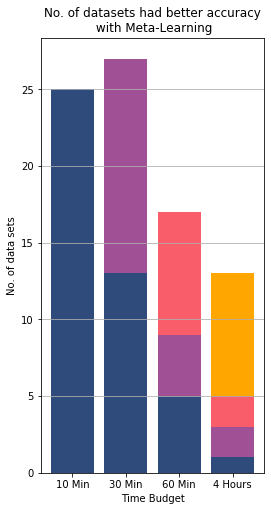

In [8]:
x_label = 'Data Sets'
fig = Figure()
meta = 'sklearn_m_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Meta-Learning'
fig.compare_acc_bar(meta, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.1], divide_data=False)

[]


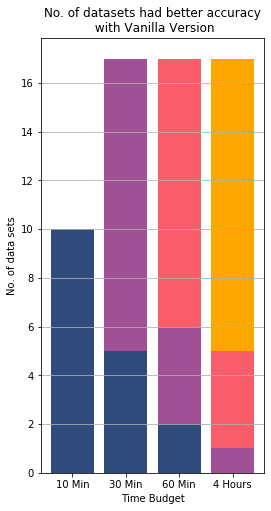

In [9]:
x_label = 'Data Sets'
fig = Figure()
meta = 'sklearn_m_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Vanilla Version'
fig.compare_acc_bar(vanilla, meta, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.1], divide_data=True)

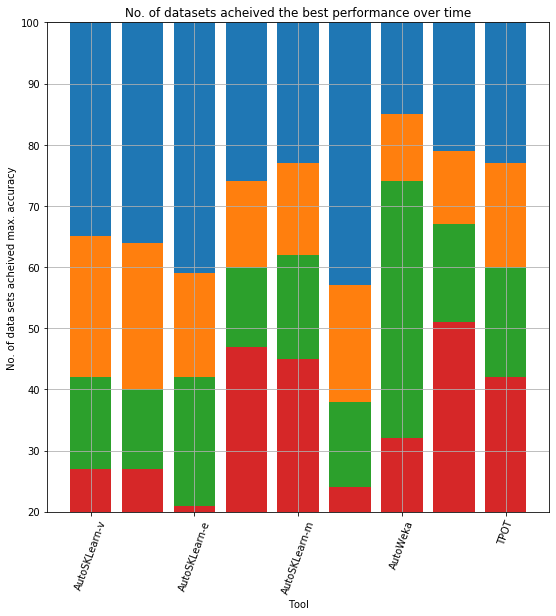

In [10]:

total = [0,0,0,0]

T = [[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]] 
result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features'])


for j in range(len(types)):
    for i in range(100):
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][types[j]][i] for t in experiment_time]
        #print(my_list)
        my_list = [0 if np.isnan(t) else t for t in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        for ind in range(4):
            if max_value - my_list[ind] <0.00001:
                T[j][ind] +=1
                break
#print(T)

t = experiment_time
fig, ax = plt.subplots(figsize=(9,9))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])

for k in range(len(experiment_time)):
    plt.bar(np.arange(len(types)), [sum(T[j][i] for i in np.arange(len(experiment_time)-k)) for j in np.arange(len(types))])

ax.set(xlabel='Tool', ylabel='No. of data sets acheived max. accuracy',title='No. of datasets acheived the best performance over time')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([20, 100])
#plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
ax.set_xticklabels(labels)
plt.xticks(rotation=70)
plt.show()

Average loss = -5.6 from 10 datasets
 64 datasets have the same performance
Average gain = 2.9 from 25 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


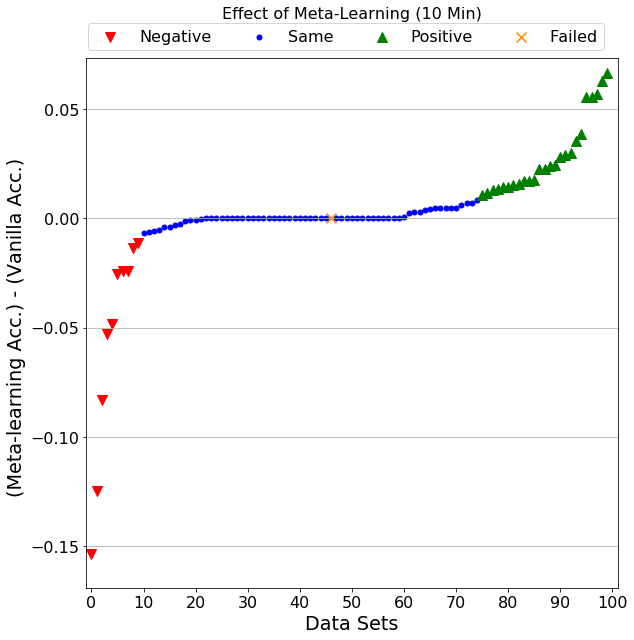

In [11]:
%matplotlib inline 
x_label = 'Data Sets'
fig = Figure()
meta = fig.get_sheet()['10 Min'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['10 Min'].sklearn_v_accuracy_mean
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'Effect of Meta-Learning (10 Min)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.1], divide_data=True)

Average loss = -4.5 from 17 datasets
 55 datasets have the same performance
Average gain = 2.8 from 27 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


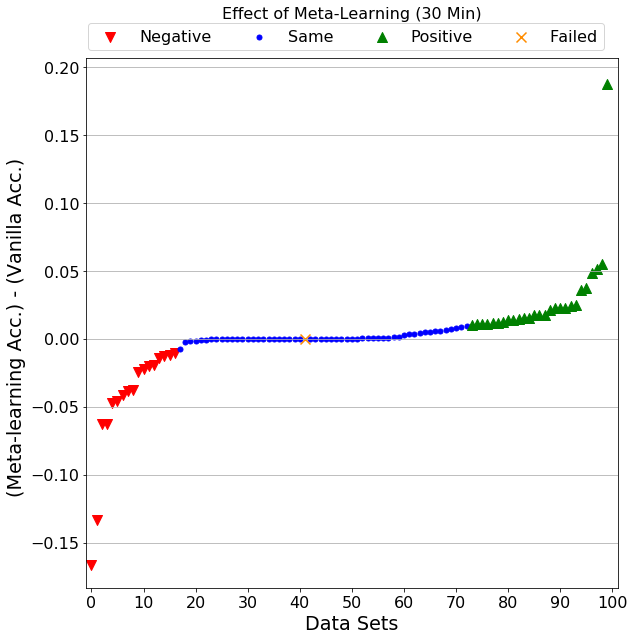

In [12]:
fig = Figure()
meta = fig.get_sheet()['30 Min'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['30 Min'].sklearn_v_accuracy_mean
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'Effect of Meta-Learning (30 Min)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.2], divide_data=True)

Average loss = -4.4 from 17 datasets
 65 datasets have the same performance
Average gain = 3.4 from 17 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


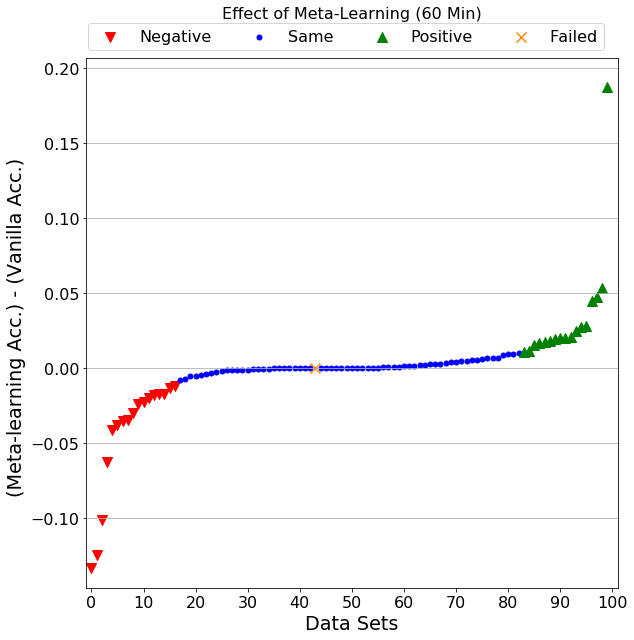

In [13]:
fig = Figure()
meta = fig.get_sheet()['60 Min'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['60 Min'].sklearn_v_accuracy_mean
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'Effect of Meta-Learning (60 Min)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, divide_data=True)

Average loss = -2.7 from 17 datasets
 69 datasets have the same performance
Average gain = 5.5 from 13 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


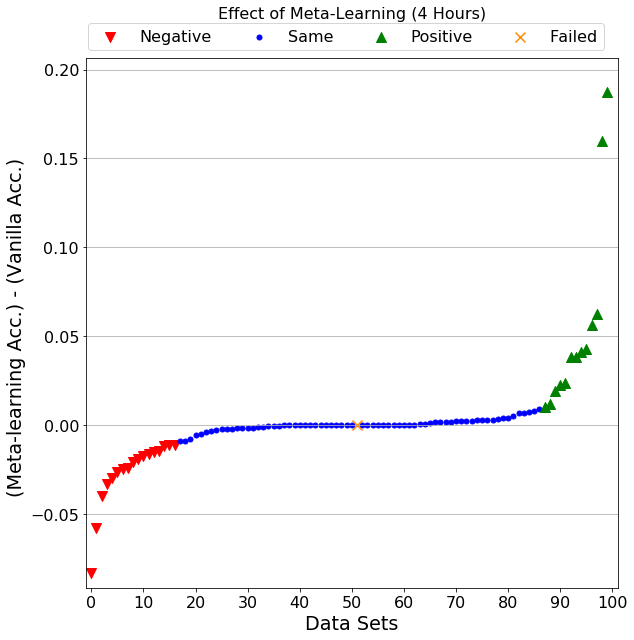

In [14]:
fig = Figure()
meta = fig.get_sheet()['4 Hours'].sklearn_m_accuracy_mean
vanilla = fig.get_sheet()['4 Hours'].sklearn_v_accuracy_mean
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'Effect of Meta-Learning (4 Hours)'
fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.15, 0.2], divide_data=True)

# How many times Ensembling improved the performance and what is the average improvement in AutoSKLearn?

[ 5 46 64]


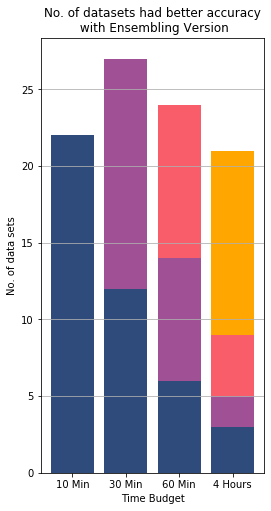

In [15]:
x_label = 'Data Sets'
fig = Figure()
ensembling = 'sklearn_e_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Ensembling Version'
fig.compare_acc_bar(ensembling, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.1], divide_data=True)

[26]


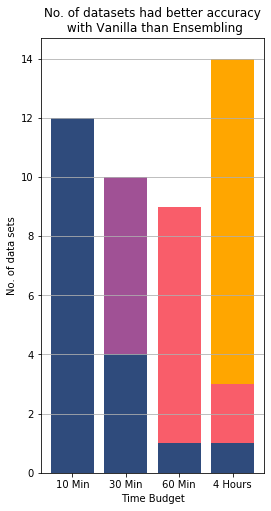

In [16]:
x_label = 'Data Sets'
fig = Figure()
ensembling = 'sklearn_e_accuracy_mean'
vanilla = 'sklearn_v_accuracy_mean'
y_lable = '(Meta-learning Acc.) - (Vanilla Acc.) '
title = 'No. of datasets had better accuracy\n with Vanilla than Ensembling'
fig.compare_acc_bar(vanilla, ensembling, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.1], divide_data=True)

Average loss = -3.4 from 12 datasets
 65 datasets have the same performance
Average gain = 4.1 from 22 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


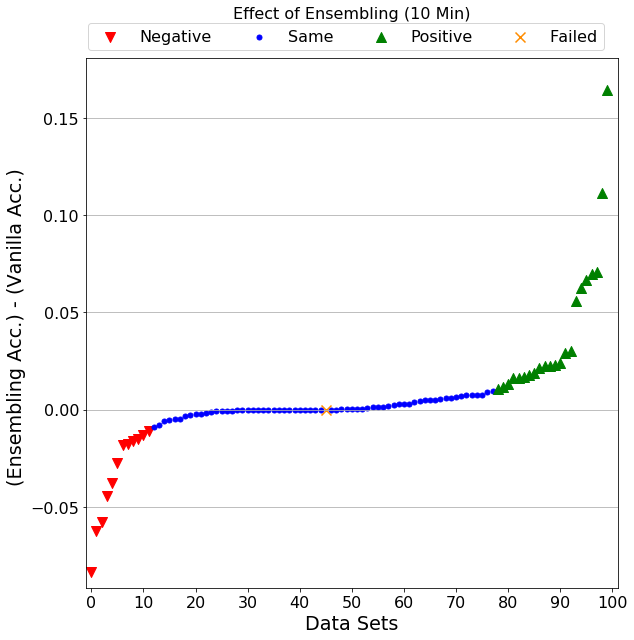

In [17]:
x_label = 'Data Sets'
fig = Figure()
ensembling = fig.get_sheet()['10 Min'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['10 Min'].sklearn_v_accuracy_mean
y_lable = '(Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Ensembling (10 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.1, 0.2], divide_data=True)

Average loss = -3.1 from 10 datasets
 62 datasets have the same performance
Average gain = 3.4 from 27 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


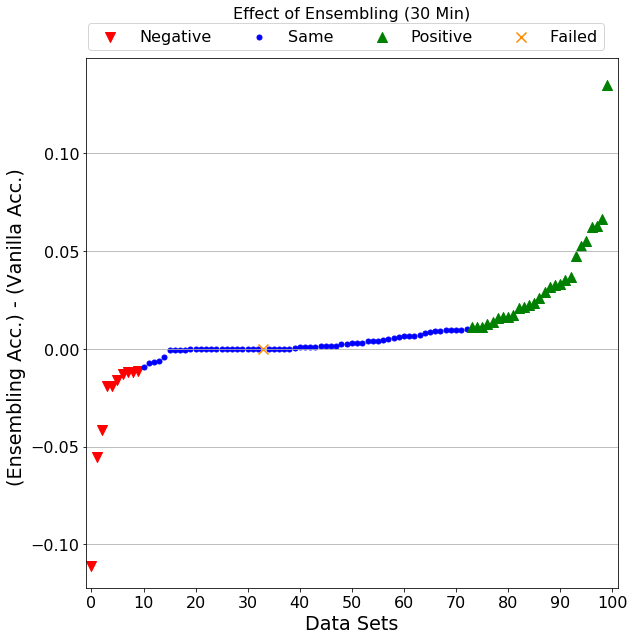

In [18]:
fig = Figure()
ensembling = fig.get_sheet()['30 Min'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['30 Min'].sklearn_v_accuracy_mean
y_lable = '(Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Ensembling (30 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.15, 0.15], divide_data=True)

Average loss = -3.1 from 9 datasets
 66 datasets have the same performance
Average gain = 4.9 from 24 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


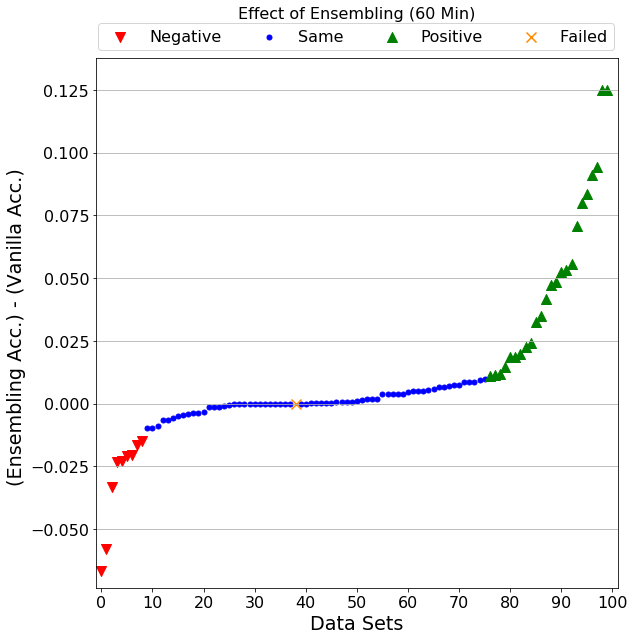

In [19]:
fig = Figure()
ensembling = fig.get_sheet()['60 Min'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['60 Min'].sklearn_v_accuracy_mean
y_lable = '(Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Ensembling (60 Min)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.1, 0.15], divide_data=True)

Average loss = -2.9 from 14 datasets
 64 datasets have the same performance
Average gain = 7.1 from 21 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


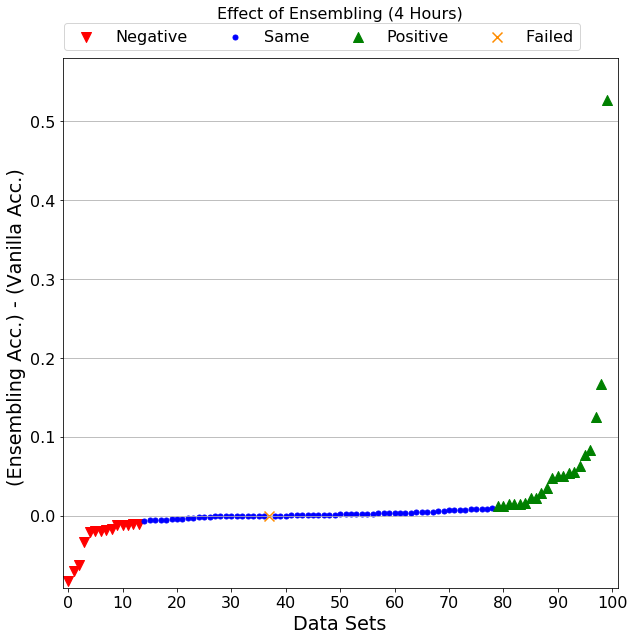

In [20]:
fig = Figure()
ensembling = fig.get_sheet()['4 Hours'].sklearn_e_accuracy_mean
vanilla = fig.get_sheet()['4 Hours'].sklearn_v_accuracy_mean
y_lable = '(Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Ensembling (4 Hours)'
fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 1], divide_data=True)

# How many times combined Meta-learning and Ensembling improved the performance and what is the average improvement in AutoSKLearn?

Average loss = -5.5 from 10 datasets
 57 datasets have the same performance
Average gain = 3.1 from 32 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


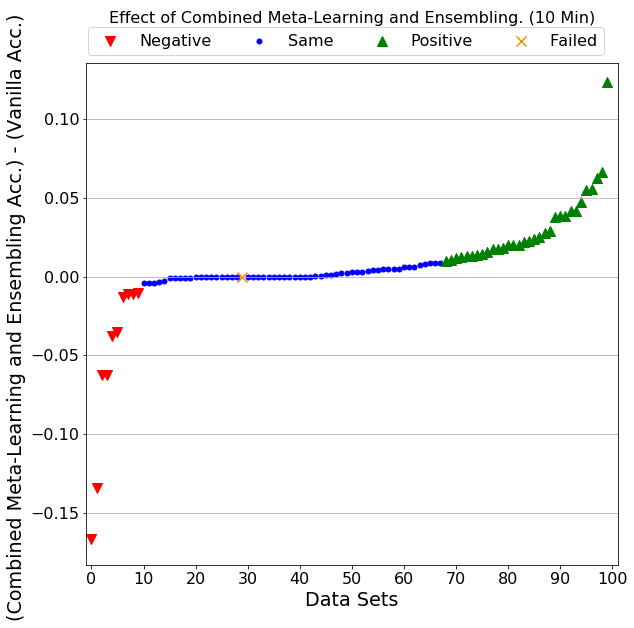

In [21]:
fig = Figure()
full = fig.get_sheet()['10 Min'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['10 Min'].sklearn_v_accuracy_mean
y_lable = '(Combined Meta-Learning and Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Combined Meta-Learning and Ensembling. (10 Min)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.2, 0.15], divide_data=True)

Average loss = -5.0 from 13 datasets
 58 datasets have the same performance
Average gain = 3.4 from 28 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


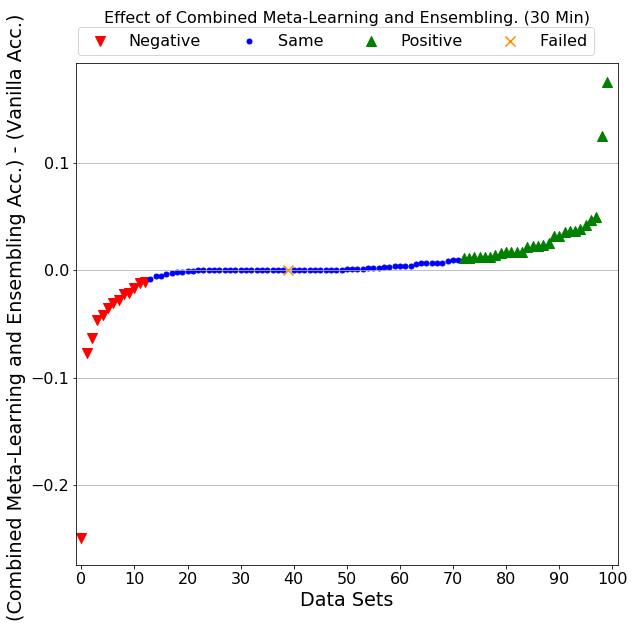

In [22]:
fig = Figure()
full = fig.get_sheet()['30 Min'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['30 Min'].sklearn_v_accuracy_mean
y_lable = '(Combined Meta-Learning and Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Combined Meta-Learning and Ensembling. (30 Min)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.8, 0.2], divide_data=True)

Average loss = -3.7 from 8 datasets
 59 datasets have the same performance
Average gain = 3.0 from 32 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


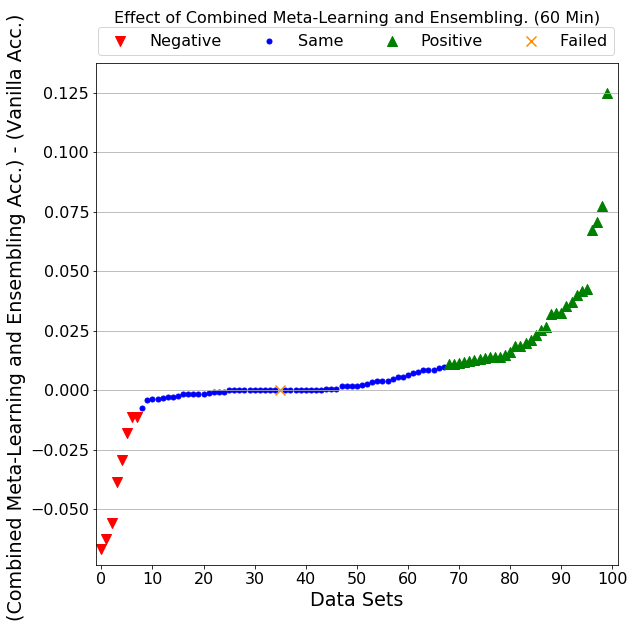

In [23]:
fig = Figure()
full = fig.get_sheet()['60 Min'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['60 Min'].sklearn_v_accuracy_mean
y_lable = '(Combined Meta-Learning and Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Combined Meta-Learning and Ensembling. (60 Min)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.1, 0.15], divide_data=True)

Average loss = -1.9 from 9 datasets
 65 datasets have the same performance
Average gain = 5.4 from 25 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


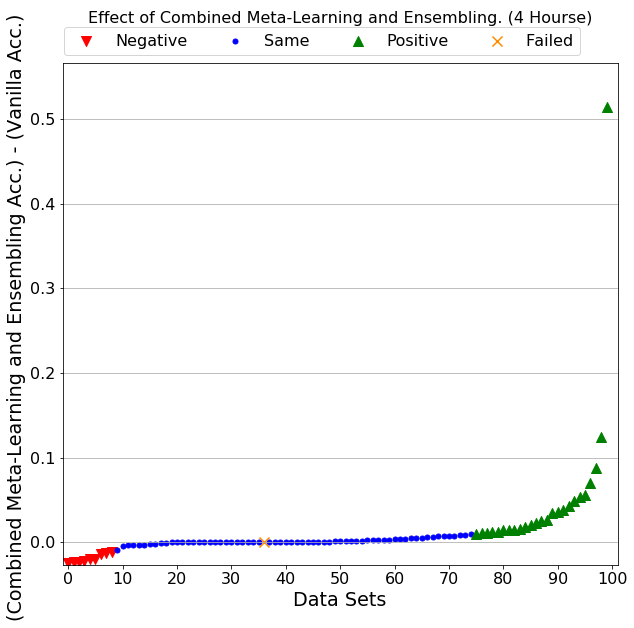

In [24]:
fig = Figure()
full = fig.get_sheet()['4 Hours'].sklearn_accuracy_mean
vanilla = fig.get_sheet()['4 Hours'].sklearn_v_accuracy_mean
y_lable = '(Combined Meta-Learning and Ensembling Acc.) - (Vanilla Acc.) '
title = 'Effect of Combined Meta-Learning and Ensembling. (4 Hourse)'
fig.compare_acc_scatter(full, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=[-0.8, 1.1], divide_data=True)

# TPOT v.s. Recipe 

Average loss = -2.5 from 1 datasets
 14 datasets have the same performance
Average gain = 26.0 from 23 datasets
5 datasets succefully run on the right side only
31 datasets succefully run on the left side only
26 datasets succefully do not run on the both sides


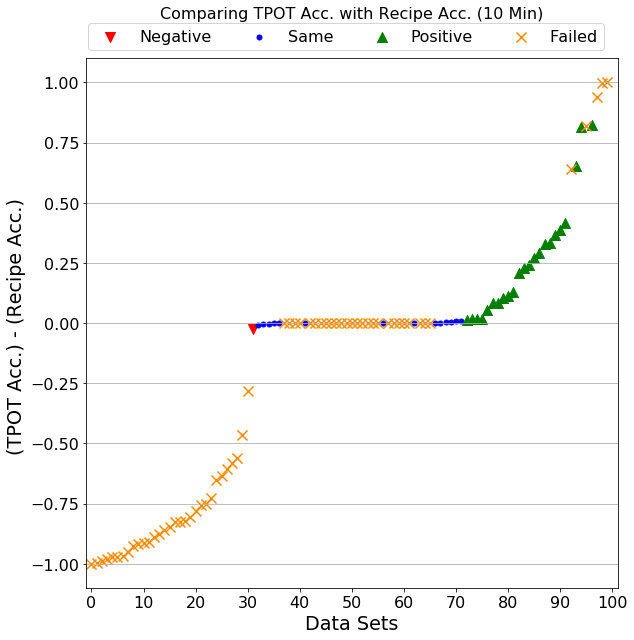

In [25]:
fig = Figure()
tpot = fig.get_sheet()['10 Min'].tpot_accuracy_mean
recipe = fig.get_sheet()['30 Min'].recipe_test_acc
x_label = 'Data Sets'
y_lable = '(TPOT Acc.) - (Recipe Acc.) '
title = 'Comparing TPOT Acc. with Recipe Acc. (10 Min)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, divide_data=True)

Average loss = -4.4 from 4 datasets
 16 datasets have the same performance
Average gain = 21.4 from 30 datasets
9 datasets succefully run on the right side only
19 datasets succefully run on the left side only
22 datasets succefully do not run on the both sides


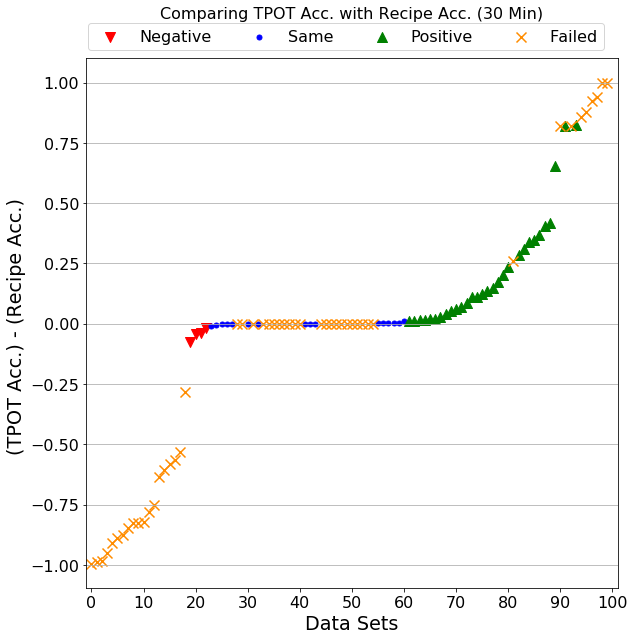

In [26]:
fig = Figure()
tpot = fig.get_sheet()['30 Min'].tpot_accuracy_mean
recipe = fig.get_sheet()['30 Min'].recipe_test_acc
x_label = 'Data Sets'
y_lable = '(TPOT Acc.) - (Recipe Acc.) '
title = 'Comparing TPOT Acc. with Recipe Acc. (30 Min)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, divide_data=True)

Average loss = -2.4 from 7 datasets
 18 datasets have the same performance
Average gain = 22.0 from 35 datasets
10 datasets succefully run on the right side only
16 datasets succefully run on the left side only
14 datasets succefully do not run on the both sides


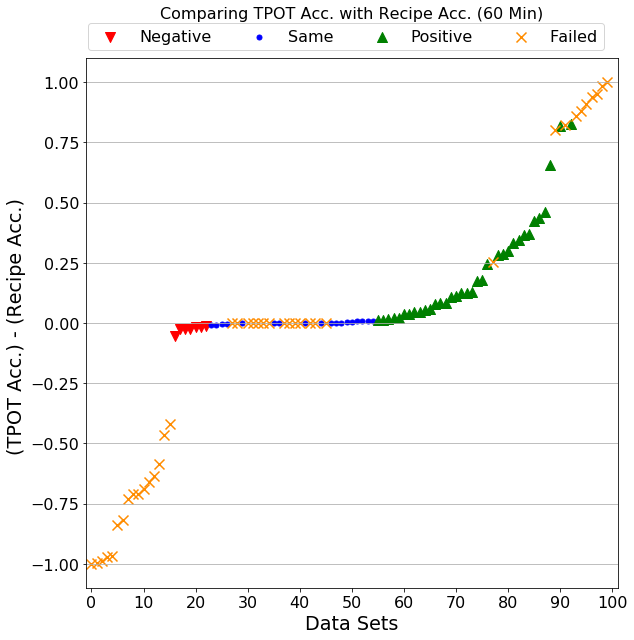

In [27]:
fig = Figure()
tpot = fig.get_sheet()['60 Min'].tpot_accuracy_mean
recipe = fig.get_sheet()['60 Min'].recipe_test_acc
x_label = 'Data Sets'
y_lable = '(TPOT Acc.) - (Recipe Acc.) '
title = 'Comparing TPOT Acc. with Recipe Acc. (60 Min)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, divide_data=True)

Average loss = -2.6 from 5 datasets
 31 datasets have the same performance
Average gain = 20.8 from 42 datasets
11 datasets succefully run on the right side only
7 datasets succefully run on the left side only
4 datasets succefully do not run on the both sides


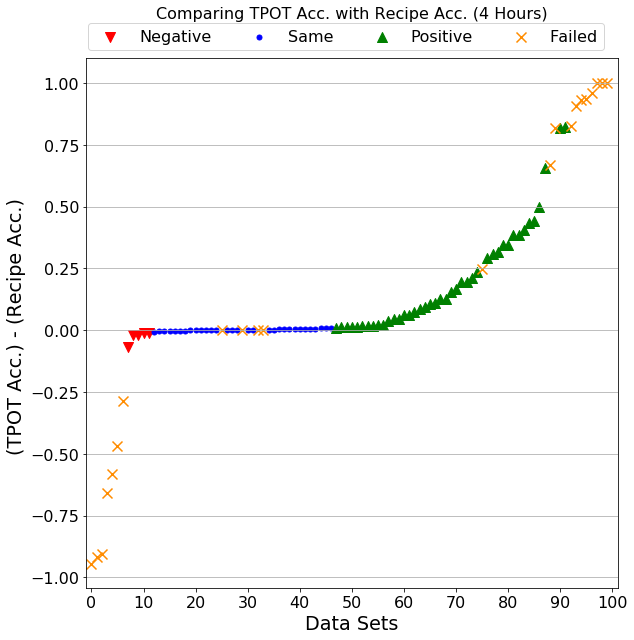

In [28]:
fig = Figure()
tpot = fig.get_sheet()['4 Hours'].tpot_accuracy_mean
recipe = fig.get_sheet()['4 Hours'].recipe_test_acc
x_label = 'Data Sets'
y_lable = '(TPOT Acc.) - (Recipe Acc.) '
title = 'Comparing TPOT Acc. with Recipe Acc. (4 Hours)'
fig.compare_acc_scatter(tpot, recipe, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, divide_data=True)

## TPOT  v.s Recipe

### TPOT
Number of Classifiers : 11 

Number of Preprocessors and Extractors : 14

Number of Feature Selector : 5

### Recipe
Number of Classifiers : 20

Number of Preprocessors and Extractors : 15

Number of Feature Selector : 8

# How much is the performance gain increse by increasing time budget ?

Average loss = -2.3 from 9 datasets
 73 datasets have the same performance
Average gain = 3.2 from 17 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


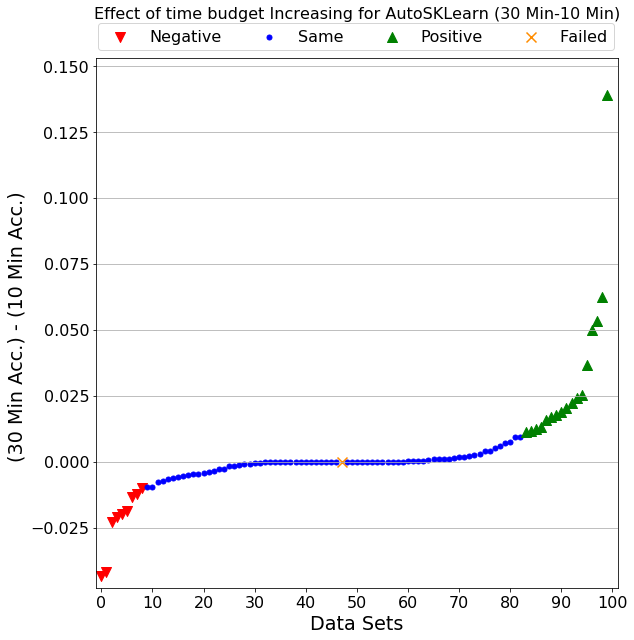

Average loss = -1.8 from 7 datasets
 71 datasets have the same performance
Average gain = 4.4 from 21 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


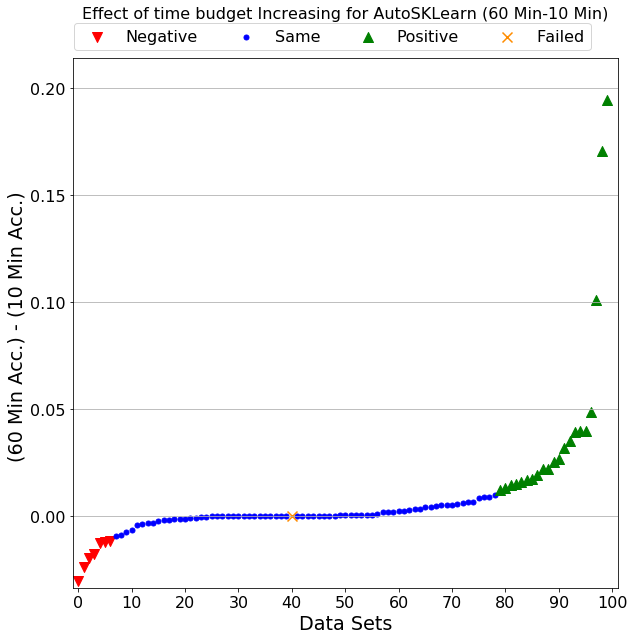

Average loss = -2.7 from 9 datasets
 69 datasets have the same performance
Average gain = 3.6 from 21 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


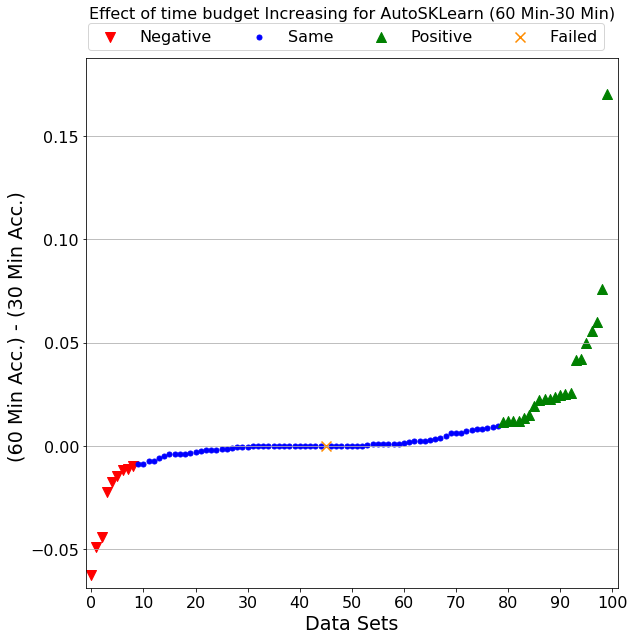

Average loss = -3.2 from 11 datasets
 62 datasets have the same performance
Average gain = 6.5 from 26 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


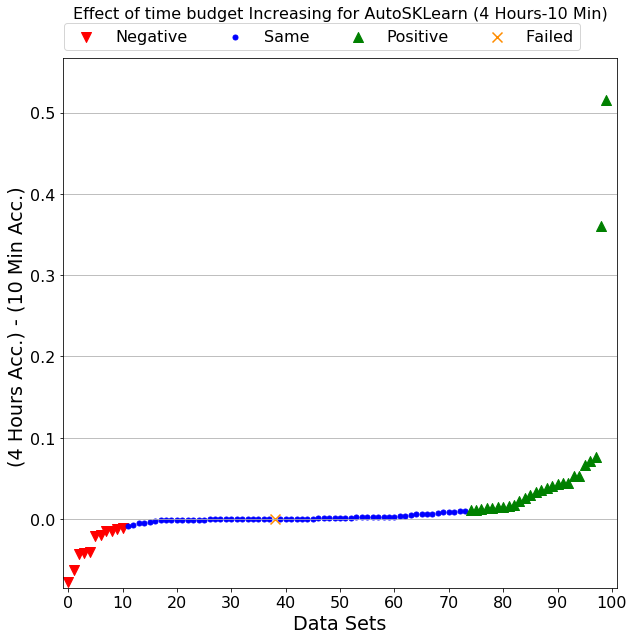

Average loss = -4.0 from 8 datasets
 66 datasets have the same performance
Average gain = 5.6 from 25 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


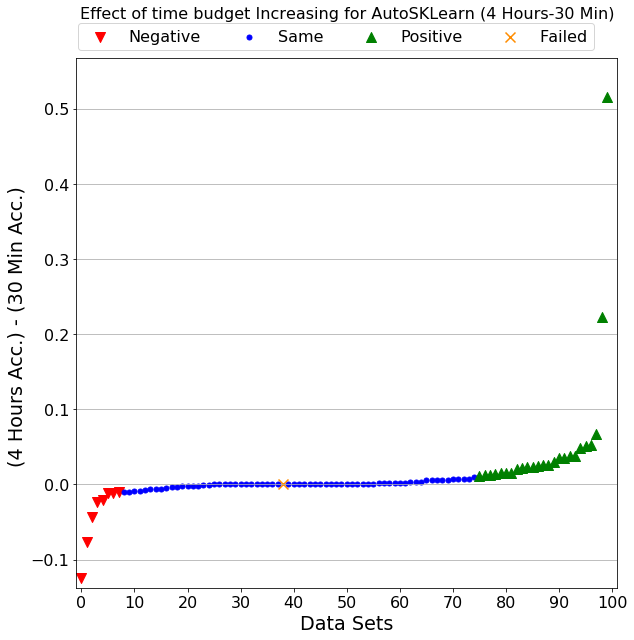

Average loss = -3.3 from 13 datasets
 64 datasets have the same performance
Average gain = 4.3 from 22 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


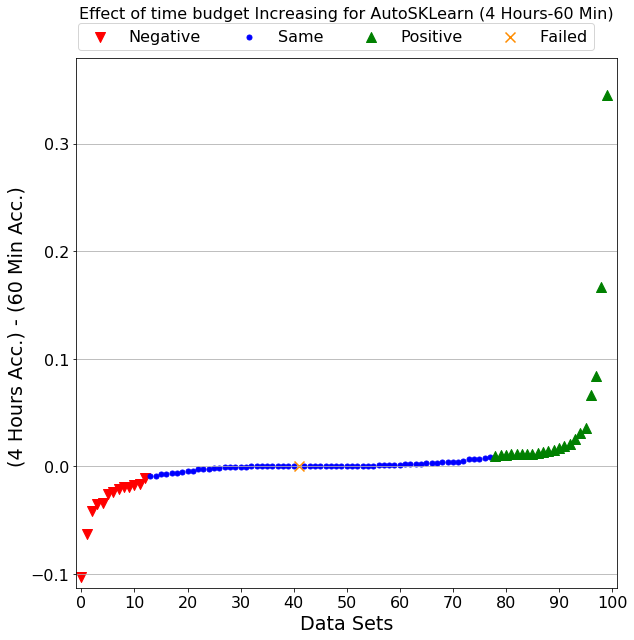

Average loss = -2.9 from 12 datasets
 69 datasets have the same performance
Average gain = 4.6 from 18 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


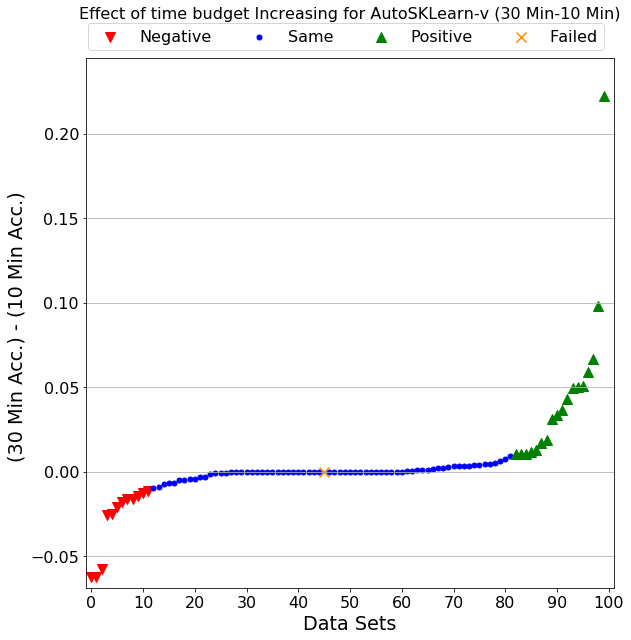

Average loss = -6.4 from 8 datasets
 63 datasets have the same performance
Average gain = 4.2 from 28 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


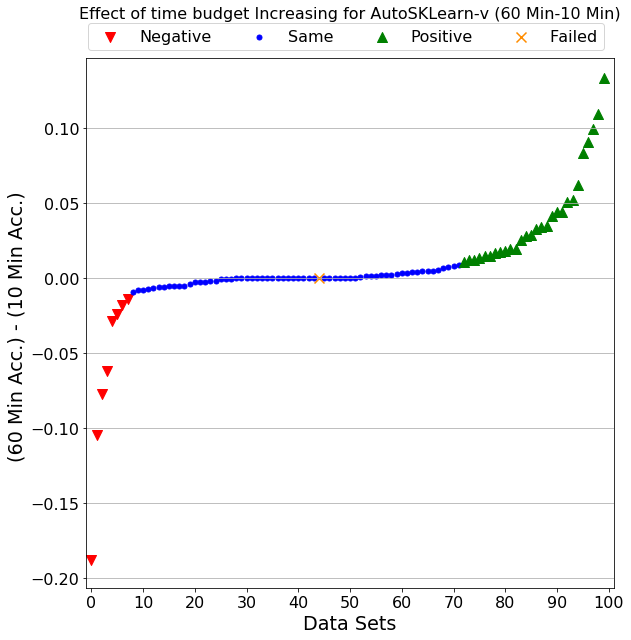

Average loss = -5.1 from 13 datasets
 63 datasets have the same performance
Average gain = 3.6 from 23 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


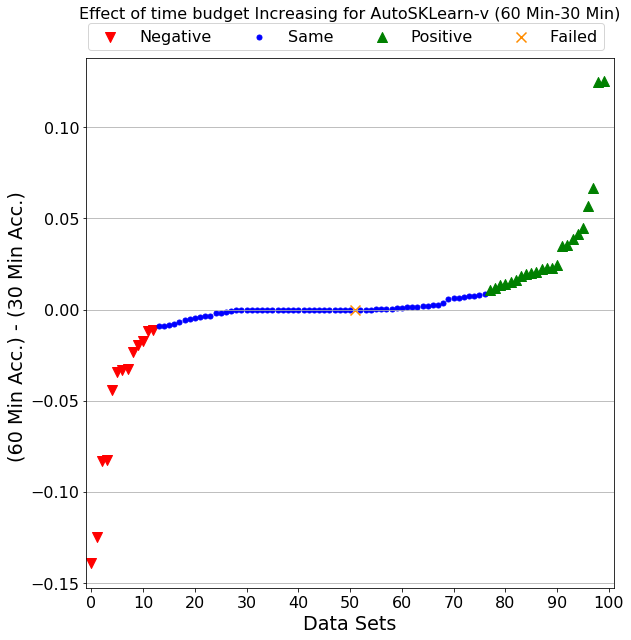

Average loss = -7.0 from 9 datasets
 59 datasets have the same performance
Average gain = 4.0 from 31 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


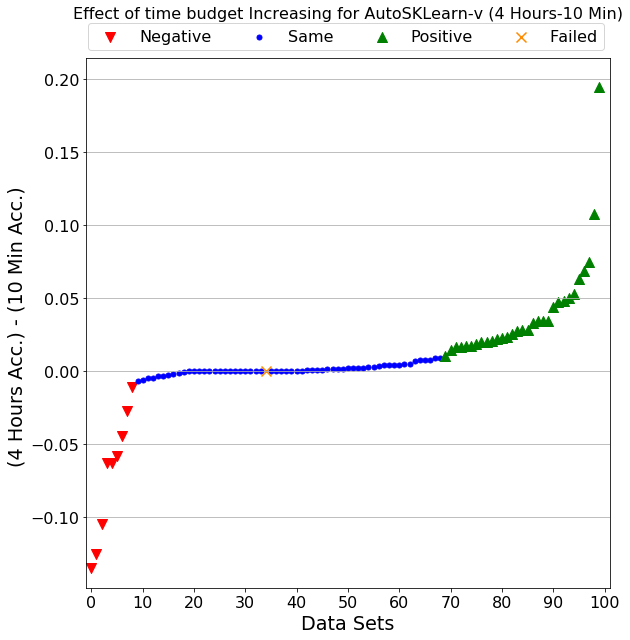

Average loss = -4.3 from 14 datasets
 57 datasets have the same performance
Average gain = 2.7 from 28 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


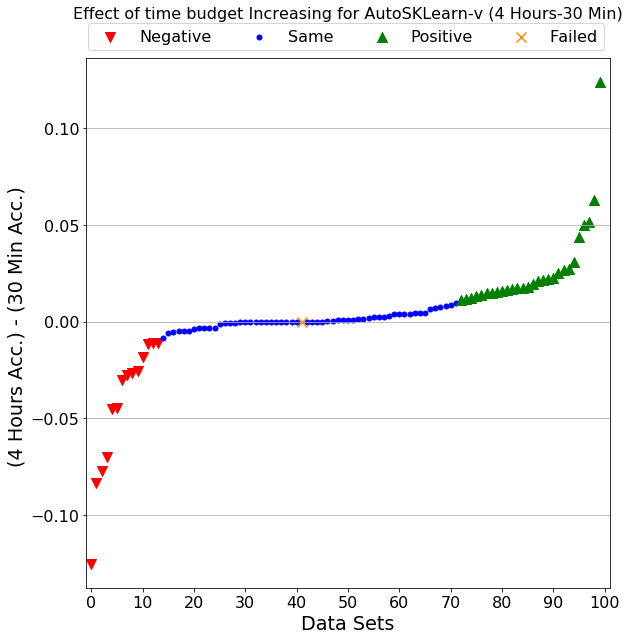

Average loss = -5.8 from 13 datasets
 62 datasets have the same performance
Average gain = 3.1 from 24 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


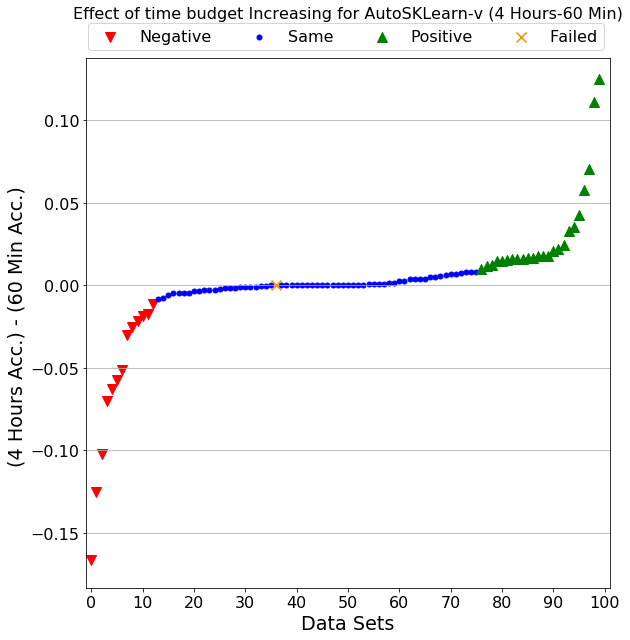

Average loss = -3.4 from 8 datasets
 67 datasets have the same performance
Average gain = 3.6 from 24 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


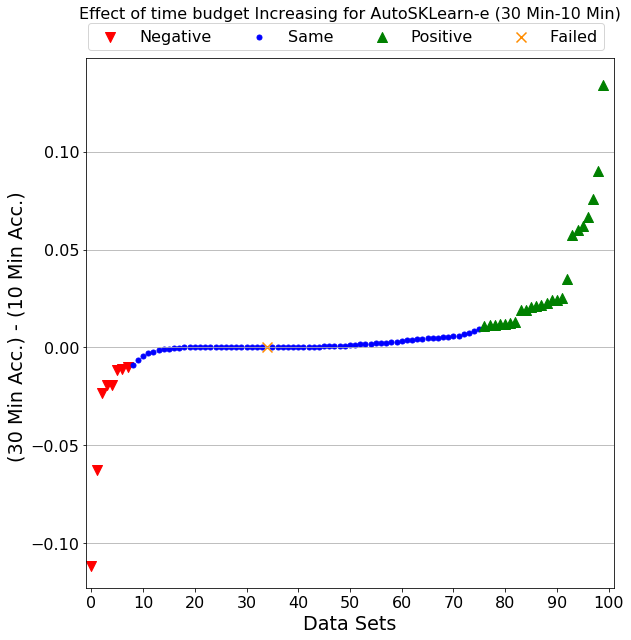

Average loss = -2.4 from 9 datasets
 65 datasets have the same performance
Average gain = 5.0 from 25 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


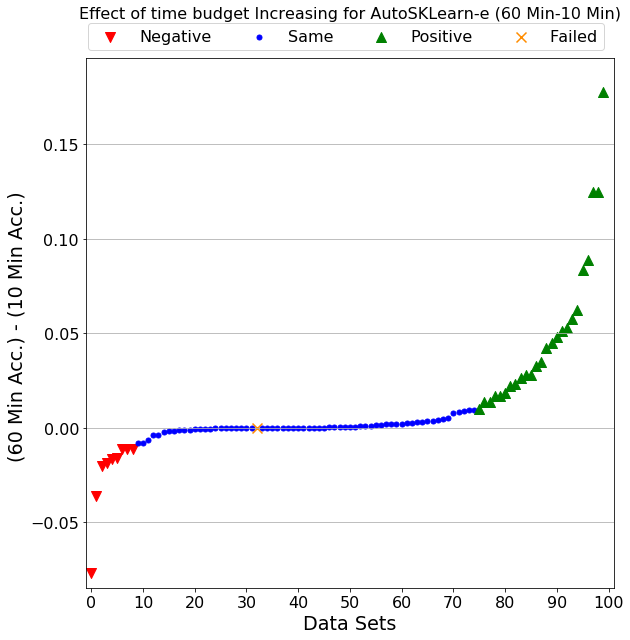

Average loss = -2.4 from 15 datasets
 66 datasets have the same performance
Average gain = 4.3 from 18 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


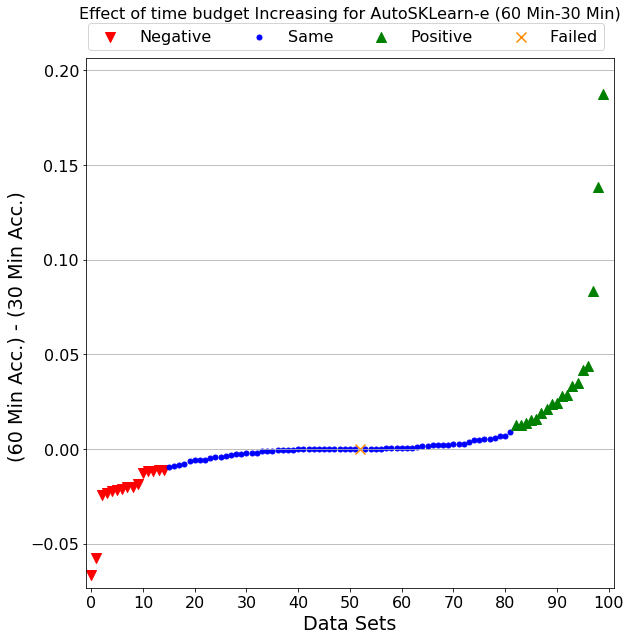

Average loss = -3.6 from 10 datasets
 57 datasets have the same performance
Average gain = 5.1 from 32 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


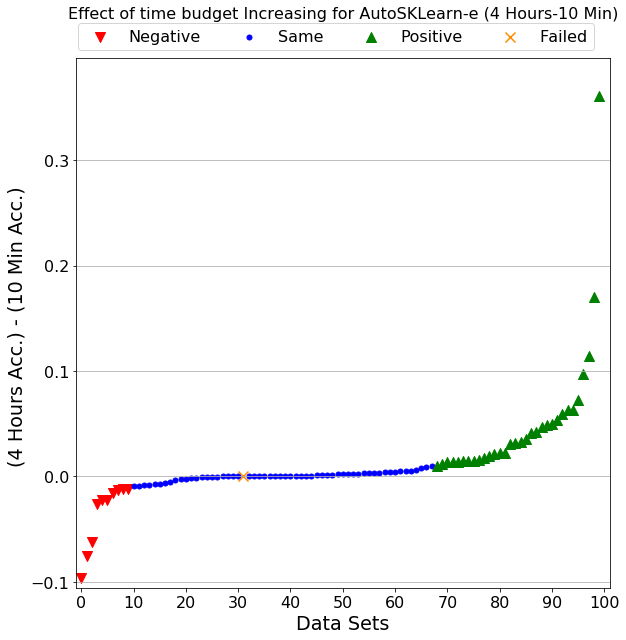

Average loss = -3.8 from 15 datasets
 62 datasets have the same performance
Average gain = 5.0 from 22 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


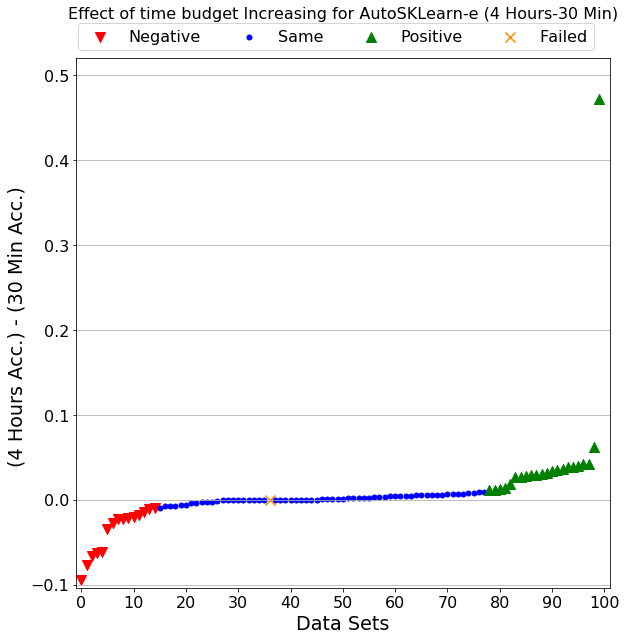

Average loss = -3.8 from 15 datasets
 64 datasets have the same performance
Average gain = 3.8 from 20 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


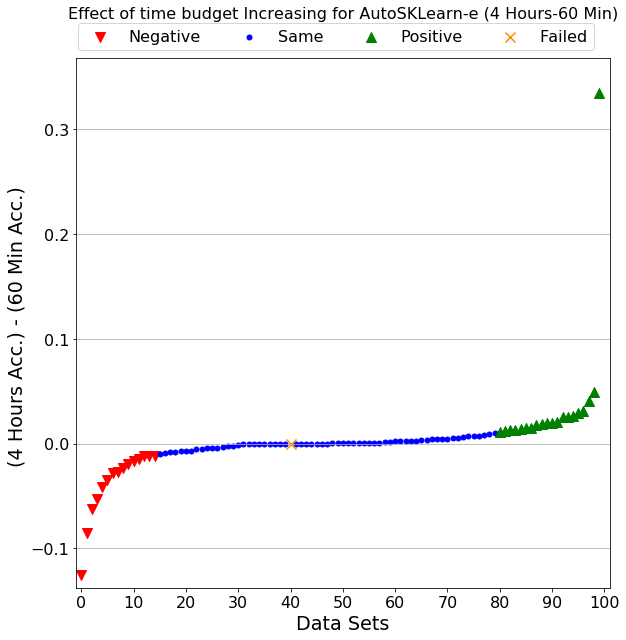

Average loss = -3.0 from 12 datasets
 68 datasets have the same performance
Average gain = 3.8 from 19 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


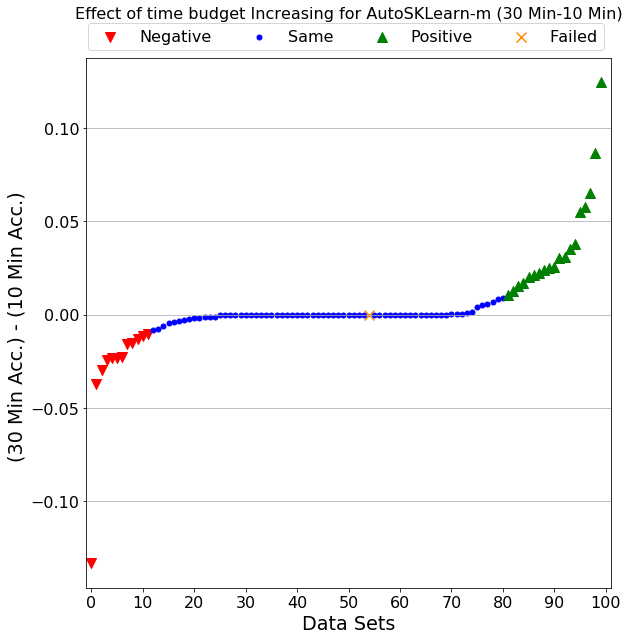

Average loss = -3.9 from 13 datasets
 65 datasets have the same performance
Average gain = 4.1 from 21 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


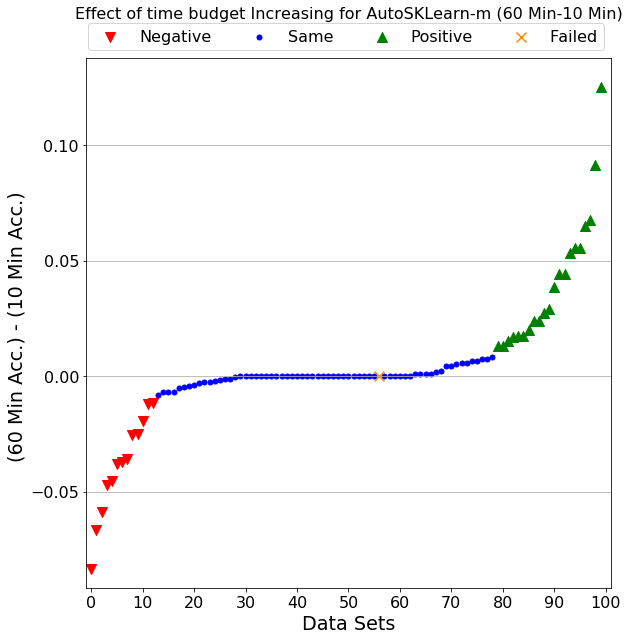

Average loss = -4.1 from 14 datasets
 71 datasets have the same performance
Average gain = 4.1 from 14 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


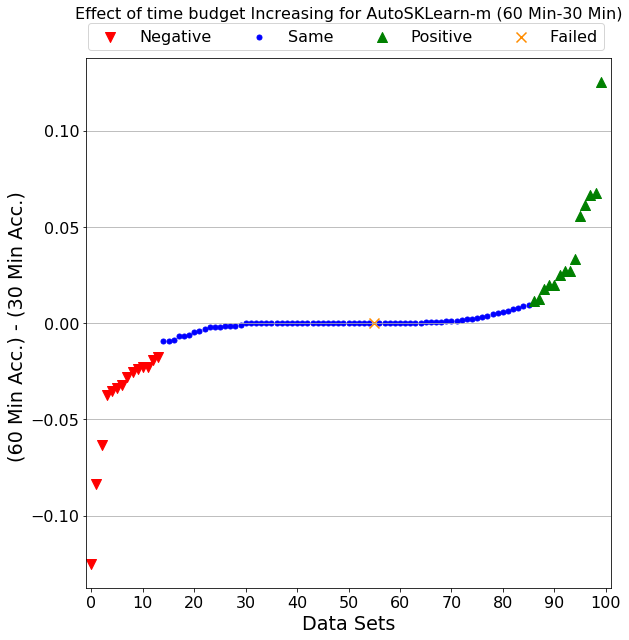

Average loss = -3.1 from 17 datasets
 57 datasets have the same performance
Average gain = 5.1 from 25 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


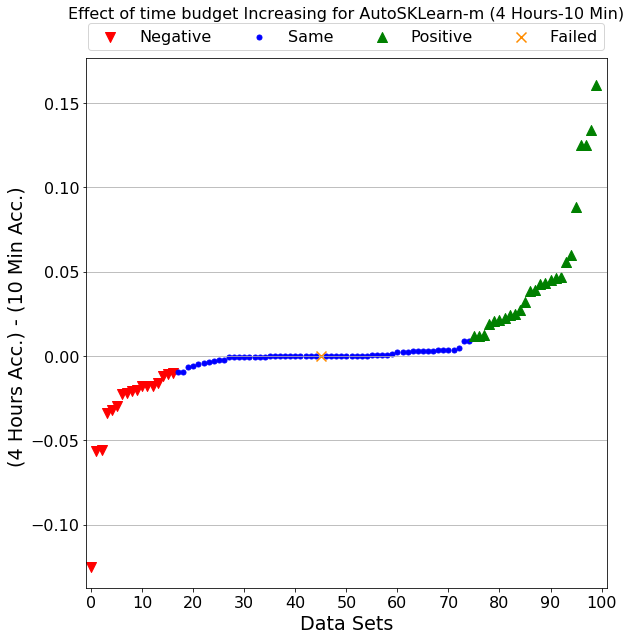

Average loss = -2.9 from 17 datasets
 66 datasets have the same performance
Average gain = 5.5 from 16 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


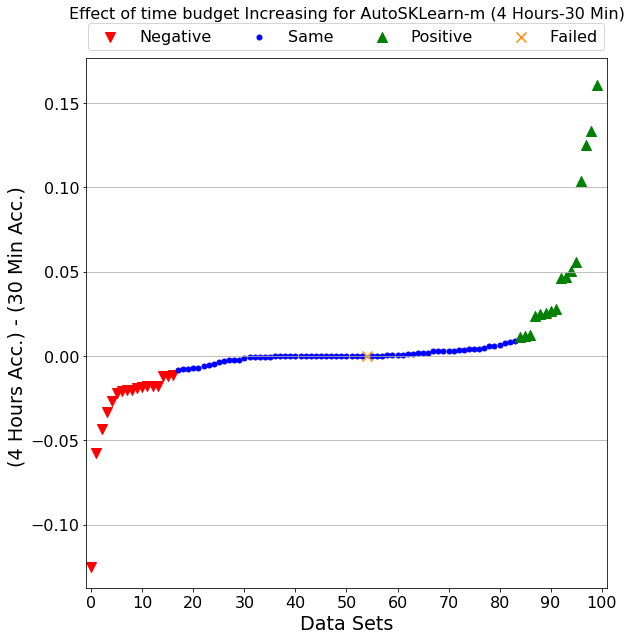

Average loss = -2.7 from 14 datasets
 66 datasets have the same performance
Average gain = 4.1 from 19 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


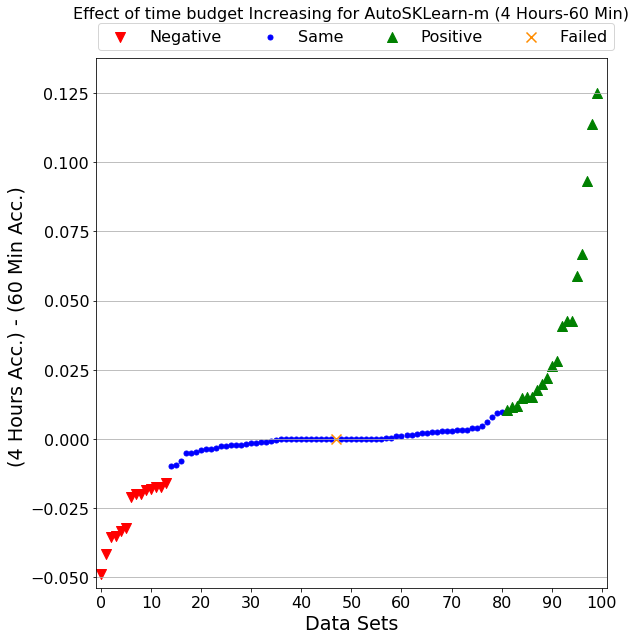

Average loss = -3.8 from 7 datasets
 65 datasets have the same performance
Average gain = 6.1 from 14 datasets
4 datasets succefully run on the right side only
0 datasets succefully run on the left side only
10 datasets succefully do not run on the both sides


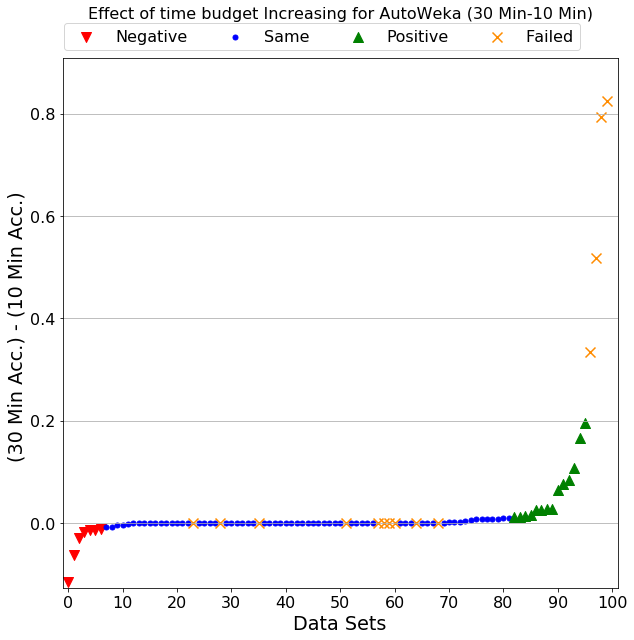

Average loss = -7.9 from 11 datasets
 58 datasets have the same performance
Average gain = 6.3 from 17 datasets
5 datasets succefully run on the right side only
0 datasets succefully run on the left side only
9 datasets succefully do not run on the both sides


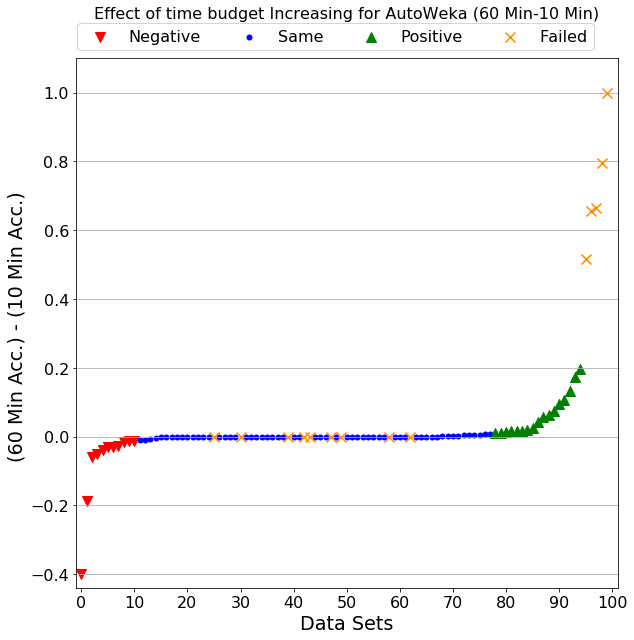

Average loss = -8.1 from 14 datasets
 66 datasets have the same performance
Average gain = 12.4 from 10 datasets
1 datasets succefully run on the right side only
0 datasets succefully run on the left side only
9 datasets succefully do not run on the both sides


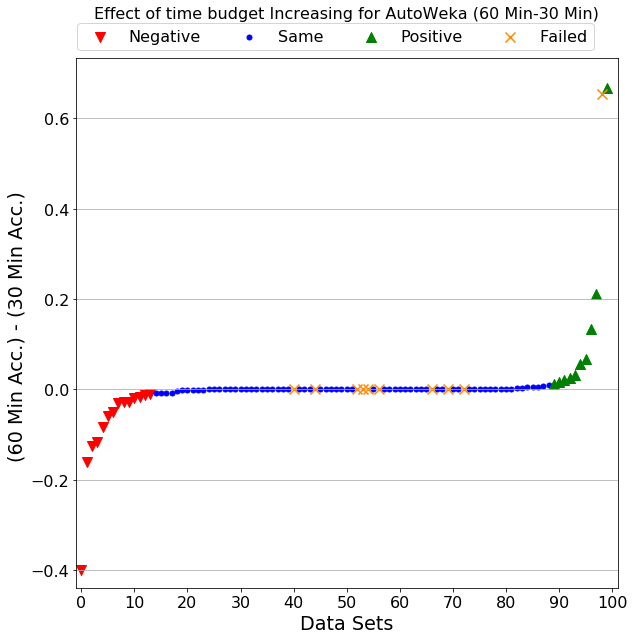

Average loss = -8.7 from 8 datasets
 54 datasets have the same performance
Average gain = 5.8 from 24 datasets
10 datasets succefully run on the right side only
0 datasets succefully run on the left side only
4 datasets succefully do not run on the both sides


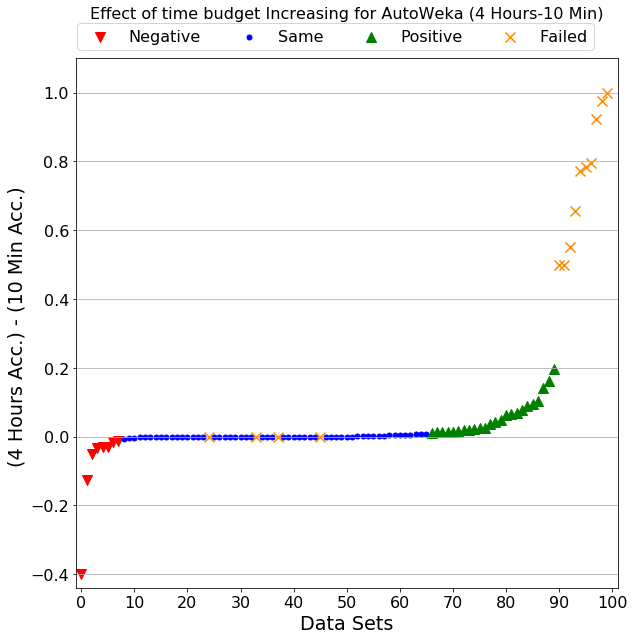

Average loss = -8.4 from 12 datasets
 59 datasets have the same performance
Average gain = 7.9 from 19 datasets
6 datasets succefully run on the right side only
0 datasets succefully run on the left side only
4 datasets succefully do not run on the both sides


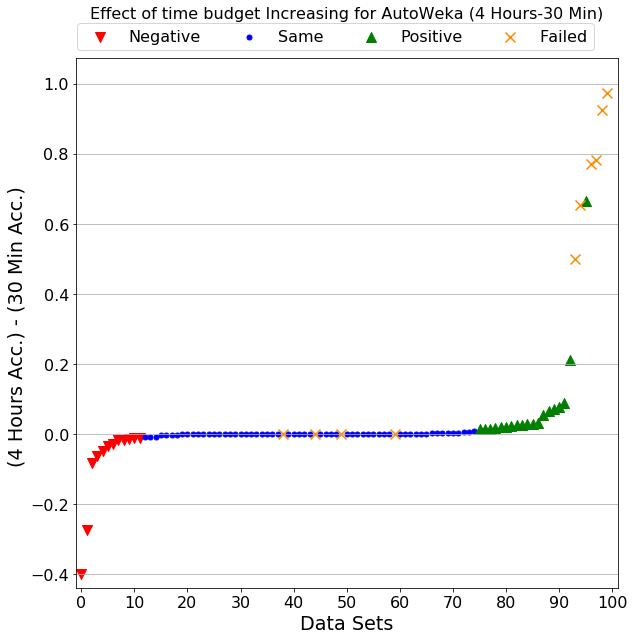

Average loss = -4.4 from 8 datasets
 66 datasets have the same performance
Average gain = 4.3 from 17 datasets
5 datasets succefully run on the right side only
0 datasets succefully run on the left side only
4 datasets succefully do not run on the both sides


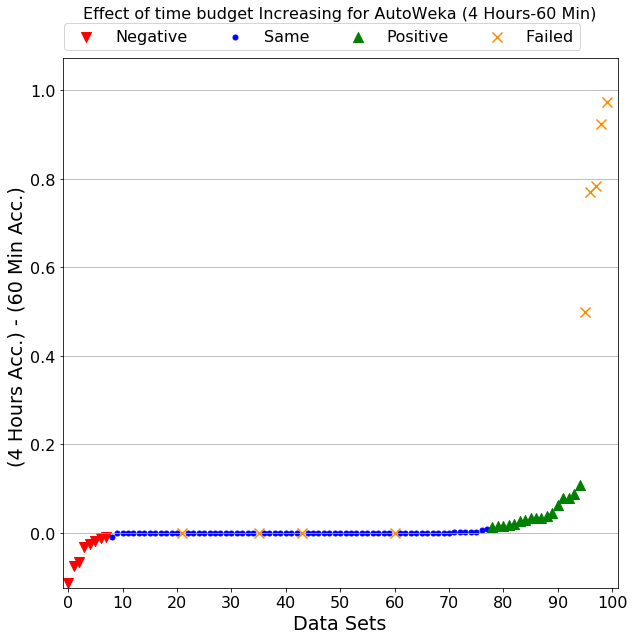

Average loss = -2.0 from 5 datasets
 28 datasets have the same performance
Average gain = 6.3 from 7 datasets
19 datasets succefully run on the right side only
3 datasets succefully run on the left side only
38 datasets succefully do not run on the both sides


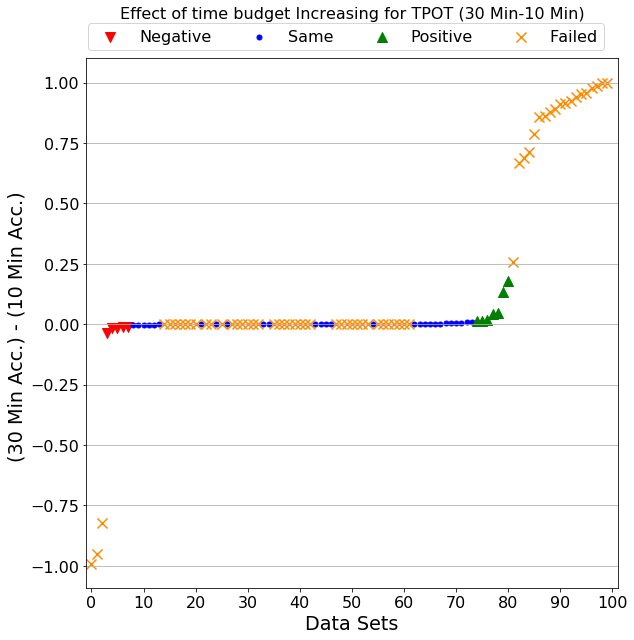

Average loss = -4.1 from 4 datasets
 32 datasets have the same performance
Average gain = 7.1 from 7 datasets
27 datasets succefully run on the right side only
0 datasets succefully run on the left side only
30 datasets succefully do not run on the both sides


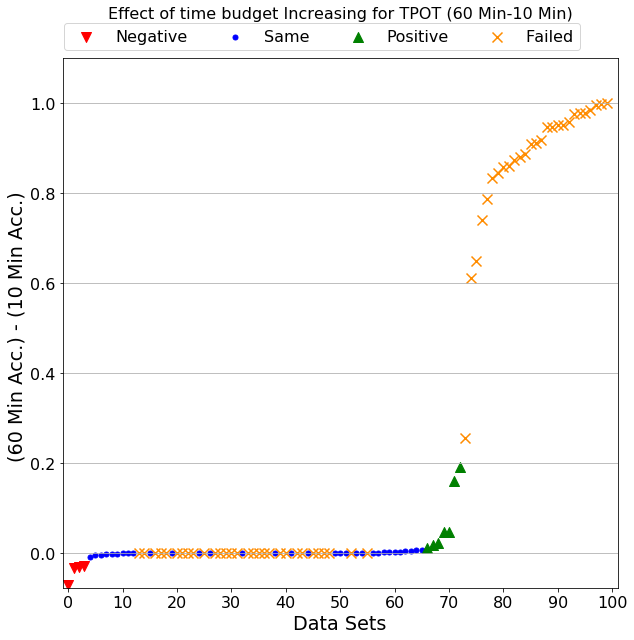

Average loss = -2.9 from 7 datasets
 43 datasets have the same performance
Average gain = 3.7 from 6 datasets
14 datasets succefully run on the right side only
3 datasets succefully run on the left side only
27 datasets succefully do not run on the both sides


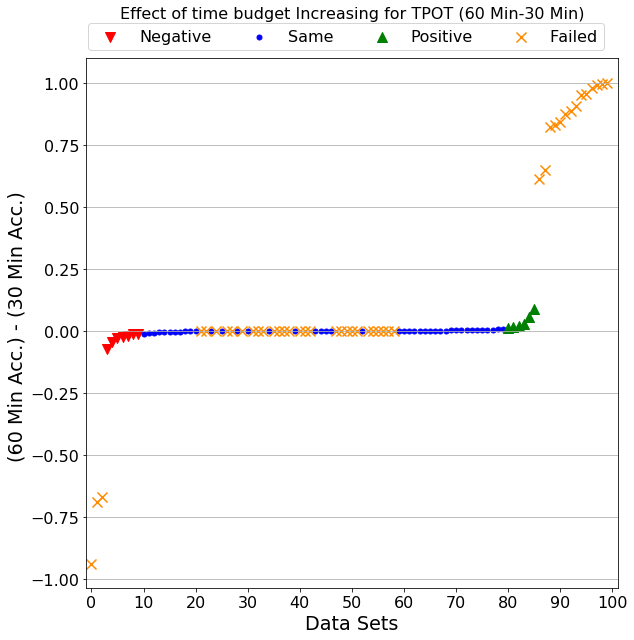

Average loss = -1.9 from 5 datasets
 24 datasets have the same performance
Average gain = 4.6 from 14 datasets
46 datasets succefully run on the right side only
0 datasets succefully run on the left side only
11 datasets succefully do not run on the both sides


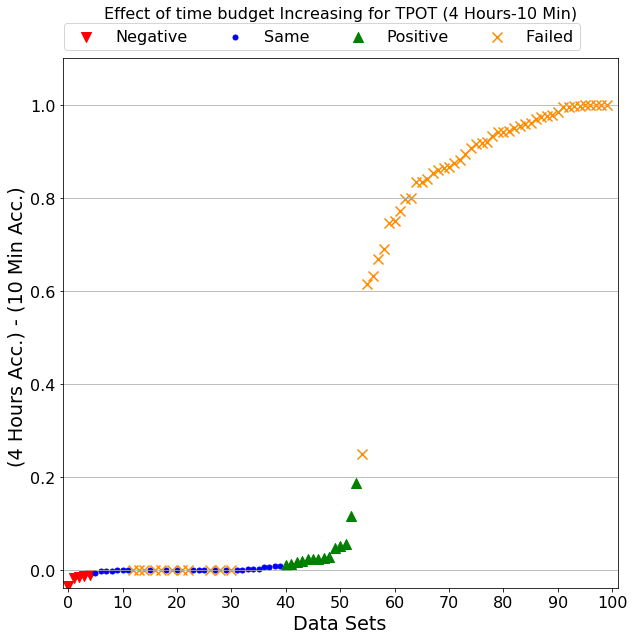

Average loss = -2.3 from 7 datasets
 34 datasets have the same performance
Average gain = 2.8 from 17 datasets
31 datasets succefully run on the right side only
1 datasets succefully run on the left side only
10 datasets succefully do not run on the both sides


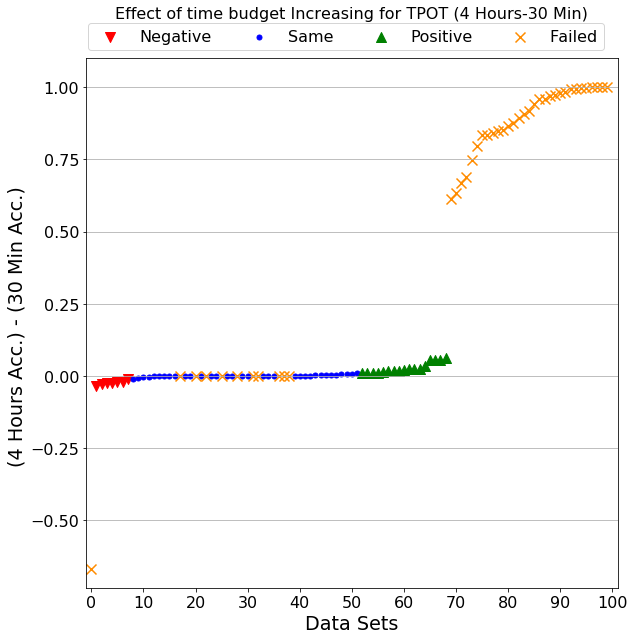

Average loss = -4.1 from 5 datasets
 46 datasets have the same performance
Average gain = 2.5 from 19 datasets
19 datasets succefully run on the right side only
0 datasets succefully run on the left side only
11 datasets succefully do not run on the both sides


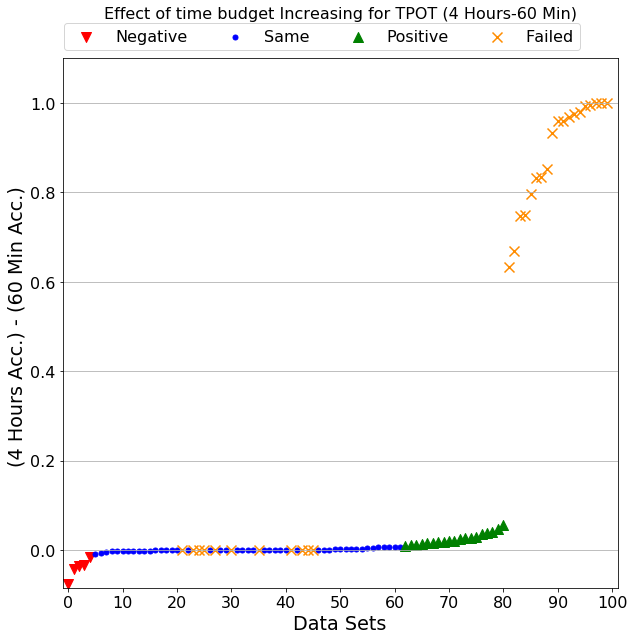

Average loss = -4.1 from 2 datasets
 17 datasets have the same performance
Average gain = 13.6 from 2 datasets
48 datasets succefully run on the right side only
12 datasets succefully run on the left side only
19 datasets succefully do not run on the both sides


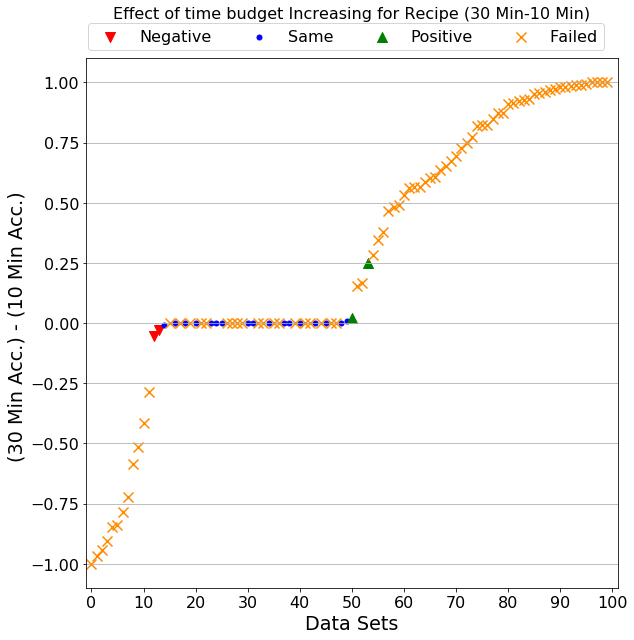

Average loss = -8.8 from 5 datasets
 16 datasets have the same performance
Average gain = 9.2 from 5 datasets
50 datasets succefully run on the right side only
7 datasets succefully run on the left side only
17 datasets succefully do not run on the both sides


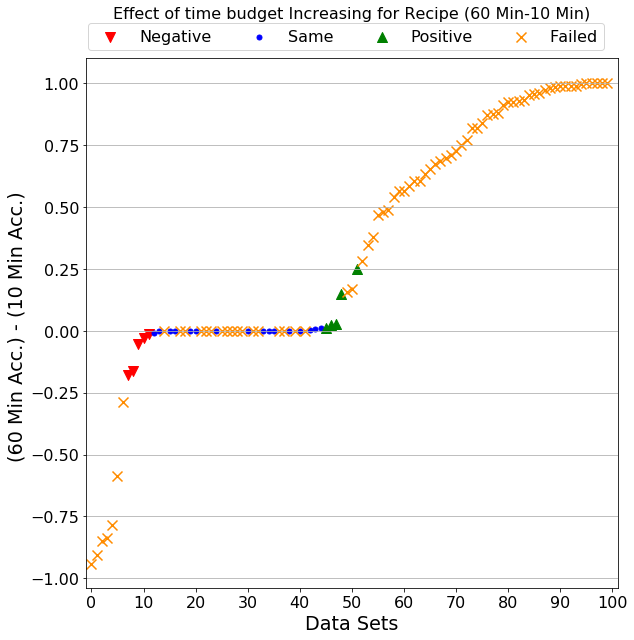

Average loss = -12.5 from 3 datasets
 59 datasets have the same performance
Average gain = 4.3 from 5 datasets
9 datasets succefully run on the right side only
2 datasets succefully run on the left side only
22 datasets succefully do not run on the both sides


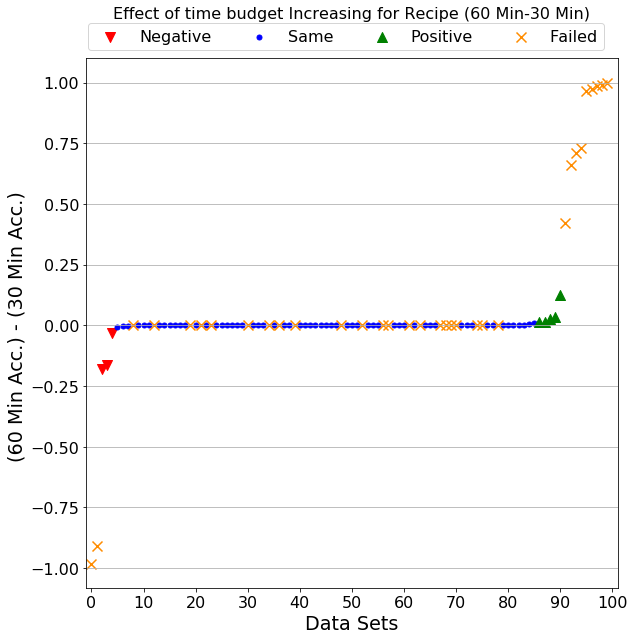

Average loss = -6.5 from 4 datasets
 18 datasets have the same performance
Average gain = 10.0 from 10 datasets
53 datasets succefully run on the right side only
1 datasets succefully run on the left side only
14 datasets succefully do not run on the both sides


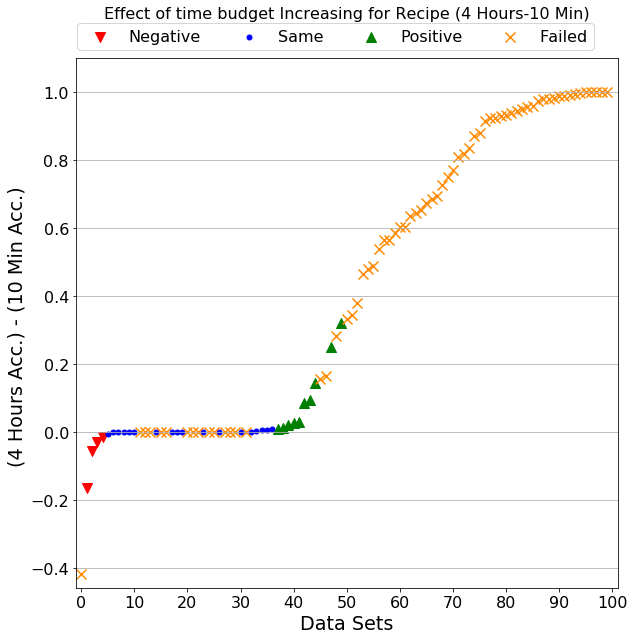

Average loss = -7.1 from 3 datasets
 57 datasets have the same performance
Average gain = 4.5 from 9 datasets
16 datasets succefully run on the right side only
0 datasets succefully run on the left side only
15 datasets succefully do not run on the both sides


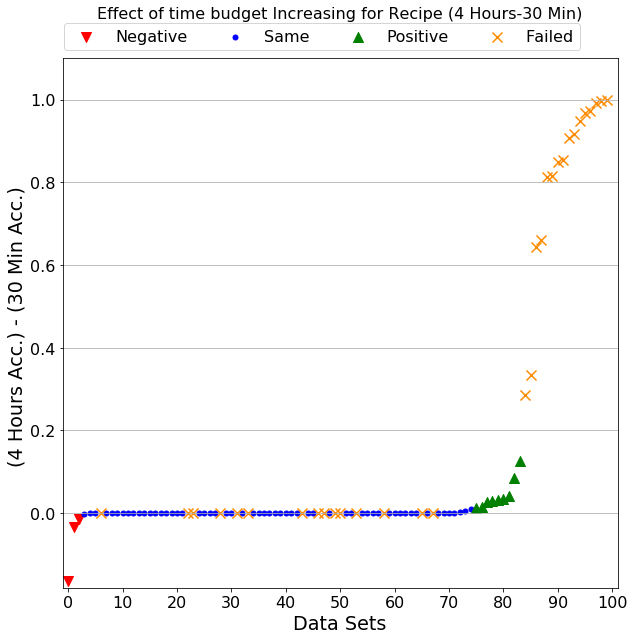

Average loss = -37.5 from 1 datasets
 70 datasets have the same performance
Average gain = 10.5 from 4 datasets
10 datasets succefully run on the right side only
1 datasets succefully run on the left side only
14 datasets succefully do not run on the both sides


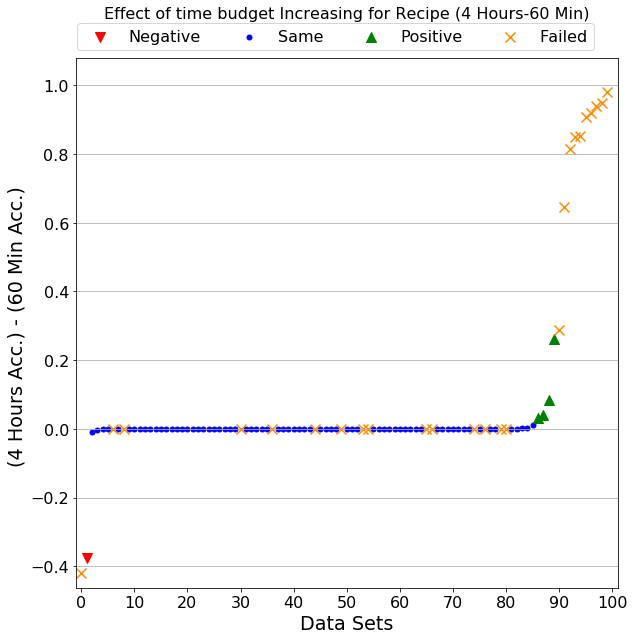

Average loss = -3.6 from 11 datasets
 64 datasets have the same performance
Average gain = 8.0 from 13 datasets
2 datasets succefully run on the right side only
1 datasets succefully run on the left side only
9 datasets succefully do not run on the both sides


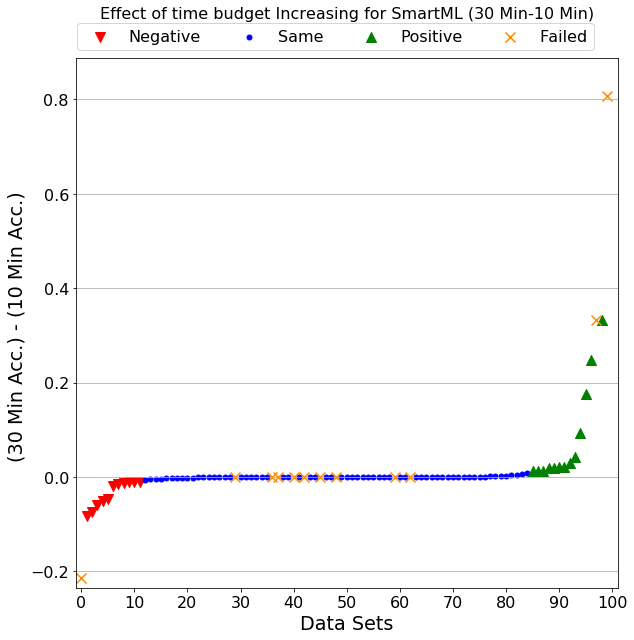

Average loss = -3.3 from 12 datasets
 64 datasets have the same performance
Average gain = 10.8 from 11 datasets
2 datasets succefully run on the right side only
2 datasets succefully run on the left side only
9 datasets succefully do not run on the both sides


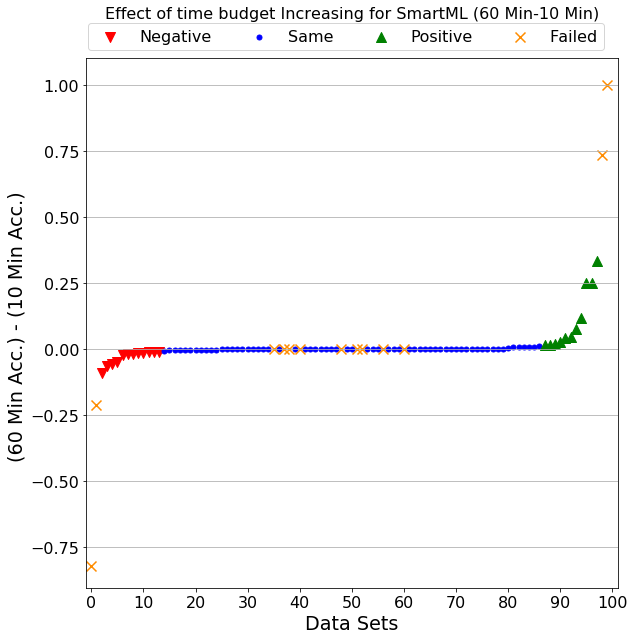

Average loss = -6.2 from 6 datasets
 73 datasets have the same performance
Average gain = 12.2 from 10 datasets
0 datasets succefully run on the right side only
1 datasets succefully run on the left side only
10 datasets succefully do not run on the both sides


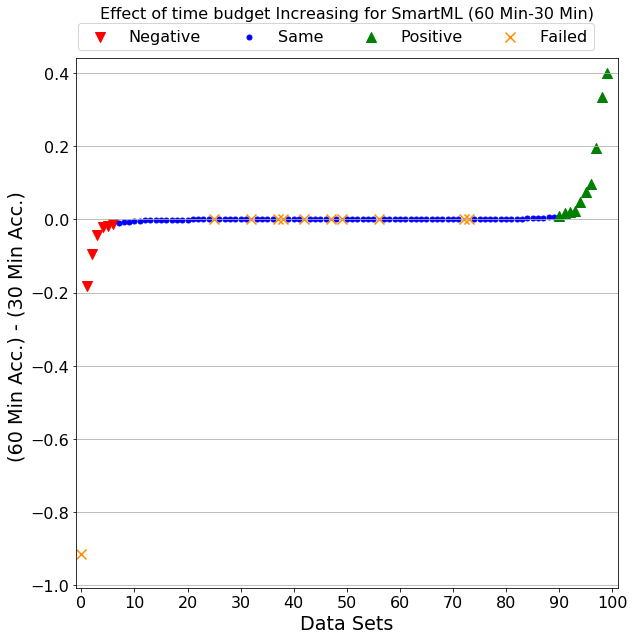

Average loss = -4.1 from 9 datasets
 58 datasets have the same performance
Average gain = 13.5 from 20 datasets
2 datasets succefully run on the right side only
2 datasets succefully run on the left side only
9 datasets succefully do not run on the both sides


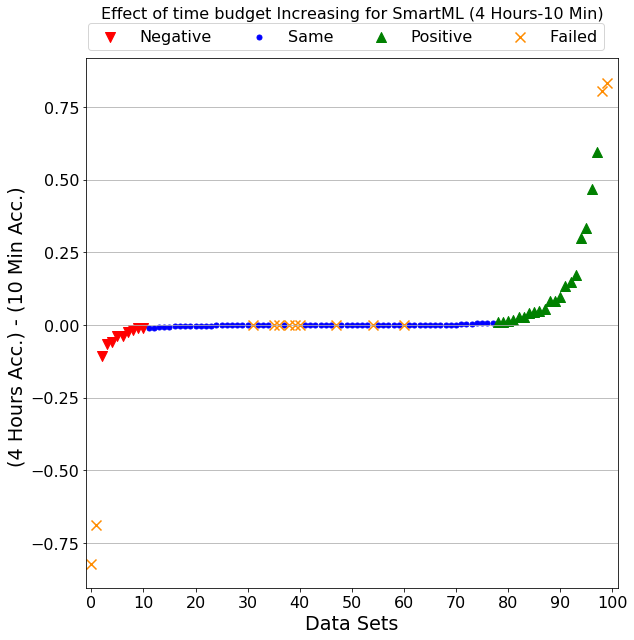

Average loss = -6.8 from 7 datasets
 61 datasets have the same performance
Average gain = 13.4 from 20 datasets
1 datasets succefully run on the right side only
2 datasets succefully run on the left side only
9 datasets succefully do not run on the both sides


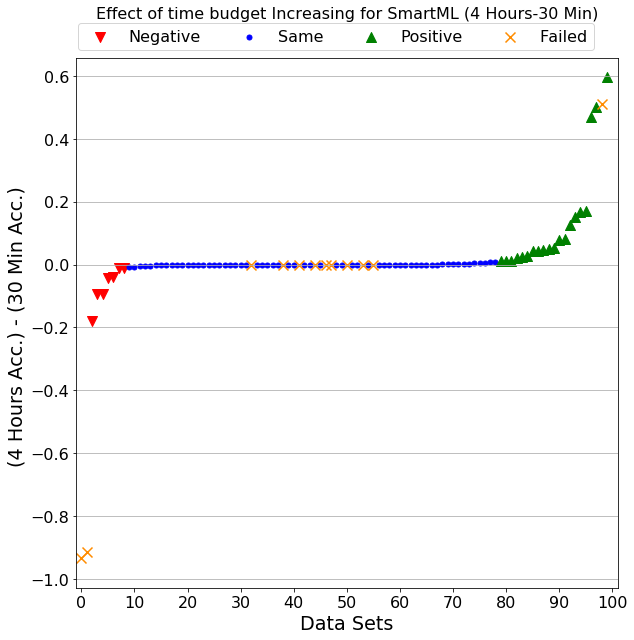

Average loss = -6.6 from 10 datasets
 59 datasets have the same performance
Average gain = 10.6 from 19 datasets
1 datasets succefully run on the right side only
1 datasets succefully run on the left side only
10 datasets succefully do not run on the both sides


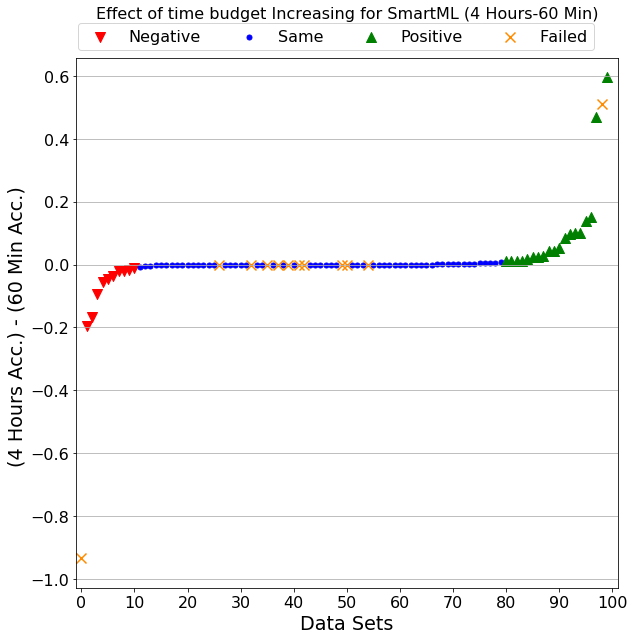

Average loss = -4.7 from 13 datasets
 33 datasets have the same performance
Average gain = 4.2 from 21 datasets
7 datasets succefully run on the right side only
8 datasets succefully run on the left side only
18 datasets succefully do not run on the both sides


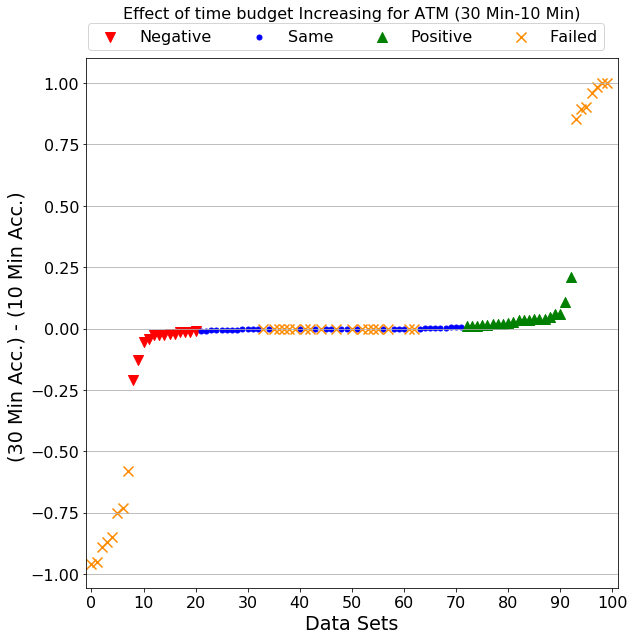

Average loss = -6.2 from 19 datasets
 34 datasets have the same performance
Average gain = 5.4 from 18 datasets
8 datasets succefully run on the right side only
4 datasets succefully run on the left side only
17 datasets succefully do not run on the both sides


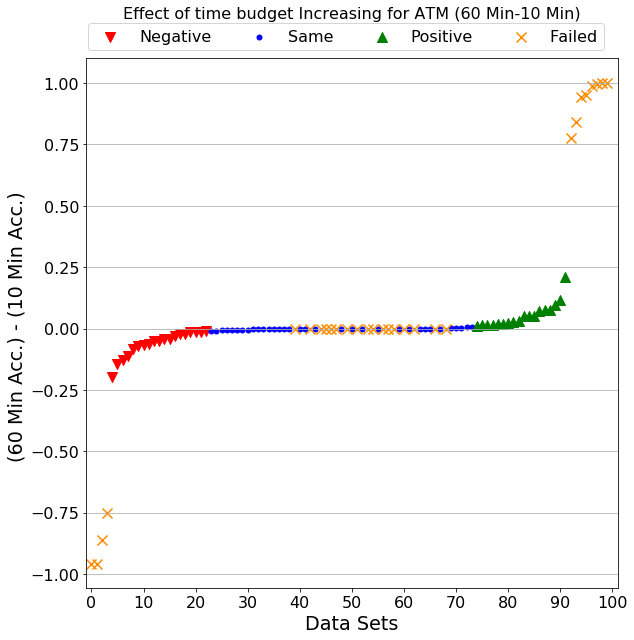

Average loss = -6.6 from 19 datasets
 35 datasets have the same performance
Average gain = 4.5 from 15 datasets
10 datasets succefully run on the right side only
5 datasets succefully run on the left side only
16 datasets succefully do not run on the both sides


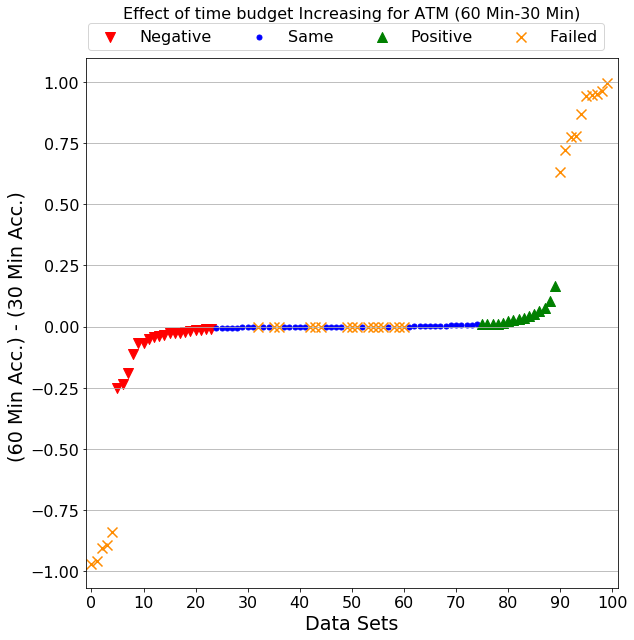

Average loss = -4.3 from 18 datasets
 34 datasets have the same performance
Average gain = 4.9 from 21 datasets
13 datasets succefully run on the right side only
2 datasets succefully run on the left side only
12 datasets succefully do not run on the both sides


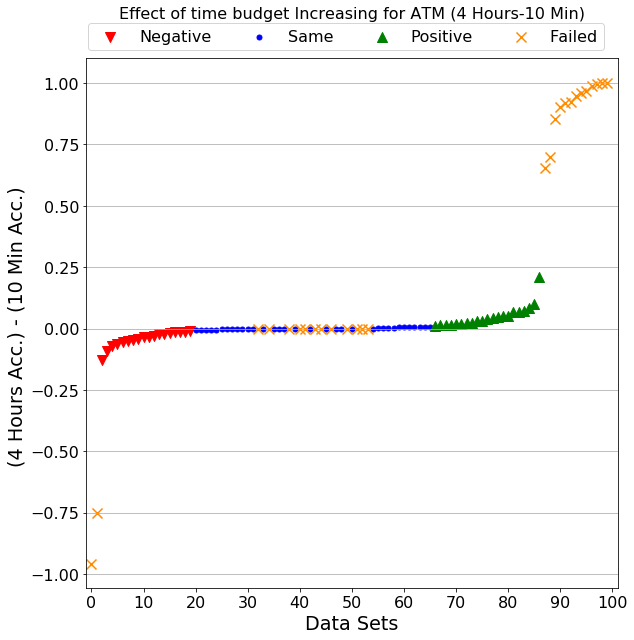

Average loss = -4.6 from 17 datasets
 40 datasets have the same performance
Average gain = 3.3 from 16 datasets
13 datasets succefully run on the right side only
1 datasets succefully run on the left side only
13 datasets succefully do not run on the both sides


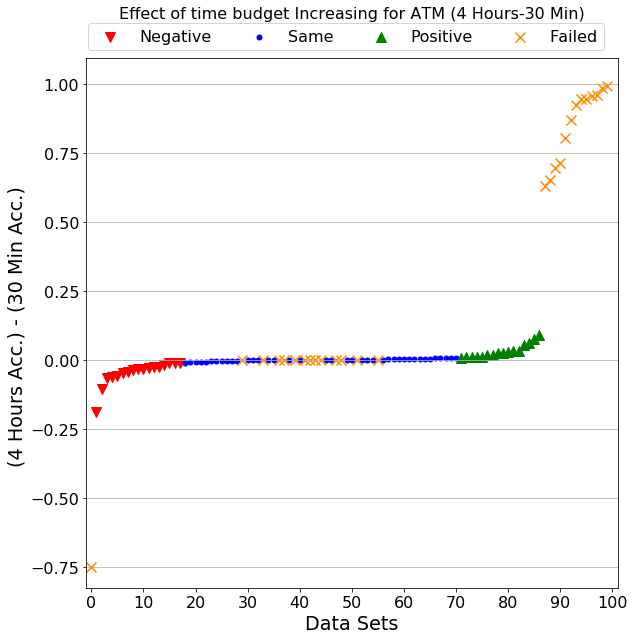

Average loss = -4.0 from 16 datasets
 41 datasets have the same performance
Average gain = 5.3 from 20 datasets
9 datasets succefully run on the right side only
2 datasets succefully run on the left side only
12 datasets succefully do not run on the both sides


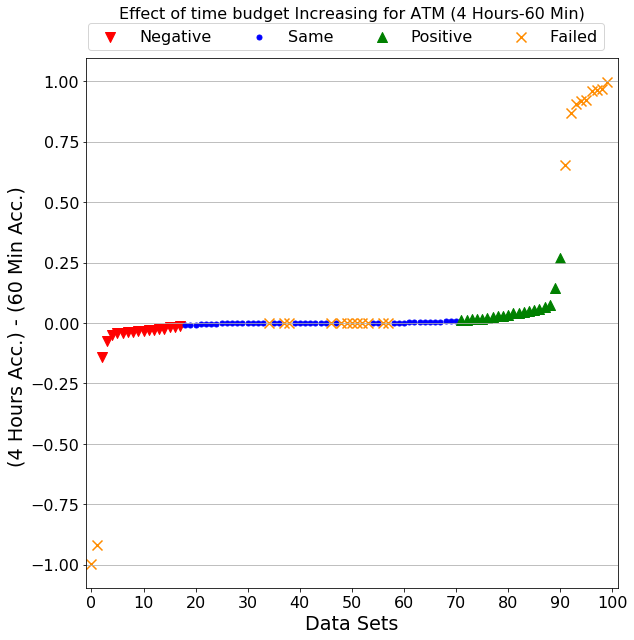

In [29]:
x_label = 'Data Sets'
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m', 'AutoWeka', 'TPOT', 'Recipe', 'SmartML', 'ATM']
acc = ['sklearn_accuracy_mean', 'sklearn_v_accuracy_mean', 'sklearn_e_accuracy_mean', 'sklearn_m_accuracy_mean',
            'autoweka_accuracy_mean', 'tpot_accuracy_mean', 'recipe_test_acc', 'smartml_valid_acc', 'atm_acc']
t =  ['10 Min', '30 Min', '60 Min', '4 Hours']
for tool, acc in zip(tools,acc):
    for i in range(1, len(t)):
        for j in range(i):
            fig = Figure()
            first = fig.get_sheet()[t[i]].loc[:, acc]
            second = fig.get_sheet()[t[j]].loc[:, acc]
            y_lable = '(' + t[i] + ' Acc.) - (' + t[j] + ' Acc.) '
            title = 'Effect of time budget Increasing for '+ tool + ' ('+ t[i] +'-'+t[j]+ ')'
            fig.compare_acc_scatter(first, second, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=None)

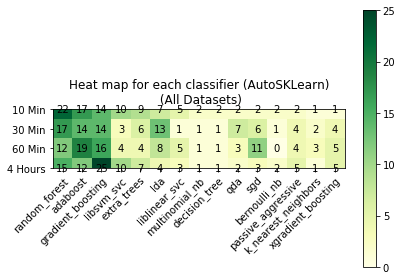

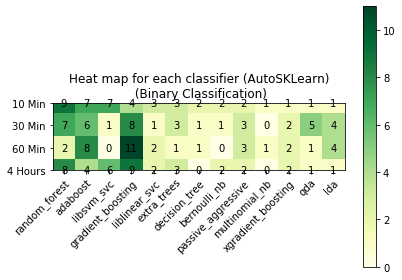

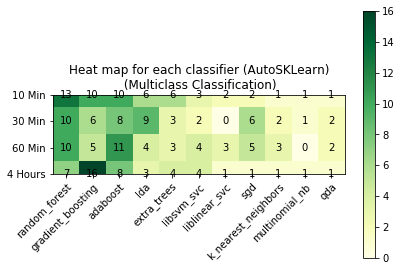

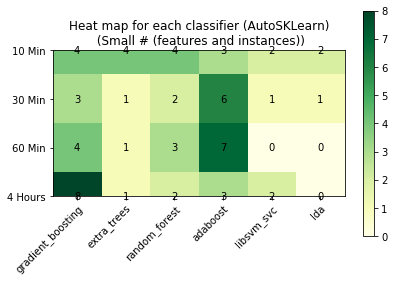

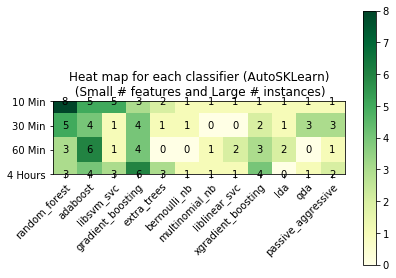

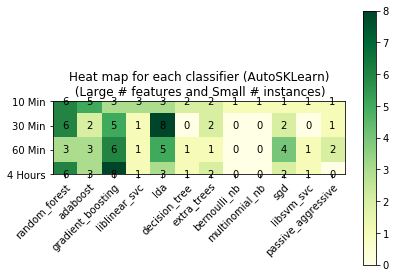

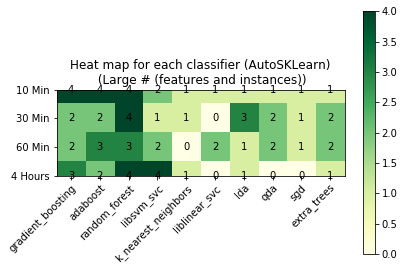

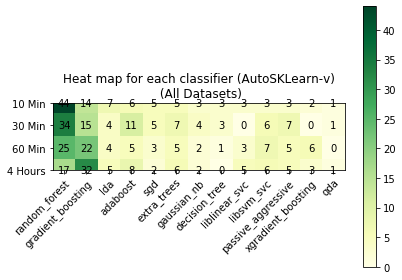

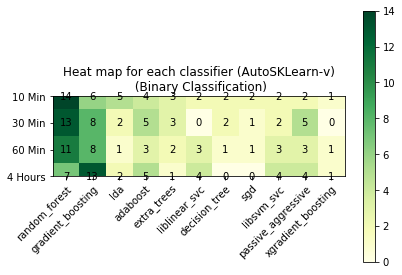

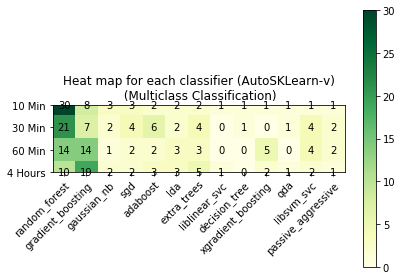

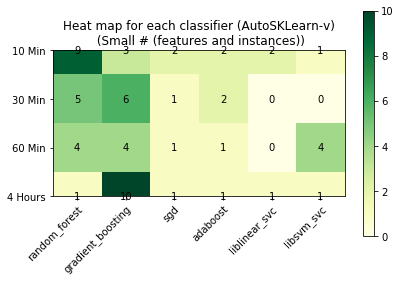

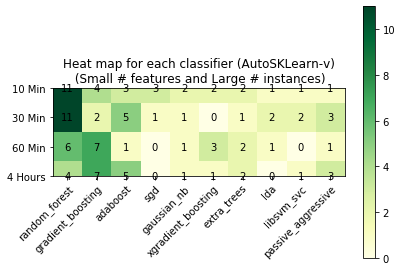

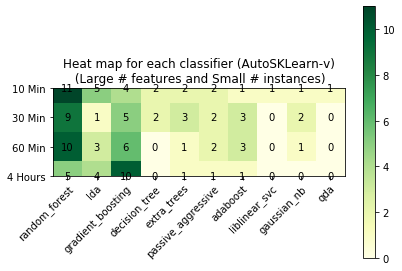

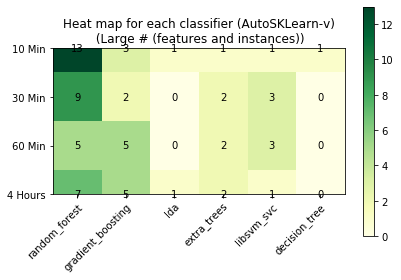

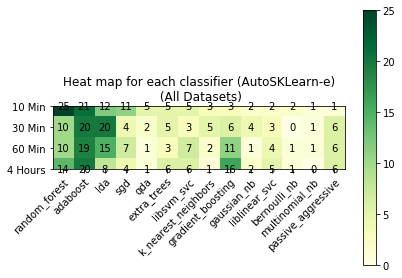

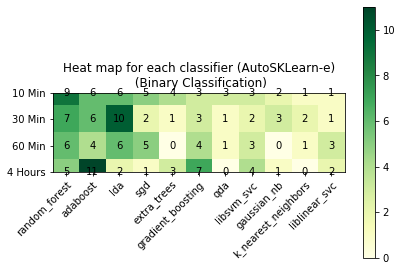

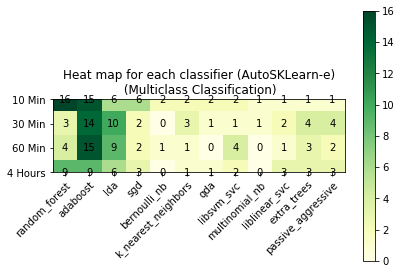

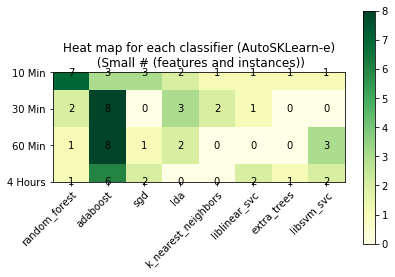

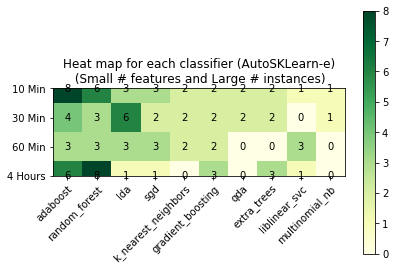

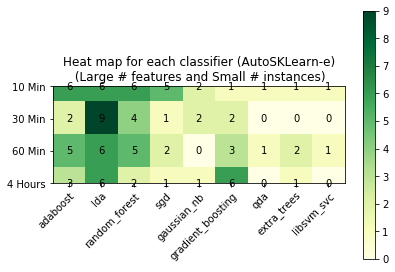

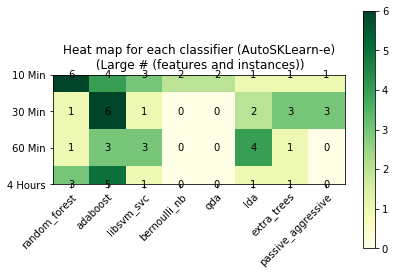

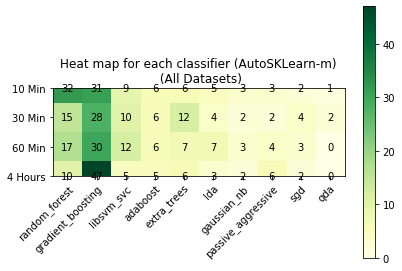

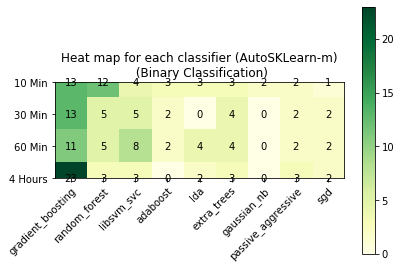

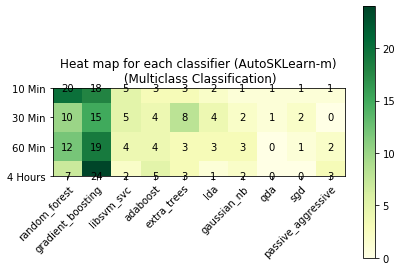

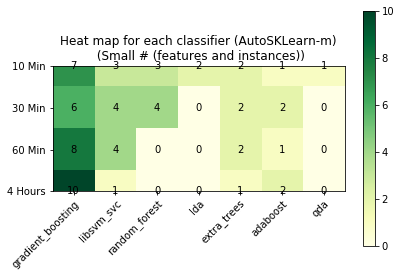

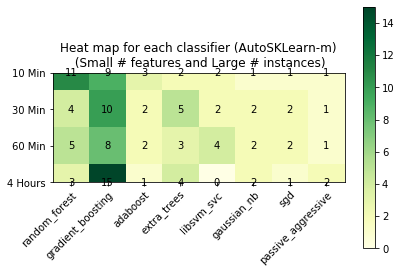

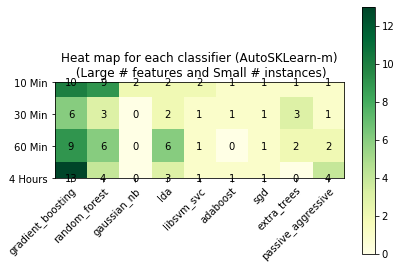

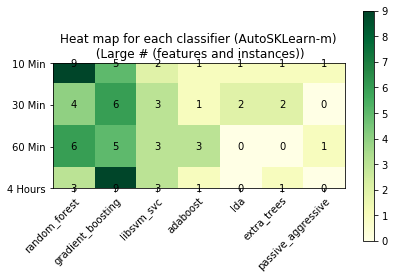

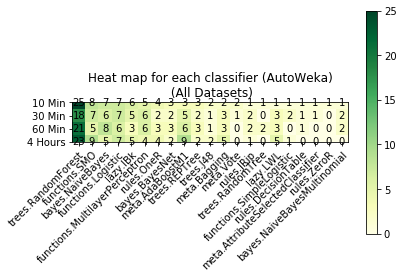

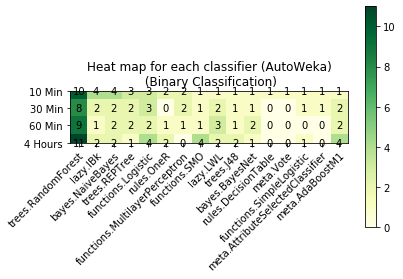

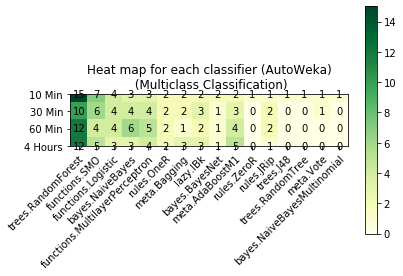

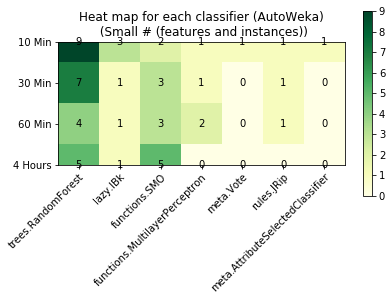

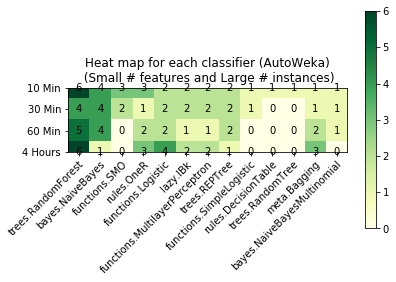

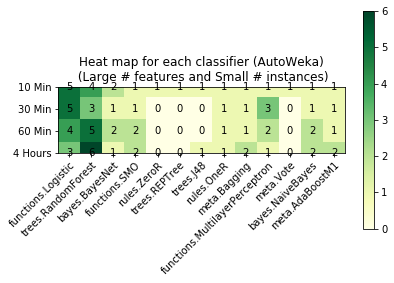

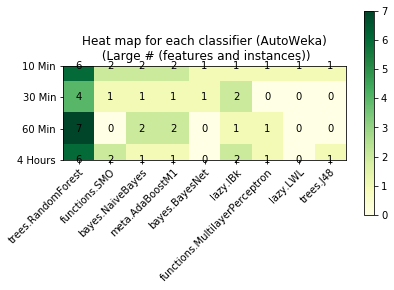

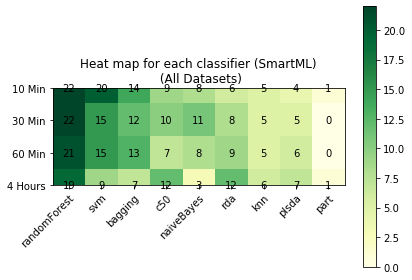

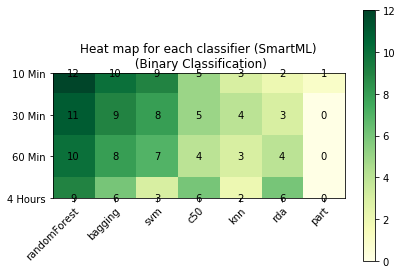

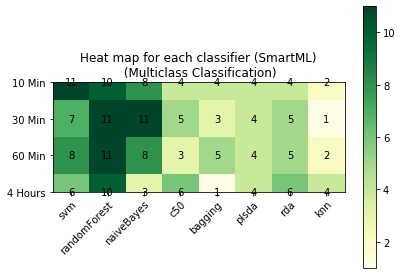

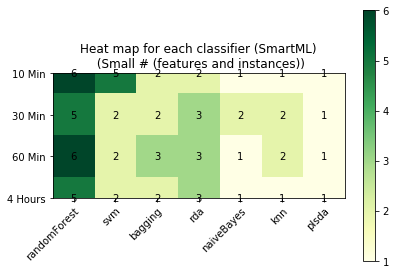

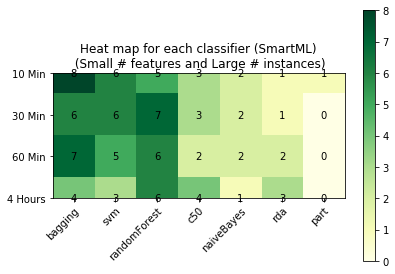

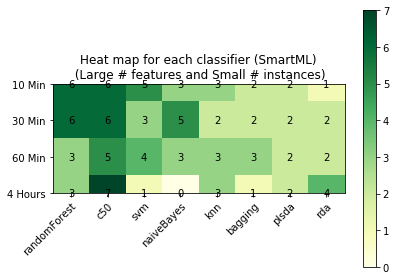

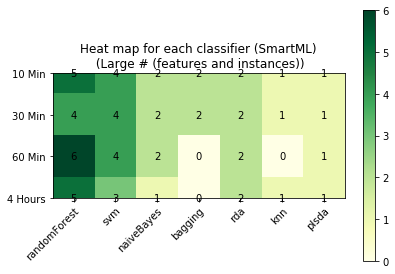

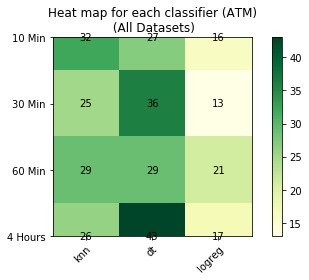

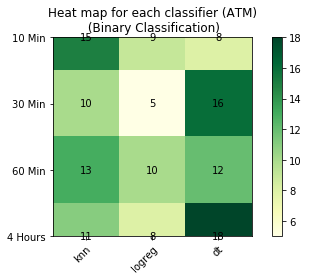

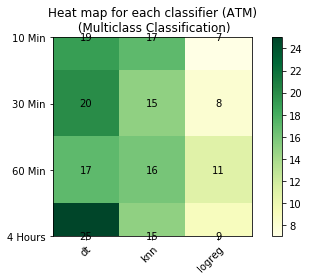

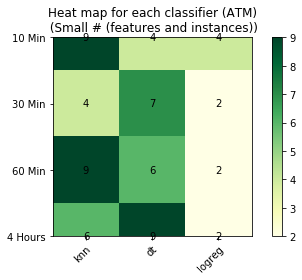

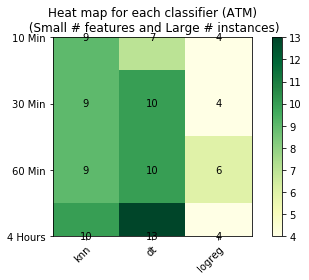

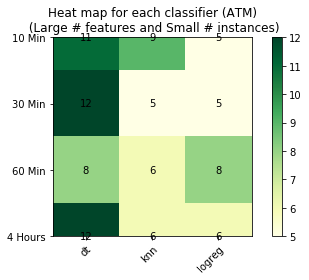

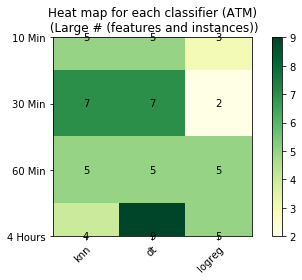

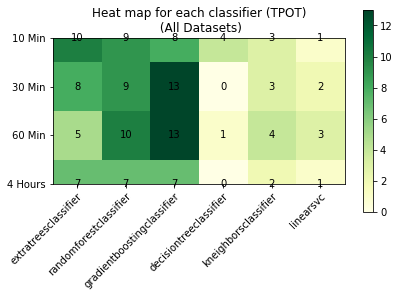

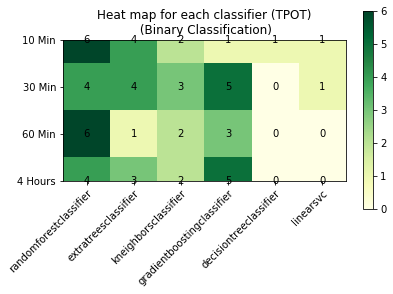

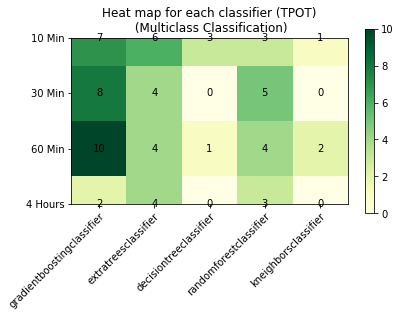

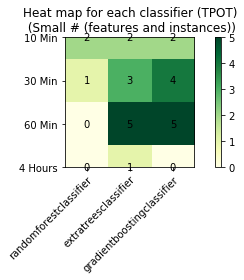

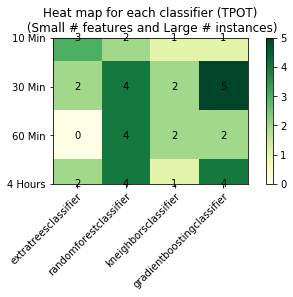

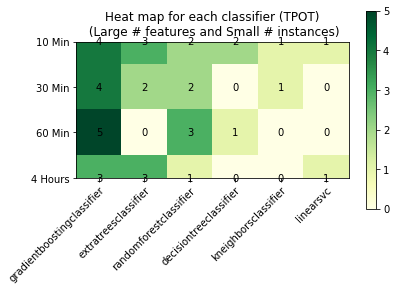

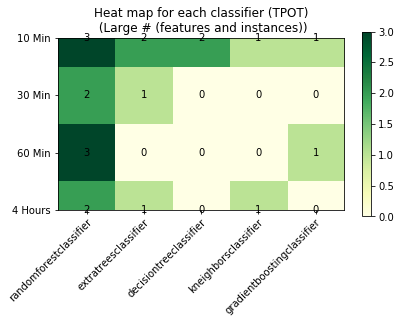

In [30]:
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m', 'AutoWeka', 'SmartML', 'ATM', 'TPOT']
models = ['sklearn_model_1', 'sklearn_v_model_1', 'sklearn_e_model_1', 'sklearn_m_model_1',
            'autoweka_model_1', 'smartml_model', 'ATM_classifier', 'tpot_classifier']
for tool, model in zip(tools,models):
    fig = Figure()
    fig.draw_heat_map(model, tool, divide_data=True)

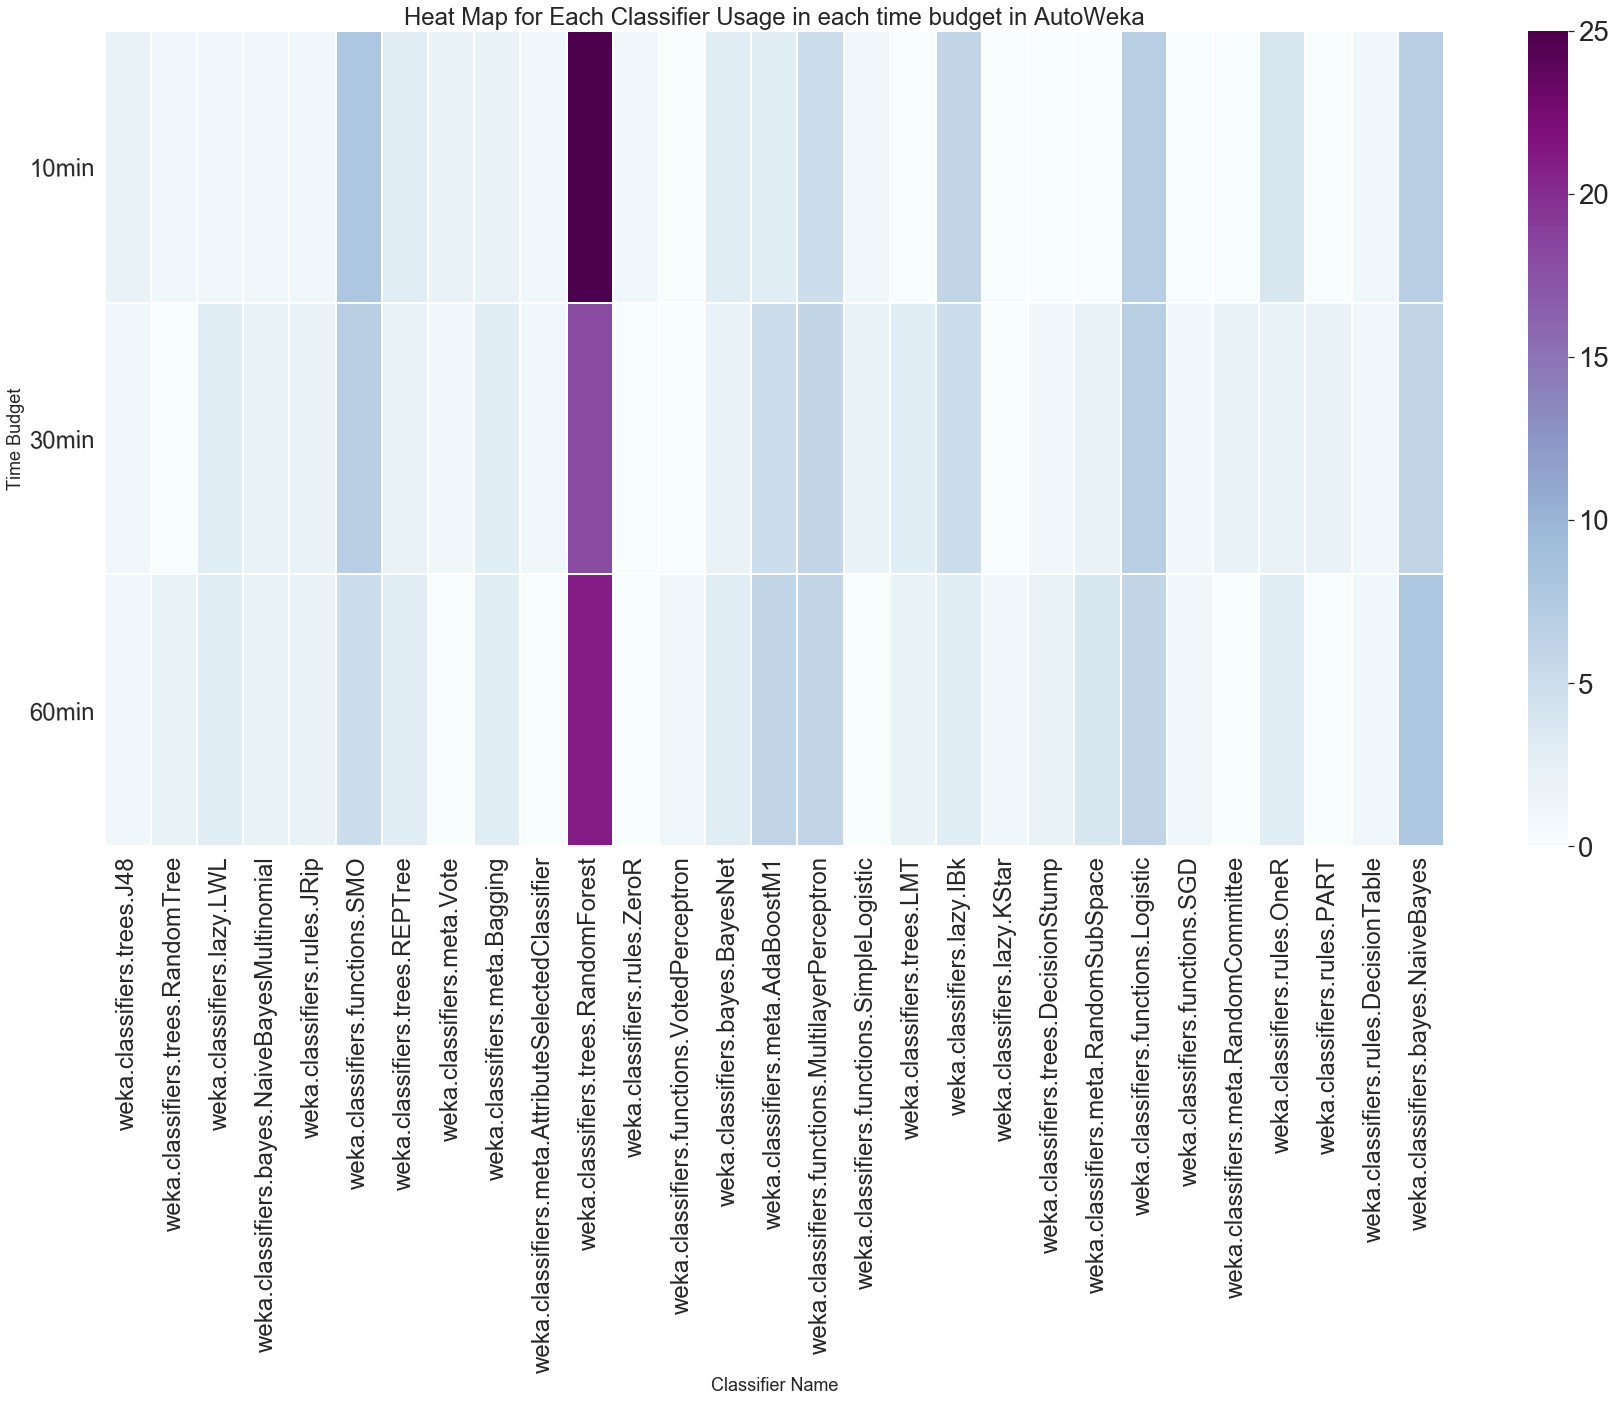

In [31]:
#### Most frequesnt classifiers chosen by AutoWeka
Image('weka_most.png')

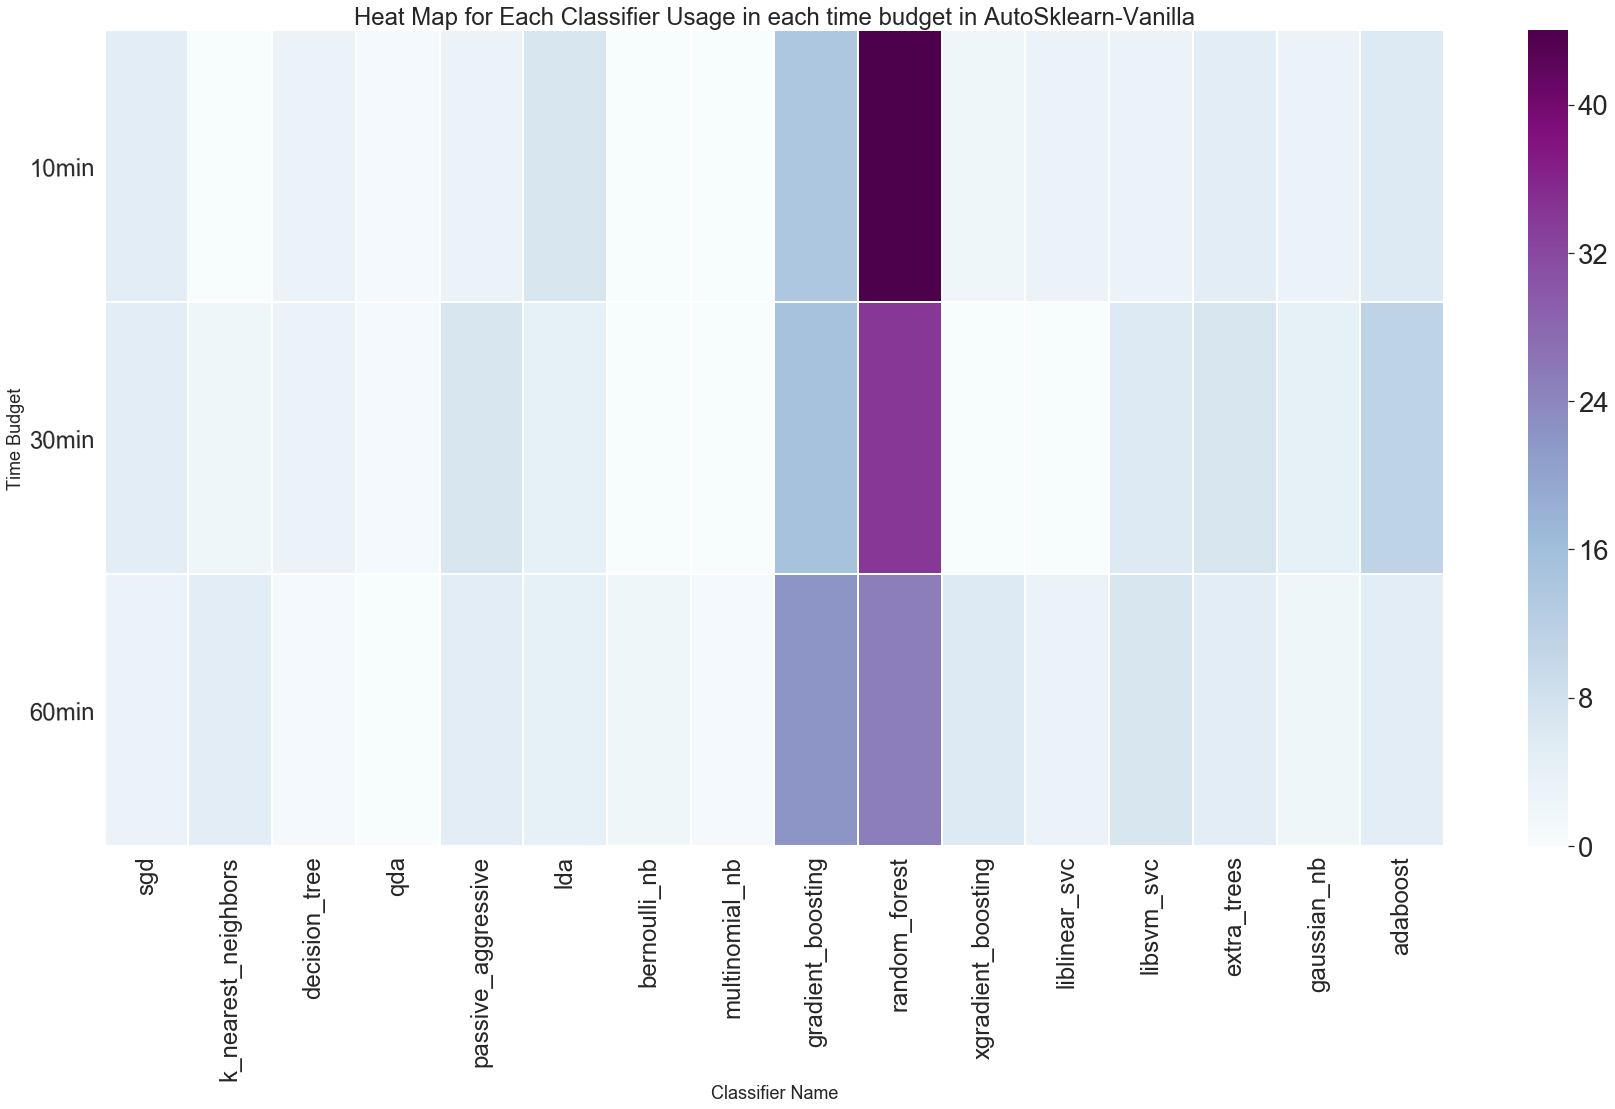

In [32]:
#### Most frequesnt classifiers chosen by AutoSklearn
Image('sklearn_most.png')

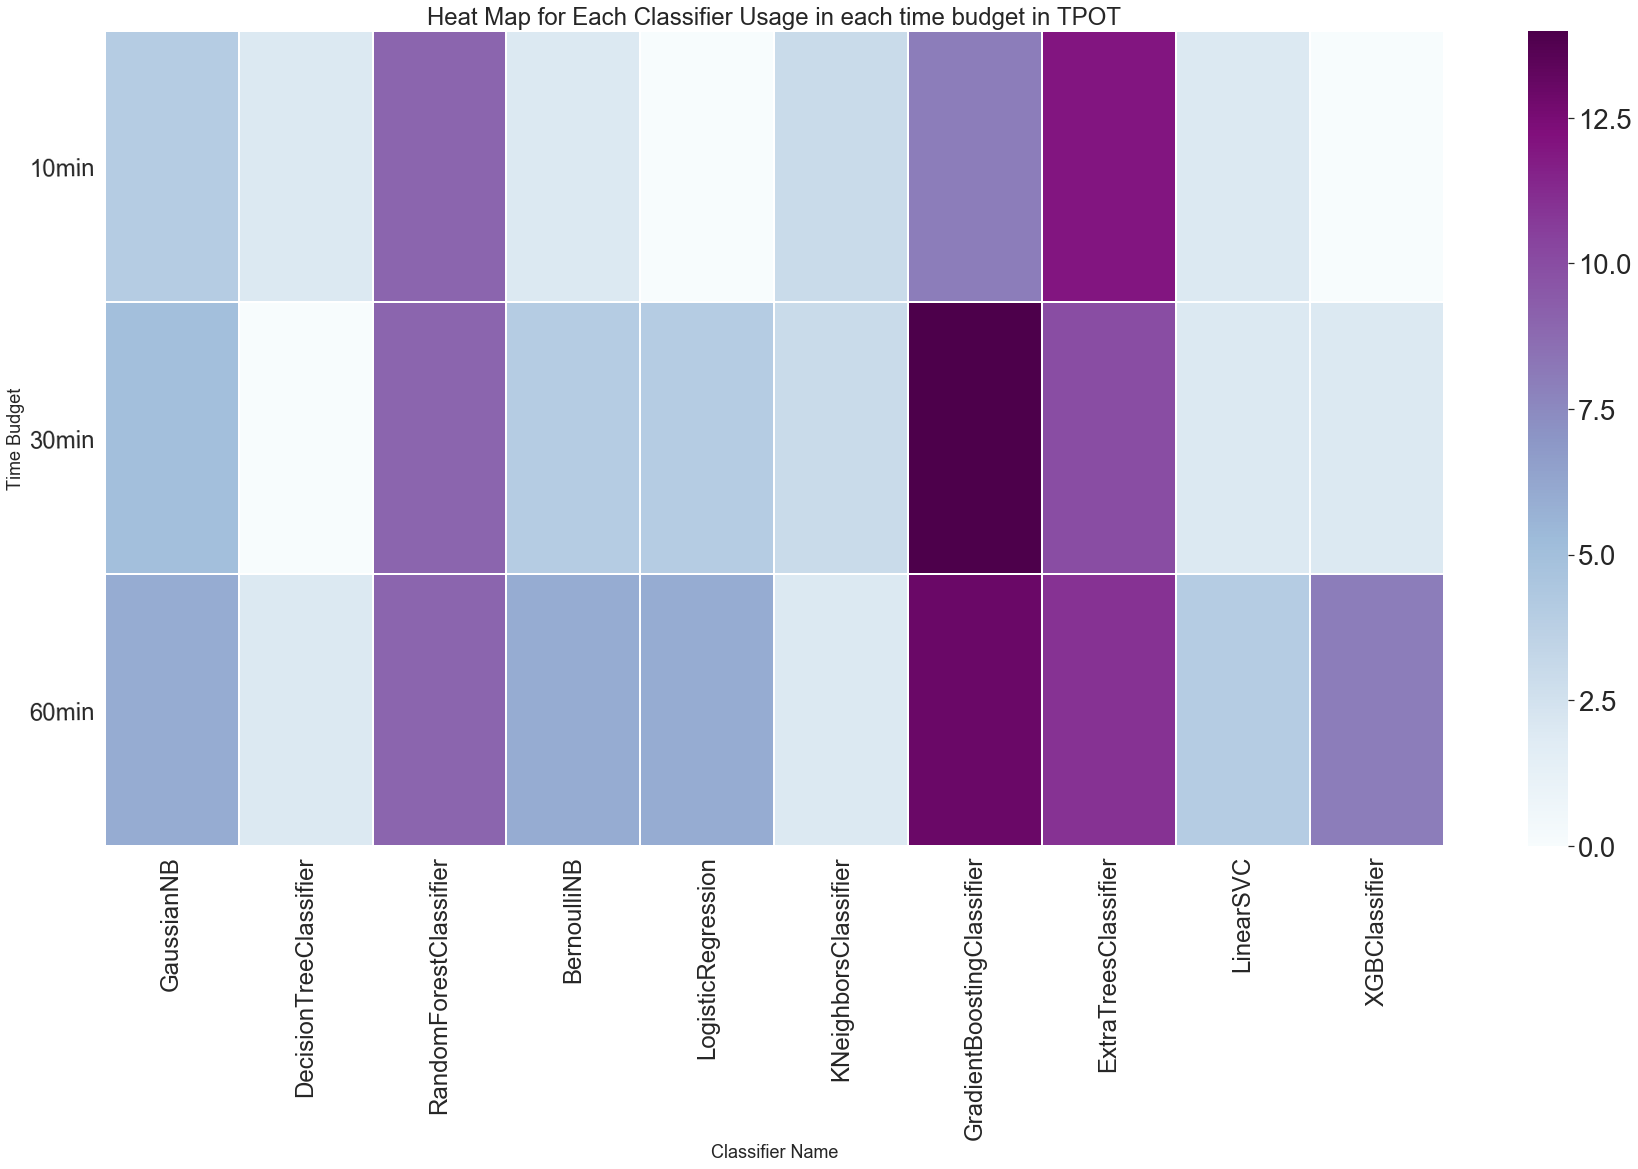

In [33]:
#### Most frequesnt classifiers chosen by TPOT
Image('tpot.png')

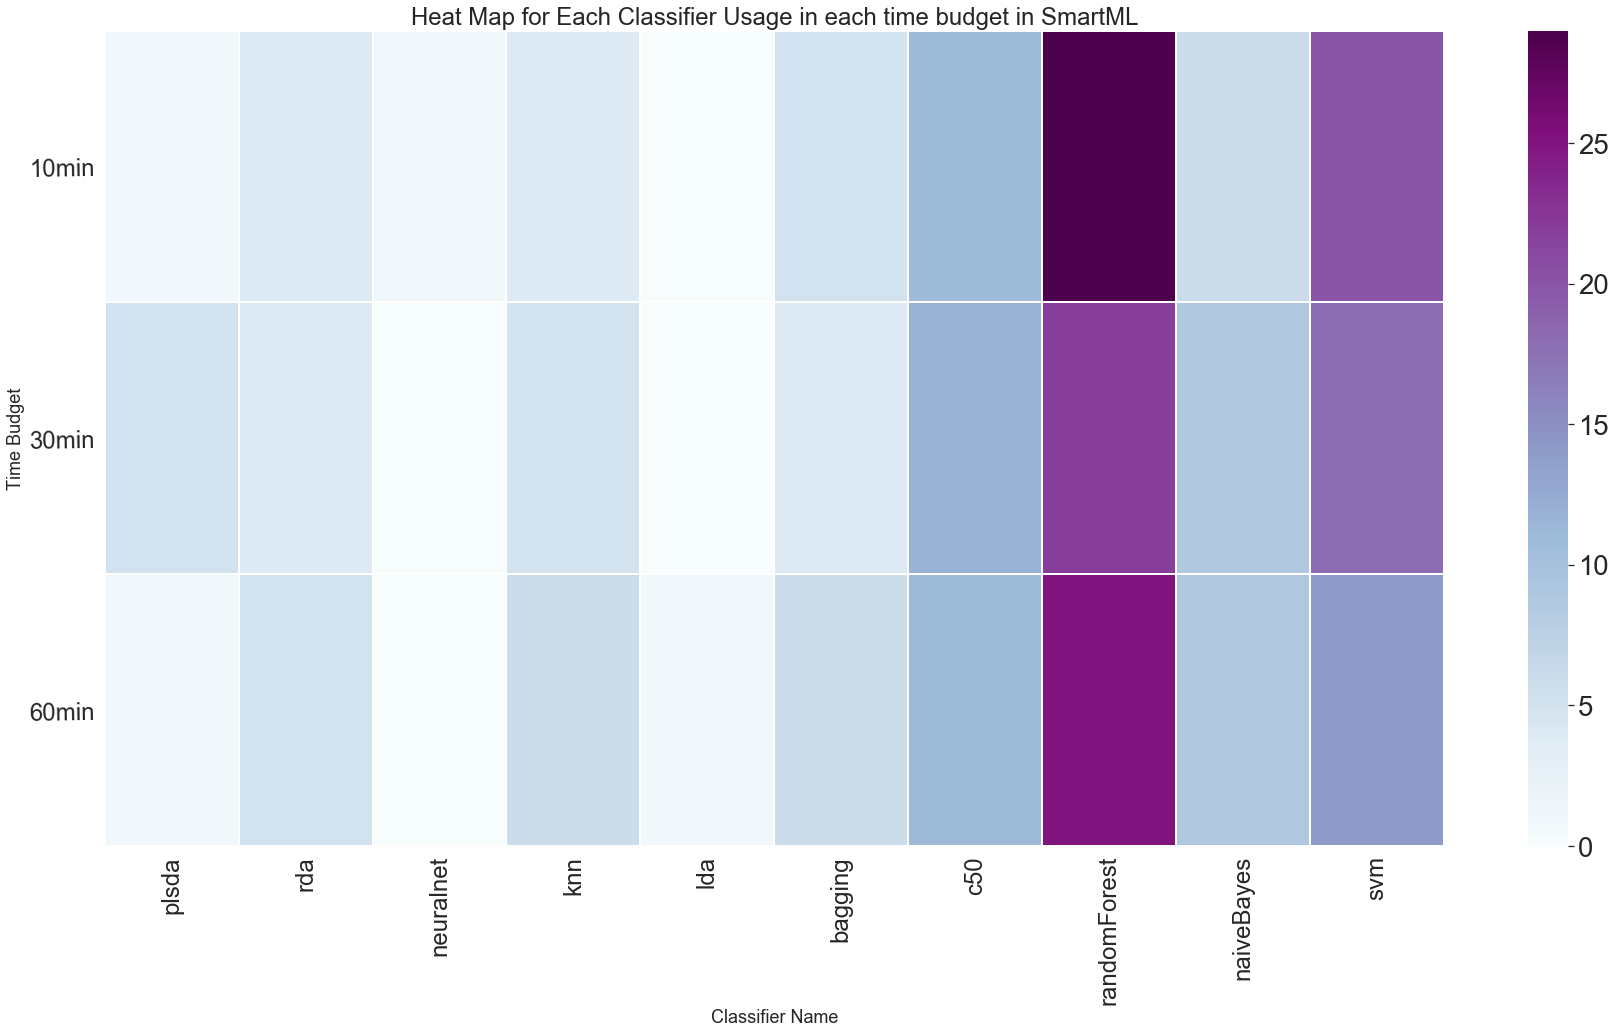

In [34]:
#### Most frequesnt classifiers chosen by SmartML
Image('smartml.png')

#  Output pipelines for datasets where TPOT outperform AutoSklearn

************ CHURN DATASET ************ <br>
<b>TPOT:</b> <br>
Pipeline(memory=None,steps=[('extratreesclassifier')]) <br><br>

<b>AutoSklearn:</b><br>
{'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'one_hot_encoding',  <br>
'classifier:__choice__': 'random_forest',  <br>
'imputation:strategy': 'mean', <br>
'preprocessor:__choice__': 'no_preprocessing', <br>
'rescaling:__choice__': 'standardize', <br>
'categorical_encoding:one_hot_encoding}<br><br><br>

<hr>

************ Adult DATASET ************ <br>
<b>TPOT: </b> <br>
Pipeline(memory=None, steps=[('gradientboostingclassifier')]) <br><br>

<b>AutoSklearn:</b> <br>
{'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'one_hot_encoding', <br>
'classifier:__choice__': 'random_forest', <br>
'imputation:strategy': 'median', <br>
'preprocessor:__choice__': 'feature_agglomeration', <br>
'rescaling:__choice__': 'robust_scaler', <br>
'categorical_encoding:one_hot_encoding} <br><br><br>

<hr>

************ Yeast DATASET ************ <br>
<b>TPOT: </b> <br>
Pipeline(memory=None, steps=[('randomforestclassifier')]) <br><br>

<b>AutoSklearn:</b> <br>
{'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'one_hot_encoding', <br>
'classifier:__choice__': 'extra_trees', <br>
'imputation:strategy': 'median', <br>
'preprocessor:__choice__': 'feature_agglomeration', <br>
'rescaling:__choice__': 'normalize', <br>
'categorical_encoding:one_hot_encoding } <br><br><br>

<hr>

************ Eucalputus DATASET ************<br>
<b>TPOT:</b><br>
Pipeline(memory=None, steps=[('polynomialfeatures', 'gradientboostingclassifier')])<br><br>


<b>AutoSklearn:</b><br>
({'balancing:strategy': 'none', <br>
'categorical_encoding:__choice__': 'no_encoding', <br>
'classifier:__choice__': 'extra_trees', <br>
'imputation:strategy': 'most_frequent', <br>
'preprocessor:__choice__': 'polynomial', <br>
'rescaling:__choice__': 'normalize'<br>

<hr>

************ Ecoli DATASET ************ <br>
<b>TPOT:</b><br>
Pipeline(memory=None, steps=[('featureunion', transformer_list=[('rbfsampler', 'functiontransformer')]) <br><br>

<b>AutoSklearn:</b> <br>
{'balancing:strategy': 'weighting', <br>
'categorical_encoding:__choice__': 'no_encoding', <br>
'classifier:__choice__': 'libsvm_svc', <br>
'imputation:strategy': 'median', <br>
'preprocessor:__choice__': 'random_trees_embedding', <br>
'rescaling:__choice__': 'standardize'}<br>


### AutoSklearn Search Space:
#### Classifiers (11):
1. Adaboost
2. BernoulliNB
3. GaussianNB
4. DecisionTreeClassifier
5. ExtraTreesClassifier
6. RandomForestClassifier
7. GradientBoostingClassifier
8. KNeighborsClassifier
9. svm.LinearSVC and non linear
10. LogisticRegression
11. XGBClassifier
12. LDA
13. Multinomial Naive-Bayes
14. SGD
15. QDA
16. Passive Aggressive

#### Preprocessors & Extractors (16):
1. Densifier
2. FastICA
3. cluster.FeatureAgglomeration
4. ExtraTrees
5. KernelPCA
6. Normalizer
7. Nystroem Sampler
8. PCA
9. PolynomialFeatures
10. Select Percentile
11. OneHotEncoder
12. Kitchen Sink
13. Imputation
14. Balancing
15. Variance Threshold
16. Rescaling

#### Feature Selectors (1):
1. truncated SVD

# F1 Score Analysis

# How often each tool succeeded to deliver a pipeline within the given time budget?

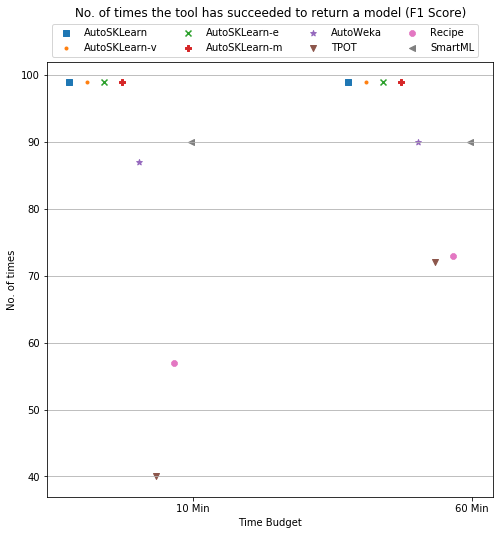

In [35]:
sheet_path = r'C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\AutoML Benchmarking Results.xlsx'
result = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min - F1 Score', '60 Min - F1 Score'])
#result[experiment_time[0]].head(10)
experiment_time = ['10 Min - F1 Score', '60 Min - F1 Score']
experiment_time1 = ['10 Min', '60 Min']
frameworks = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML']
autoSKLearn = [np.sum(result[experiment_time[0]].AutoSkLearn> 0),
            np.sum(result[experiment_time[1]].AutoSkLearn> 0)]
autoSKLearn_v = [np.sum(result[experiment_time[0]].loc[:,'AutoSkLearn - Vanilla']> 0),
            np.sum(result[experiment_time[1]].loc[:, 'AutoSkLearn - Vanilla']> 0)]
autoSKLearn_e = [np.sum(result[experiment_time[0]].loc[:, 'AutoSkLearn - Vanilla + Ensembling']> 0),
            np.sum(result[experiment_time[1]].loc[:, 'AutoSkLearn - Vanilla + Ensembling']> 0)]
autoSKLearn_m = [np.sum(result[experiment_time[0]].loc[:, 'AutoSkLearn - Vanilla + MetaLearning']> 0),
            np.sum(result[experiment_time[1]].loc[:, 'AutoSkLearn - Vanilla + MetaLearning']> 0)]
autoweka = [np.sum(result[experiment_time[0]].AutoWeka> 0),
            np.sum(result[experiment_time[1]].AutoWeka> 0)]
TPOT = [np.sum(result[experiment_time[0]].TPot> 0),
            np.sum(result[experiment_time[1]].TPot> 0)]
Recipe = [np.sum(result[experiment_time[0]].Receipe> 0),
            np.sum(result[experiment_time[1]].Receipe> 0)]
SmartML = [np.sum(result[experiment_time[0]].SmartML> 0),
            np.sum(result[experiment_time[1]].SmartML> 0)]
numerical = [autoSKLearn,
             autoSKLearn_v,
             autoSKLearn_e,
             autoSKLearn_m,
             autoweka,
             TPOT,
             Recipe,
             SmartML]
#rint(np.sum(result['10 Min'].autoweka_accuracy_mean > 0))
#rint((result['10 Min'].autoweka_accuracy_mean > 0).to_string())
number_groups = len(frameworks) 
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(len(experiment_time)) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(len(experiment_time)) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(experiment_time1)
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of times')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of times the tool has succeeded to return a model (F1 Score)', pad = 45)
plt.show()

# How many times each tool has been the best performance? (F1 Score)

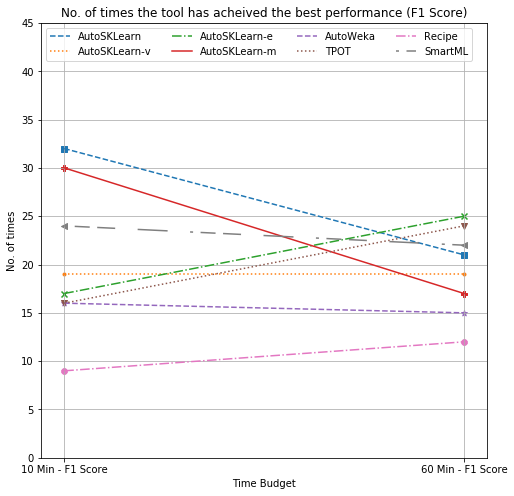

In [36]:
types= ['AutoSkLearn', 'AutoSkLearn - Vanilla', 'AutoSkLearn - Vanilla + Ensembling',
         'AutoSkLearn - Vanilla + MetaLearning', 'AutoWeka', 'TPot', 'Receipe', 'SmartML']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML', 'ATM']
T=[]
for t in experiment_time:
    total = [0,0,0,0,0,0,0,0]
    for i in range(100):
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))
#print(s)
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(t, s[0],linestyle='-',label=labels[0])
style = ['--', ':', '-.', '-', '--', ':', '-.', '-']
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
for i in range(len(types)-1):
    ax.plot(t, s[i],linestyle=style[i],label=labels[i])
    ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[i],
           #color= next(gray_colors),
           marker =next(markers))

line1, = ax.plot(t, s[7],linestyle='-',label=labels[7])
line1.set_dashes([2, 5, 10, 5, 12, 15, 20, 15])
ax.scatter(x=np.arange(len(experiment_time)), 
           y=s[7],
           #color= next(gray_colors),
           marker =next(markers))
ax.set(xlabel='Time Budget', ylabel='No. of times',title='No. of times the tool has acheived the best performance (F1 Score)')
ax.grid()
#plt.xlim([-3, 3])
plt.ylim([0, 45])
plt.legend(loc='upper left', ncol=4, bbox_to_anchor=(0, 1))
plt.show()

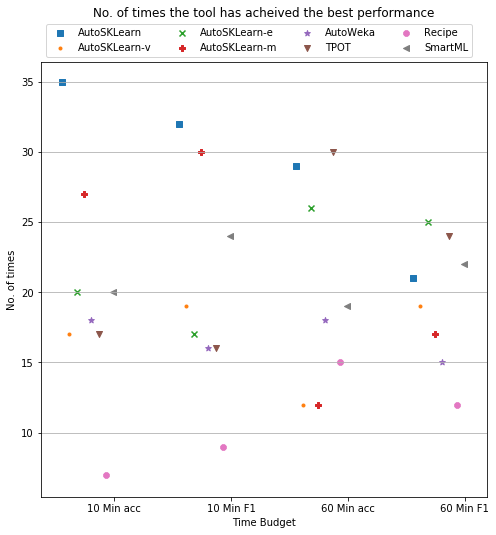

In [37]:
types= ['AutoSkLearn', 'AutoSkLearn - Vanilla', 'AutoSkLearn - Vanilla + Ensembling',
         'AutoSkLearn - Vanilla + MetaLearning', 'AutoWeka', 'TPot', 'Receipe', 'SmartML']
labels = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m','AutoWeka', 'TPOT', 'Recipe', 'SmartML']
T=[]
for t in experiment_time:
    total = [0,0,0,0,0,0,0,0]
    for i in range(100):
        #my_list = [result['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s=[]
for u in range(len(types)):
    s.append(list([T[i][u]for i in range(len(experiment_time))]))


sheet_path = r'C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\Complete_Sheet.xlsx'
result_acc = pd.read_excel(sheet_path, null_values=['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None'],
              sheet_name=['10 Min',  '60 Min'])

types=[ "sklearn_accuracy_mean", "sklearn_v_accuracy_mean", "sklearn_e_accuracy_mean", "sklearn_m_accuracy_mean",
       "autoweka_accuracy_mean", "tpot_accuracy_mean", "recipe_test_acc", "smartml_valid_acc"]
T=[]
for t in ['10 Min',  '60 Min']:
    total = [0,0,0,0,0,0,0,0]
    for i in range(100):
        #my_list = [result_acc['30 Min'].smartml_valid_acc[i],result['30 Min'].sklearn_accuracy_mean[i]]
        my_list= [result_acc[t][x][i] for x in types]
        #print(my_list)
        my_list = [0 if np.isnan(x) else x for x in my_list]
        max_value = max(my_list)
        #print(max_value,my_list)
        indices = [i for i, x in enumerate(my_list) if max_value-x<0.00001]
        for ind in indices:
            total[ind]+=1
    T.append(list(total))
#print(T)

t = experiment_time
s_acc=[]
for u in range(len(types)):
    s_acc.append(list([T[i][u]for i in range(len(experiment_time))]))

numerical = []
for i in range(8):
    n = []
    for (f, a) in zip(s[i], s_acc[i]):
        n.append(a)
        n.append(f)
    numerical.append(n)

number_groups = len(frameworks) 
markers = itertools.cycle(['s','.', 'x', 'P', '*', 'v', '8', '<', 'd'])
bin_width = 1.0/(len(frameworks)+8)
fig, ax = plt.subplots(figsize=(8,8))
for i in range(number_groups):
    ax.scatter(x=np.arange(4) + i*bin_width, 
           y=numerical[i],
           #color= next(gray_colors),
           marker =next(markers))
ax.set_xticks(np.arange(4) + number_groups/(2*(number_groups+1)))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(['10 Min acc', '10 Min F1', '60 Min acc', '60 Min F1'])
l = ax.legend(frameworks[0:len(frameworks)], ncol=len(frameworks)//2, bbox_to_anchor=(0, 1), loc='lower left')
ax.set(xlabel='Time Budget', ylabel='No. of times')
ax.yaxis.grid() # horizontal lines
plt.title(label = 'No. of times the tool has acheived the best performance', pad = 45)
plt.show()

# How much is the performance gain increase by increasing time budget? (F1 Score)

Average loss = -3.3 from 15 datasets
 63 datasets have the same performance
Average gain = 4.3 from 21 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


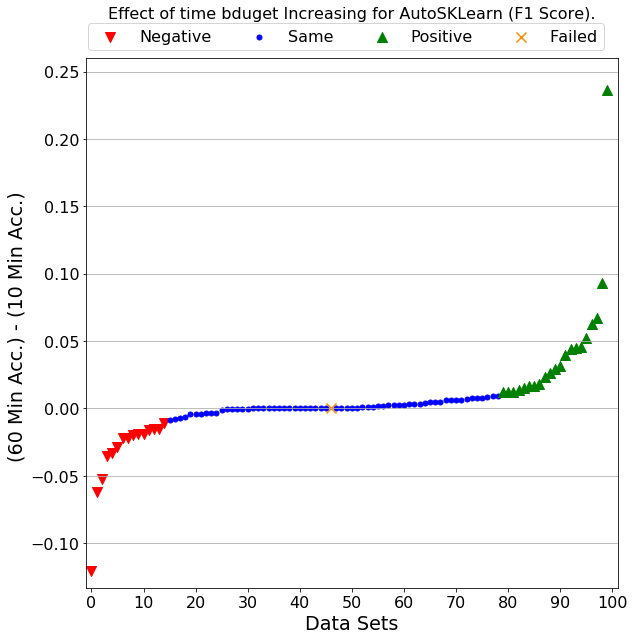

Average loss = -3.6 from 11 datasets
 50 datasets have the same performance
Average gain = 5.6 from 38 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


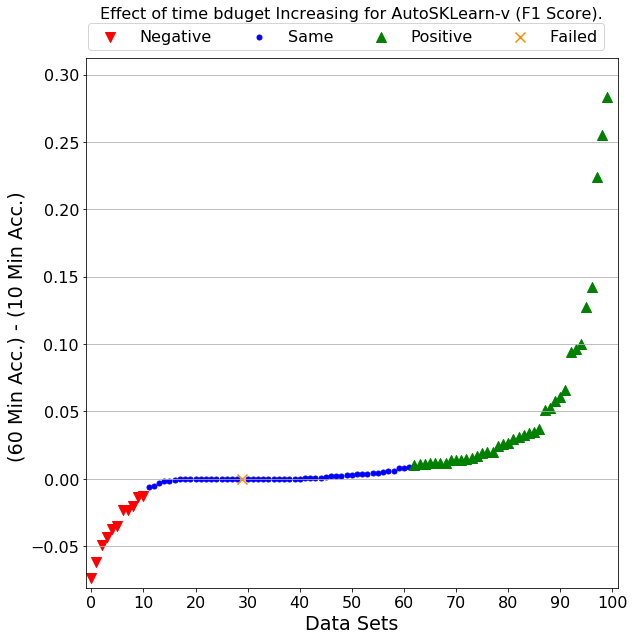

Average loss = -3.7 from 12 datasets
 57 datasets have the same performance
Average gain = 7.1 from 30 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


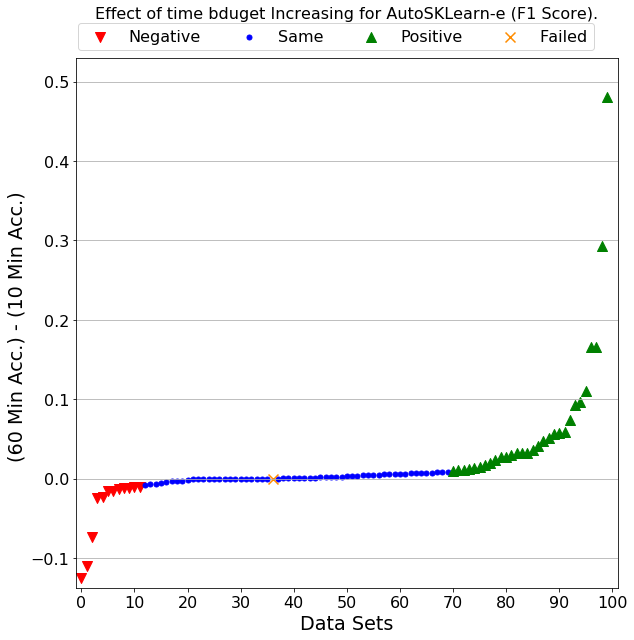

Average loss = -2.8 from 15 datasets
 62 datasets have the same performance
Average gain = 4.3 from 22 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


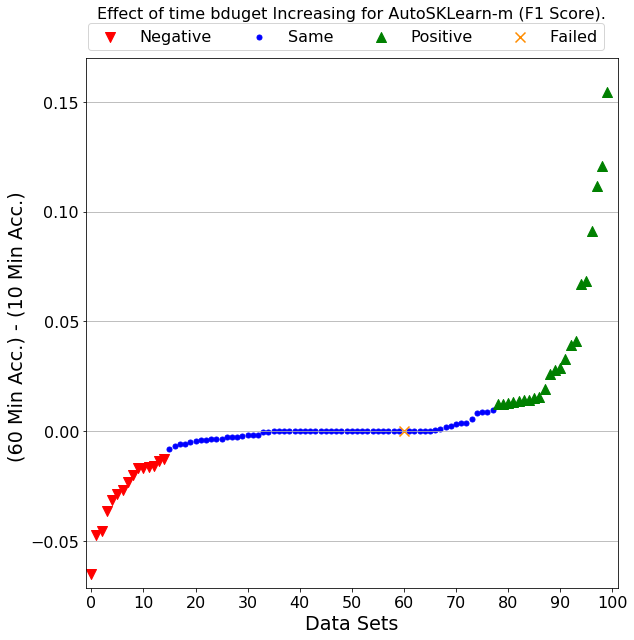

Average loss = -16.0 from 8 datasets
 60 datasets have the same performance
Average gain = 4.6 from 19 datasets
3 datasets succefully run on the right side only
0 datasets succefully run on the left side only
10 datasets succefully do not run on the both sides


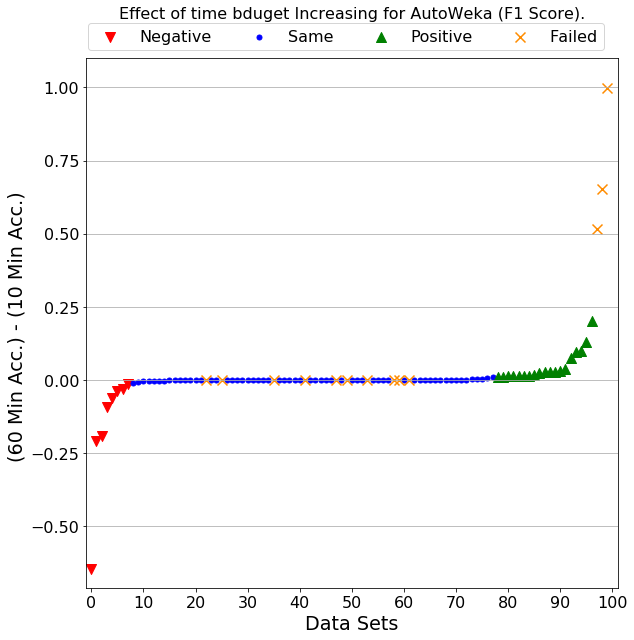

Average loss = -4.6 from 9 datasets
 21 datasets have the same performance
Average gain = 7.1 from 7 datasets
35 datasets succefully run on the right side only
3 datasets succefully run on the left side only
25 datasets succefully do not run on the both sides


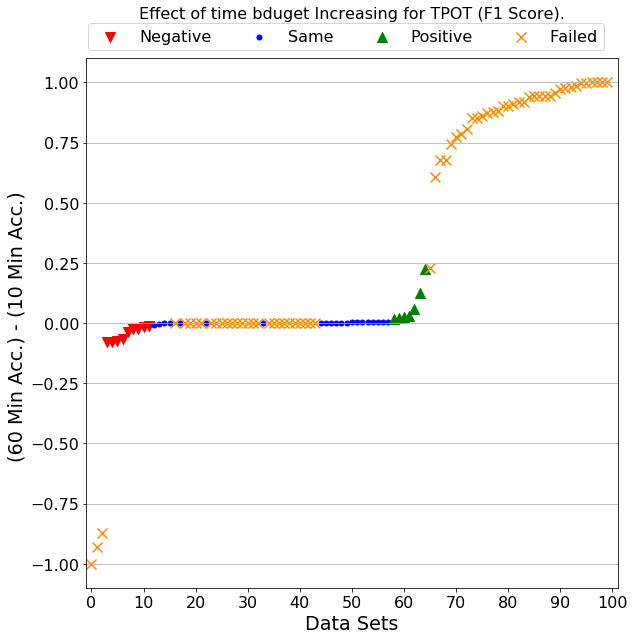

Average loss = -15.1 from 6 datasets
 34 datasets have the same performance
Average gain = 9.9 from 10 datasets
23 datasets succefully run on the right side only
7 datasets succefully run on the left side only
20 datasets succefully do not run on the both sides


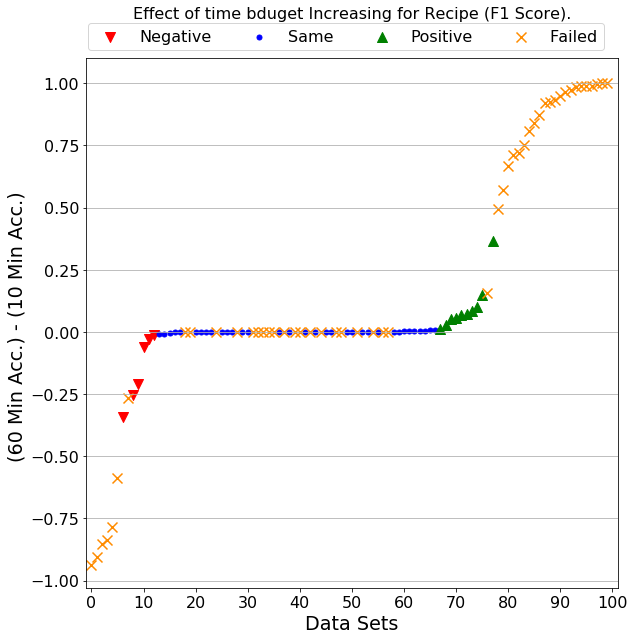

Average loss = -6.6 from 13 datasets
 68 datasets have the same performance
Average gain = 4.3 from 9 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
10 datasets succefully do not run on the both sides


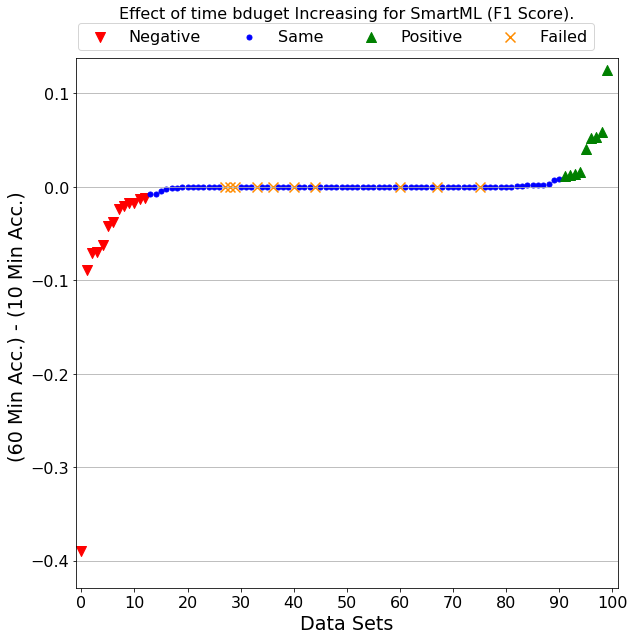

In [38]:
x_label = 'Data Sets'
tools = ['AutoSKLearn', 'AutoSKLearn-v', 'AutoSKLearn-e', 'AutoSKLearn-m', 'AutoWeka', 'TPOT', 'Recipe', 'SmartML']
acc = ['AutoSkLearn', 'AutoSkLearn - Vanilla', 'AutoSkLearn - Vanilla + Ensembling',
         'AutoSkLearn - Vanilla + MetaLearning', 'AutoWeka', 'TPot', 'Receipe', 'SmartML']
t =  ['10 Min - F1 Score', '60 Min - F1 Score']
t1 =  ['10 Min', '60 Min']
sheet_path = r'C:\Users\HassanEldeeb\Documents\GitHub\AutoMLBenchmarking\AutoML Benchmarking Results.xlsx'
for tool, acc in zip(tools,acc):
    for i in range(1, len(t)):
        for j in range(i):
            fig = Figure(sheet_path, sheet_names=t)
            first = fig.get_sheet()[t[i]].loc[:, acc]
            second = fig.get_sheet()[t[j]].loc[:, acc]
            y_lable = '(' + t1[i] + ' Acc.) - (' + t1[j] + ' Acc.) '
            title = 'Effect of time bduget Increasing for '+ tool +' (F1 Score).'
            fig=Figure()
            fig.compare_acc_scatter(first, second, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=None)

# How many times Meta-learning improved the performance and what is the average improvement in AutoSKLearn? (F1 Score)

Average loss = -5.7 from 8 datasets
 64 datasets have the same performance
Average gain = 4.4 from 27 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


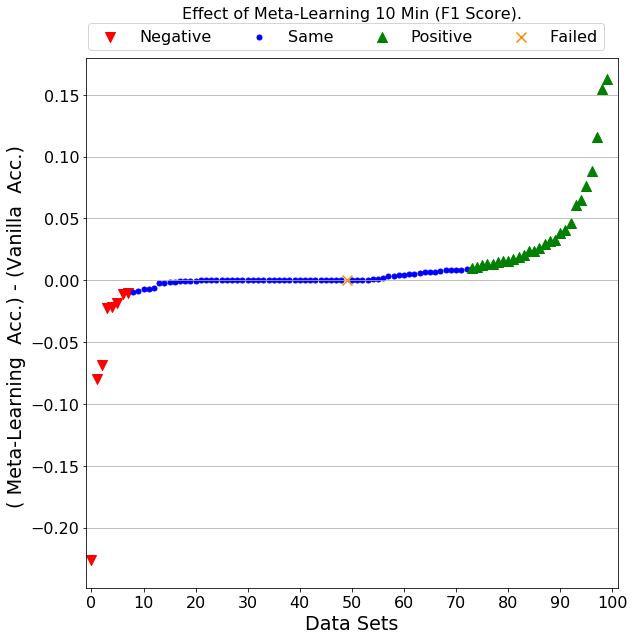

Average loss = -3.9 from 12 datasets
 52 datasets have the same performance
Average gain = 5.0 from 35 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


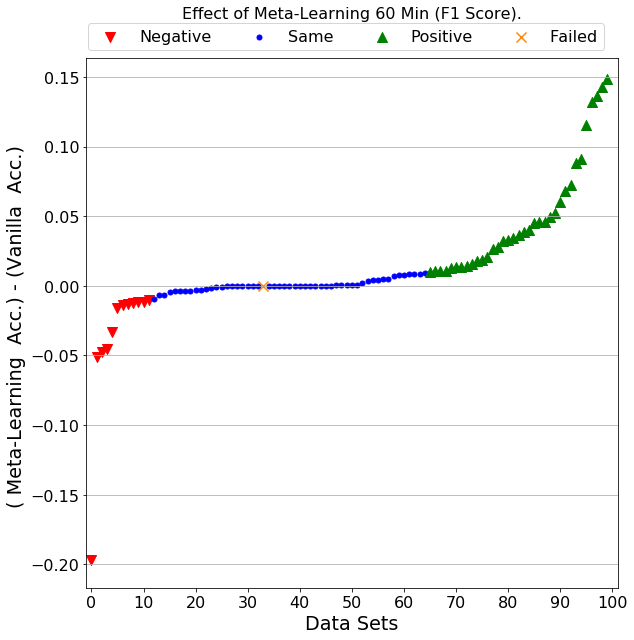

In [39]:
for i in range(len(t)):
    fig = Figure(sheet_path, sheet_names=t)
    meta = fig.get_sheet()[t[i]].loc[:, 'AutoSkLearn - Vanilla + MetaLearning']
    vanilla = fig.get_sheet()[t[j]].loc[:, 'AutoSkLearn - Vanilla']
    y_lable = '( Meta-Learning  Acc.) - (Vanilla  Acc.) '
    title = 'Effect of Meta-Learning '+ t1[i] +' (F1 Score).'
    fig = Figure()
    fig.compare_acc_scatter(meta, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=None)

# How many times Esembling improved the performance and what is the average improvement in AutoSKLearn? (F1 Score)

Average loss = -3.4 from 19 datasets
 58 datasets have the same performance
Average gain = 4.6 from 22 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


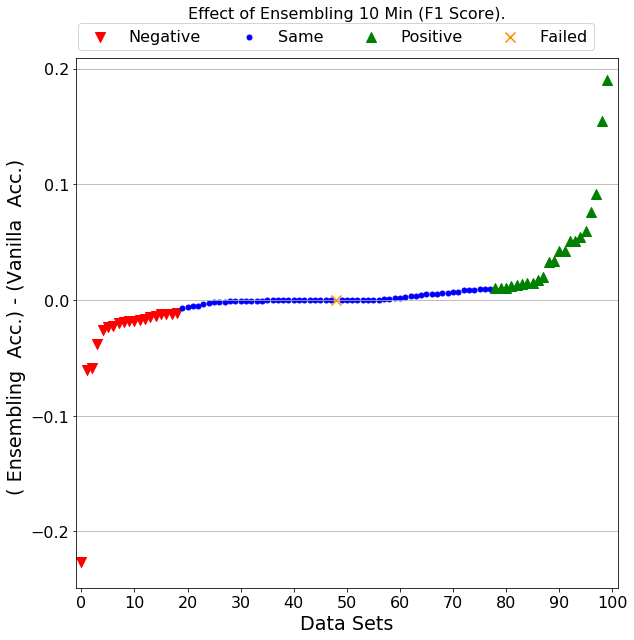

Average loss = -2.7 from 9 datasets
 52 datasets have the same performance
Average gain = 6.4 from 38 datasets
0 datasets succefully run on the right side only
0 datasets succefully run on the left side only
1 datasets succefully do not run on the both sides


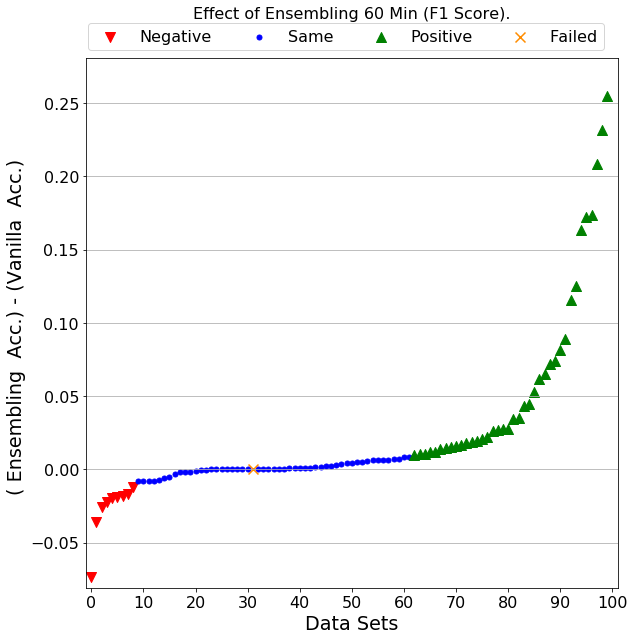

In [40]:
for i in range(len(t)):
    fig = Figure(sheet_path, sheet_names=t)
    ensembling = fig.get_sheet()[t[i]].loc[:, 'AutoSkLearn - Vanilla + Ensembling']
    vanilla = fig.get_sheet()[t[j]].loc[:, 'AutoSkLearn - Vanilla']
    y_lable = '( Ensembling  Acc.) - (Vanilla  Acc.) '
    title = 'Effect of Ensembling '+ t1[i] +' (F1 Score).'
    fig=Figure()
    fig.compare_acc_scatter(ensembling, vanilla, x_label, y_lable, title, fig_size=(9,9), legend_x_shift=-0.012, y_limit=None)